In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import gseapy as gp

from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter as cox
from matplotlib import pyplot as plt
from pandas import DataFrame as df
from scipy import stats
from IPython.display import Image

import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import gc
gc.collect()

333

# Global Path

In [3]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
data_home = poseidon_home + 'data/'
gsea_home = poseidon_home + 'GSEA/'
cmap_home = data_home + 'CMAP2020_Cancer/'
shift_home = poseidon_home + 'shift_ability/'
panel_home = poseidon_home + 'panels/Figure3/'
panel_home_new = poseidon_home + 'panels/Figure3_new/'

# Read Data

In [4]:
sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/siginfo_beta.txt',
                            header=0, index_col='sig_id', sep='\t')
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

Official NCBI gene symbol
Official NCBI gene id                          
5720                                      PSME1
7416                                      VDAC1
55847                                     CISD1
10174                                    SORBS3
25803                                     SPDEF
...                                         ...
5137                                      PDE1C
51233                                    DRICH1
4340                                        MOG
1656                                       DDX6
23620                                     NTSR2

[10174 rows x 1 columns]

In [6]:
EC_gene_info = pd.read_csv(poseidon_home + 'EC_signatures/all_NREC_REC_gene_info.csv',
                           header=0, index_col=0, sep=',')

In [7]:
EC_gene_info

EC_profile total_shRNA_expr total_pharmacological_expr  \
TYRO3         NR-EC                6              Not available   
TMCC2         NR-EC    Not available              Not available   
NDRG3         NR-EC    Not available              Not available   
ATP9A         NR-EC    Not available              Not available   
FGD1          NR-EC    Not available              Not available   
...             ...              ...                        ...   
TNFRSF1B       R-EC    Not available              Not available   
CFLAR          R-EC               31              Not available   
NCF4           R-EC    Not available              Not available   
NSMCE4A        R-EC    Not available              Not available   
BLNK           R-EC                2              Not available   

                                           shRNA_cell_lines  \
TYRO3                       ['MCF7', 'VCAP', 'PC3', 'A375']   
TMCC2                                         Not available   
NDRG3                                         Not available   
ATP9A                                         Not available   
FGD1                                          Not available   
...                                                     ...   
TNFRSF1B                                      Not available   
CFLAR     ['A375', 'A549', 'VCAP', 'HT29', 'HCC515', 'HE...   
NCF4                                          Not available   
NSMCE4A                                       Not available   
BLNK                                      ['HEKTE', 'A375']   

         compound_cell_lines  
TYRO3          Not available  
TMCC2          Not available  
NDRG3          Not available  
ATP9A          Not available  
FGD1           Not available  
...                      ...  
TNFRSF1B       Not available  
CFLAR          Not available  
NCF4           Not available  
NSMCE4A        Not available  
BLNK           Not available  

[1329 rows x 5 columns]

In [8]:
# all R-shifting compounds: shift ability > 0.5
rs_cp_shift = pd.read_csv(poseidon_home + 'results/compound_top_moa/all_Rshifting_table.csv',
                          header=0, index_col=0, sep=',')

In [9]:
rs_cp_shift

NREC_profile  REC_profile    cmap_name  nearest_dose  \
REP.A023_MCF7_24H:P14       -0.471999     0.456107  floxuridine         3.330   
LKCP002_MCF7_48H:B10        -0.458585     0.468354   tipifarnib        10.000   
PBIOA016_MCF7_24H:H03       -0.470885     0.447807  fulvestrant         1.110   
REP.A023_MCF7_24H:O15       -0.503013     0.412289   valrubicin         1.110   
REP.A015_MCF7_24H:E11       -0.473579     0.441700   epirubicin         0.125   
...                               ...          ...          ...           ...   
AICHI002_SKMEL5_24H:M12     -0.249891     0.269380   dinaciclib         0.010   
EMU001_SKMEL5_24H:K14       -0.303896     0.212090   paclitaxel         2.500   
AICHI002_SKMEL5_24H:M13     -0.339857     0.167980       CINK-4        10.000   
EMU001_SKMEL5_24H:O13       -0.295800     0.206277  LCB-03-0110        10.000   
AICHI002_SKMEL5_24H:N01     -0.292263     0.209703  PF-05212384        10.000   

                        pert_idose  shift_ability cell_line cancer_type  
REP.A023_MCF7_24H:P14      3.33 uM       0.928106      MCF7        BRCA  
LKCP002_MCF7_48H:B10         10 uM       0.926939      MCF7        BRCA  
PBIOA016_MCF7_24H:H03      1.11 uM       0.918692      MCF7        BRCA  
REP.A023_MCF7_24H:O15      1.11 uM       0.915302      MCF7        BRCA  
REP.A015_MCF7_24H:E11     0.125 uM       0.915279      MCF7        BRCA  
...                            ...            ...       ...         ...  
AICHI002_SKMEL5_24H:M12    0.01 uM       0.519271    SKMEL5        SKCM  
EMU001_SKMEL5_24H:K14       2.5 uM       0.515986    SKMEL5        SKCM  
AICHI002_SKMEL5_24H:M13      10 uM       0.507837    SKMEL5        SKCM  
EMU001_SKMEL5_24H:O13        10 uM       0.502077    SKMEL5        SKCM  
AICHI002_SKMEL5_24H:N01      10 uM       0.501966    SKMEL5        SKCM  

[19870 rows x 8 columns]

In [10]:
# all shifting results
compound_cancer = ['BLCA', 'BRCA', 'CESC', 'CRC', 'LIHC', 'LUNG',
                   'OV', 'PAAD', 'PRAD', 'SKCM', 'STAD', 'UCEC']
# read the compound enrichment results
compound_result = {}
for ct in compound_cancer:
    compound_result[ct] = pd.read_csv(shift_home + ct + '_trt_cp.csv',
                                   sep=',', index_col=0)
    compound_result[ct]['cancer_type'] = ct
    print(ct, compound_result[ct].shape)

all_cp_shift = pd.concat([compound_result[d] for d in compound_result.keys()], axis=0)
all_cp_shift['cell_line'] = sig_info['cell_mfc_name']

BLCA (5, 7)
BRCA (9573, 7)
CESC (2906, 7)
CRC (4516, 7)
LIHC (2361, 7)
LUNG (6901, 7)
OV (53, 7)
PAAD (1906, 7)
PRAD (8107, 7)
SKCM (4917, 7)
STAD (38, 7)
UCEC (38, 7)


In [11]:
all_cp_shift['pert_time'] = sig_info['pert_time']

In [12]:
all_cp_shift['cell_line'].unique().shape

(64,)

In [13]:
compound_info[compound_info.index.isin(all_cp_shift['cmap_name'].unique())]['moa'].unique().shape

(392,)

In [14]:
rs_cp_shift = all_cp_shift[all_cp_shift['shift_ability'] >= .7]

In [15]:
rs_cp_shift['cmap_name'].unique().shape

(780,)

In [16]:
rs_cp_shift['cell_line'].unique().shape

(35,)

In [17]:
all_cp_shift.shape

(41321, 9)

In [28]:
compound_mega = all_cp_shift.copy()
compound_mega = compound_mega.rename(columns={'NREC_profile': 'EnrichScore Rsig',
                                              'REC_profile': 'EnrichScore Ssig',
                                              'shift_ability': 'Shift Ability'})

In [29]:
compound_mega['Drug Target'] = 'Not available'
compound_mega['Significant Shift'] = 'No'
for c in compound_mega.index:
    if c in rs_cp_shift.index:
        compound_mega.at[c, 'Significant Shift'] = 'Yes'
    
    if compound_mega.loc[c, 'cmap_name'] in compound_info.index:
        compound_mega.at[c, 'Drug Target'] = compound_info.loc[compound_mega.loc[c, 'cmap_name'], 'moa']
compound_mega['Drug Target'] = compound_mega['Drug Target'].fillna('Not available')

In [31]:
compound_mega = compound_mega.sort_values(by='Shift Ability', ascending=False)

In [33]:
compound_mega.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/Tables/TableS4/all_compound_shift_result_mega.csv', sep=',')

In [18]:
rs_cp_shift.shape

(3983, 9)

In [19]:
rs_cp_shift['pert_idose'].unique()

array(['10 uM', '3.33 uM', '1.11 uM', '0.37 uM', '0.125 uM', '0.03 uM',
       '2.22 uM', '0.74 uM', '0.04 uM', '0.25 uM', '0.12 uM', '0.07 uM',
       '0.08 uM', '20 uM', '30 uM', '0.01 uM', '4 uM', '1.25 uM',
       '2.5 uM', '12 uM', '80 uM', '60 uM', '0.66 uM', '0.2 uM', '0.3 uM',
       '0.5 uM', '6.66 uM', '40 uM', '8 uM', '12.5 uM', '25 uM',
       '1.67 uM', '90 uM', '0.025 uM', '200 uM'], dtype=object)

In [20]:
rs_cp_shift['nearest_dose'].unique()

array([1.00e+01, 3.33e+00, 1.11e+00, 3.70e-01, 1.25e-01, 3.00e-02,
       2.22e+00, 7.40e-01, 4.00e-02, 2.50e-01, 1.20e-01, 7.00e-02,
       8.00e-02, 2.00e+01, 3.00e+01, 1.00e-02, 4.00e+00, 1.25e+00,
       2.50e+00, 1.20e+01, 8.00e+01, 6.00e+01, 6.60e-01, 2.00e-01,
       3.00e-01, 5.00e-01, 6.66e+00, 4.00e+01, 8.00e+00, 1.25e+01,
       2.50e+01, 1.67e+00, 9.00e+01, 2.50e-02, 2.00e+02])

In [30]:
rs_cp_shift['pert_time'] = sig_info['pert_time']

<ipython-input-30-4609fe4749b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rs_cp_shift['pert_time'] = sig_info['pert_time']


In [31]:
rs_cp_shift['pert_time'].unique()

array([24., 48.,  6.,  3.])

In [34]:
all_cp_shift['pert_time'].unique()

array([24., 48.,  6.,  3.,  2., 72.])

# Dosage (2023.3.6)

In [151]:
# all shifting
all_cp_shift['pert_time'].unique()

array([24., 48.,  6.,  3.,  2., 72.])

In [36]:
# all r-2-s shifting (shift >= .7)
rs_cp_shift['pert_time'].unique()

array([24., 48.,  6.,  3.])

## 1. Corr with dosage, 24h only, by cell lines

In [56]:
dosage_corr = df(columns=['cell_line', 'cmap_name', 'moa', 'sample_number',
                          'dosage_number', 'shift_high', 'shift_low',
                          'corr_shift', 'p_shift',
                          'corr_R', 'p_R',
                          'corr_S', 'p_S'])
for d in all_cp_shift['cmap_name'].unique():
    tmp_d = all_cp_shift[all_cp_shift['cmap_name'] == d]

    
    for cl in tmp_d['cell_line'].unique():
        tmp_d_cl = tmp_d[tmp_d['cell_line'] == cl]
        if d in compound_info.index:
            dosage_corr.at[cl + '|' + d, 'moa'] = compound_info.loc[d, 'moa']
        
        # only use 24h
        tmp_d_cl = tmp_d_cl[tmp_d_cl['pert_time'] == 24.]
        
        dosage_corr.at[cl + '|' + d, 'cell_line'] = cl
        dosage_corr.at[cl + '|' + d, 'cmap_name'] = d
        dosage_corr.at[cl + '|' + d, 'sample_number'] = tmp_d_cl.shape[0]
        dosage_corr.at[cl + '|' + d, 'dosage_number'] = tmp_d_cl['nearest_dose'].unique().shape[0]
        dosage_corr.at[cl + '|' + d, 'shift_high'] = tmp_d_cl['shift_ability'].max()
        dosage_corr.at[cl + '|' + d, 'shift_low'] = tmp_d_cl['shift_ability'].min()
        
        # correlation with only sample size > 5 and dosage number > 3
        if dosage_corr.loc[cl + '|' + d, 'sample_number'] >= 5 and dosage_corr.at[cl + '|' + d, 'dosage_number'] >= 3:
            c_sh, p_sh = stats.pearsonr(tmp_d_cl['shift_ability'], tmp_d_cl['nearest_dose'])
            c_s, p_s = stats.pearsonr(tmp_d_cl['REC_profile'], tmp_d_cl['nearest_dose'])
            c_r, p_r = stats.pearsonr(tmp_d_cl['NREC_profile'], tmp_d_cl['nearest_dose'])
            
            dosage_corr.at[cl + '|' + d, 'corr_shift'] = c_sh
            dosage_corr.at[cl + '|' + d, 'p_shift'] = p_sh
            dosage_corr.at[cl + '|' + d, 'corr_R'] = c_r
            dosage_corr.at[cl + '|' + d, 'p_R'] = p_r
            dosage_corr.at[cl + '|' + d, 'corr_S'] = c_s
            dosage_corr.at[cl + '|' + d, 'p_S'] = p_s
        

In [150]:
dosage_corr.to_csv(poseidon_home + 'dosage/dose_shift_corr_cp_all.csv', sep=',')

In [57]:
dosage_corr_cleaned = dosage_corr.dropna(axis=0, how='any')

In [58]:
dosage_corr_cleaned = dosage_corr_cleaned.sort_values(by='p_shift', ascending=True)

In [59]:
dosage_corr_cleaned[:50]

cell_line      cmap_name  \
A549|MG-132              A549         MG-132   
HEPG2|mitoxantrone      HEPG2   mitoxantrone   
A549|withaferin-a        A549   withaferin-a   
A549|daunorubicin        A549   daunorubicin   
MCF7|mitoxantrone        MCF7   mitoxantrone   
A375|mitoxantrone        A375   mitoxantrone   
A549|mitoxantrone        A549   mitoxantrone   
HT29|mitoxantrone        HT29   mitoxantrone   
YAPC|bortezomib          YAPC     bortezomib   
HT29|SN-38               HT29          SN-38   
PC3|MG-132                PC3         MG-132   
HT29|doxorubicin         HT29    doxorubicin   
HCC515|geldanamycin    HCC515   geldanamycin   
MCF7|entinostat          MCF7     entinostat   
A375|vorinostat          A375     vorinostat   
MCF7|epirubicin          MCF7     epirubicin   
PC3|volasertib            PC3     volasertib   
VCAP|cycloheximide       VCAP  cycloheximide   
PC3|geldanamycin          PC3   geldanamycin   
HELA|bortezomib          HELA     bortezomib   
PC3|wortmannin            PC3     wortmannin   
HELA|SB-743921           HELA      SB-743921   
A549|doxorubicin         A549    doxorubicin   
MCF7|torin-2             MCF7        torin-2   
PC3|paclitaxel            PC3     paclitaxel   
MCF7|doxorubicin         MCF7    doxorubicin   
MCF7|narciclasine        MCF7   narciclasine   
YAPC|camptothecin        YAPC   camptothecin   
HELA|danazol             HELA        danazol   
PC3|bortezomib            PC3     bortezomib   
A549|molsidomine         A549    molsidomine   
HCC515|topotecan       HCC515      topotecan   
HT29|SB-743921           HT29      SB-743921   
MDAMB231|paclitaxel  MDAMB231     paclitaxel   
A549|wortmannin          A549     wortmannin   
HT29|PHA-848125          HT29     PHA-848125   
A549|emetine             A549        emetine   
YAPC|genz-644282         YAPC    genz-644282   
A549|bortezomib          A549     bortezomib   
PC3|cytarabine            PC3     cytarabine   
MCF7|withaferin-a        MCF7   withaferin-a   
HS578T|AZD-8055        HS578T       AZD-8055   
PC3|PCI-24781             PC3      PCI-24781   
MCF7|dacinostat          MCF7     dacinostat   
YAPC|PHA-848125          YAPC     PHA-848125   
HELA|genz-644282         HELA    genz-644282   
YAPC|mitoxantrone        YAPC   mitoxantrone   
HEPG2|thapsigargin      HEPG2   thapsigargin   
A375|buparlisib          A375     buparlisib   
VCAP|vorinostat          VCAP     vorinostat   

                                                        moa sample_number  \
A549|MG-132                            Proteasome inhibitor           549   
HEPG2|mitoxantrone                  Topoisomerase inhibitor            88   
A549|withaferin-a                             IKK inhibitor            38   
A549|daunorubicin                   RNA synthesis inhibitor            22   
MCF7|mitoxantrone                   Topoisomerase inhibitor            73   
A375|mitoxantrone                   Topoisomerase inhibitor            49   
A549|mitoxantrone                   Topoisomerase inhibitor            88   
HT29|mitoxantrone                   Topoisomerase inhibitor            48   
YAPC|bortezomib                        Proteasome inhibitor           432   
HT29|SN-38                          Topoisomerase inhibitor             9   
PC3|MG-132                             Proteasome inhibitor           670   
HT29|doxorubicin                    Topoisomerase inhibitor            18   
HCC515|geldanamycin                           HSP inhibitor            21   
MCF7|entinostat                              HDAC inhibitor            22   
A375|vorinostat                              HDAC inhibitor            62   
MCF7|epirubicin                     Topoisomerase inhibitor            17   
PC3|volasertib                                PLK inhibitor            18   
VCAP|cycloheximide              Protein synthesis inhibitor             6   
PC3|geldanamycin                              HSP inhibitor            61   
HELA|bortezomib                

<AxesSubplot:xlabel='corr_shift', ylabel='Density'>

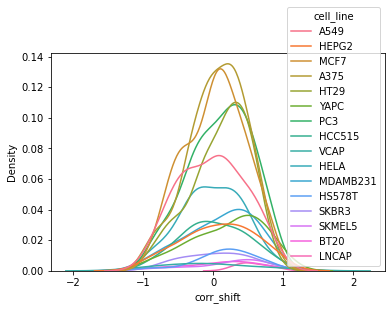

In [60]:
sns.kdeplot(x='corr_shift', hue='cell_line', data=dosage_corr_cleaned)

In [102]:
dosage_corr_cleaned[dosage_corr_cleaned['cmap_name'] == 'PF-03758309']

cell_line    cmap_name                             moa  \
PC3|PF-03758309          PC3  PF-03758309  P21 activated kinase inhibitor   
A375|PF-03758309        A375  PF-03758309  P21 activated kinase inhibitor   
YAPC|PF-03758309        YAPC  PF-03758309  P21 activated kinase inhibitor   
HT29|PF-03758309        HT29  PF-03758309  P21 activated kinase inhibitor   
MCF7|PF-03758309        MCF7  PF-03758309  P21 activated kinase inhibitor   
HCC515|PF-03758309    HCC515  PF-03758309  P21 activated kinase inhibitor   
HELA|PF-03758309        HELA  PF-03758309  P21 activated kinase inhibitor   

                   sample_number dosage_number shift_high   shift_low  \
PC3|PF-03758309               18            11    0.84298    0.507257   
A375|PF-03758309              13             8   0.792535    0.415346   
YAPC|PF-03758309               7             7   0.724963  -0.0546311   
HT29|PF-03758309               8             6   0.815343     0.54099   
MCF7|PF-03758309              10             9   0.790873   0.0182244   
HCC515|PF-03758309             5             5   0.707347    0.494511   
HELA|PF-03758309               9             5   0.508504 -0.00416803   

                    corr_shift    p_shift    corr_R        p_R     corr_S  \
PC3|PF-03758309      -0.565695  0.0144092  0.558392  0.0160187  -0.402722   
A375|PF-03758309      0.514052  0.0723183 -0.556945  0.0480243   0.319756   
YAPC|PF-03758309     -0.237532   0.608032 -0.629206   0.130041  -0.504345   
HT29|PF-03758309     -0.189756   0.652655 -0.134361   0.751088   -0.38377   
MCF7|PF-03758309      0.076858   0.832864  0.106434   0.769795   0.103892   
HCC515|PF-03758309   -0.108875    0.86165  0.264113   0.667673 -0.0412038   
HELA|PF-03758309      0.013533   0.972436  -0.19663   0.612112 -0.0371607   

                          p_S  
PC3|PF-03758309     0.0975241  
A375|PF-03758309      0.28687  
YAPC|PF-03758309       0.2484  
HT29|PF-03758309     0.347961  
MCF7|PF-03758309     0.775173  
HCC515|PF-03758309   0.947552  
HELA|PF-03758309     0.924384

In [90]:
dosage_corr_cleaned['corr_shift'] = dosage_corr_cleaned['corr_shift'].astype(float)

## 2. Shift corr across moa

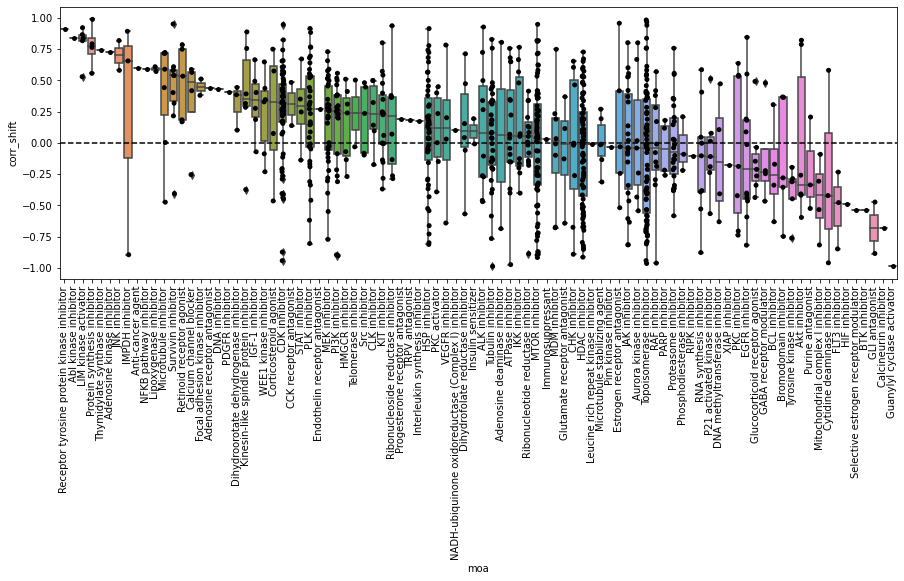

In [94]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='moa', y='corr_shift',
            order=dosage_corr_cleaned.groupby('moa').median().sort_values(by='corr_shift', ascending=False).index,
            data=dosage_corr_cleaned)
sns.stripplot(x='moa', y='corr_shift',
              order=dosage_corr_cleaned.groupby('moa').median().sort_values(by='corr_shift', ascending=False).index,
              data=dosage_corr_cleaned, color='k')
plt.xticks(rotation=90)
plt.axhline(y=0., ls='--', c='k')
plt.show()

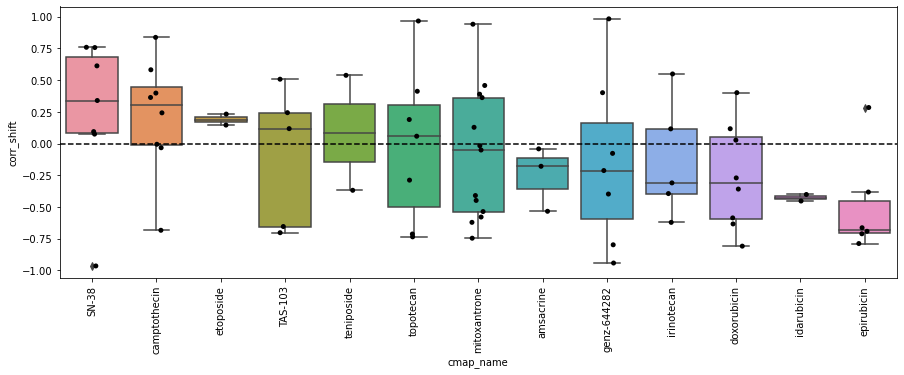

In [98]:
# Topoisomerase
tmp_case = dosage_corr_cleaned[dosage_corr_cleaned['moa'] == 'Topoisomerase inhibitor']
plt.figure(figsize=(15, 5))
sns.boxplot(x='cmap_name', y='corr_shift',
            order=tmp_case.groupby('cmap_name').median().sort_values(by='corr_shift', ascending=False).index,
            data=tmp_case)
sns.stripplot(x='cmap_name', y='corr_shift',
              order=tmp_case.groupby('cmap_name').median().sort_values(by='corr_shift', ascending=False).index,
              data=tmp_case, color='k')
plt.xticks(rotation=90)
plt.axhline(y=0., ls='--', c='k')
plt.show()

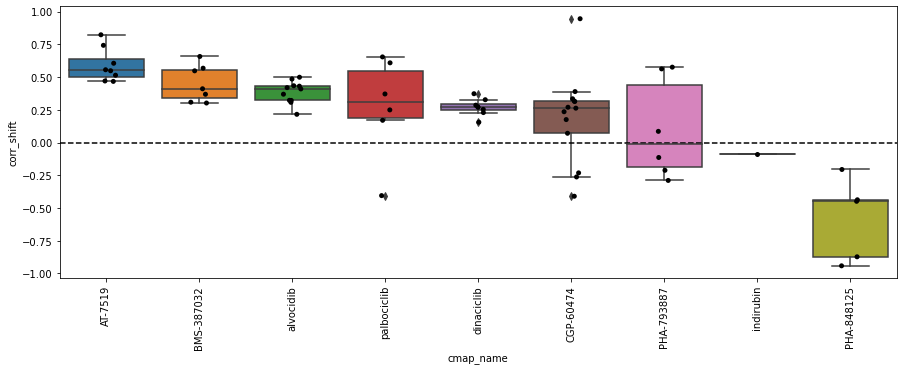

In [99]:
# CDK inhibitor
tmp_case = dosage_corr_cleaned[dosage_corr_cleaned['moa'] == 'CDK inhibitor']
plt.figure(figsize=(15, 5))
sns.boxplot(x='cmap_name', y='corr_shift',
            order=tmp_case.groupby('cmap_name').median().sort_values(by='corr_shift', ascending=False).index,
            data=tmp_case)
sns.stripplot(x='cmap_name', y='corr_shift',
              order=tmp_case.groupby('cmap_name').median().sort_values(by='corr_shift', ascending=False).index,
              data=tmp_case, color='k')
plt.xticks(rotation=90)
plt.axhline(y=0., ls='--', c='k')
plt.show()

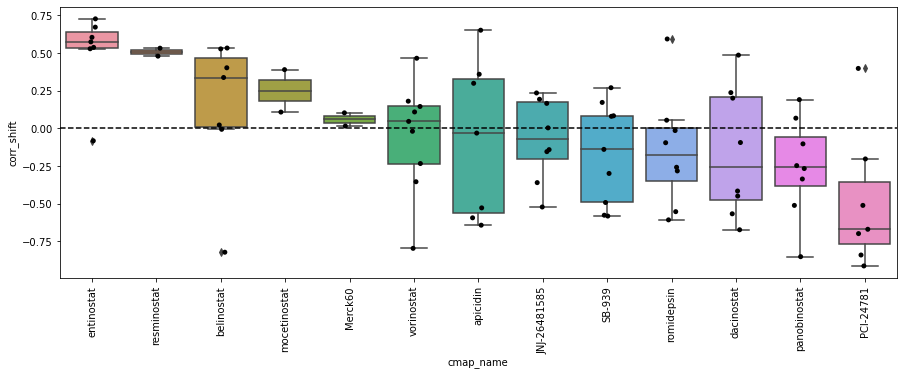

In [100]:
# HDAC inhibitor
tmp_case = dosage_corr_cleaned[dosage_corr_cleaned['moa'] == 'HDAC inhibitor']
plt.figure(figsize=(15, 5))
sns.boxplot(x='cmap_name', y='corr_shift',
            order=tmp_case.groupby('cmap_name').median().sort_values(by='corr_shift', ascending=False).index,
            data=tmp_case)
sns.stripplot(x='cmap_name', y='corr_shift',
              order=tmp_case.groupby('cmap_name').median().sort_values(by='corr_shift', ascending=False).index,
              data=tmp_case, color='k')
plt.xticks(rotation=90)
plt.axhline(y=0., ls='--', c='k')
plt.show()

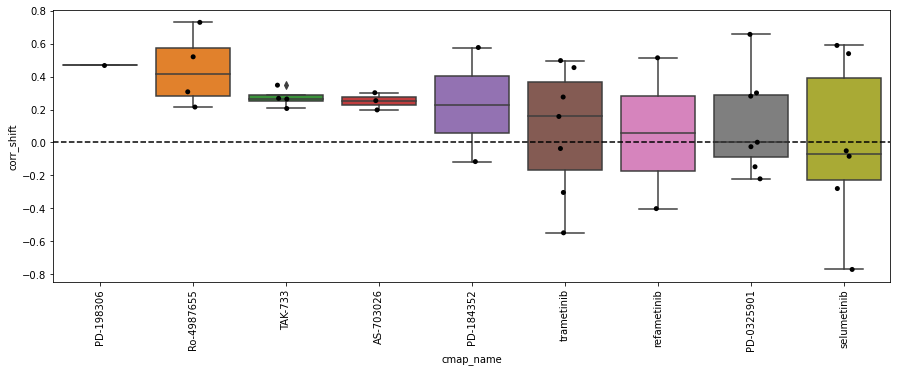

In [101]:
# MEK inhibitor
tmp_case = dosage_corr_cleaned[dosage_corr_cleaned['moa'] == 'MEK inhibitor']
plt.figure(figsize=(15, 5))
sns.boxplot(x='cmap_name', y='corr_shift',
            order=tmp_case.groupby('cmap_name').median().sort_values(by='corr_shift', ascending=False).index,
            data=tmp_case)
sns.stripplot(x='cmap_name', y='corr_shift',
              order=tmp_case.groupby('cmap_name').median().sort_values(by='corr_shift', ascending=False).index,
              data=tmp_case, color='k')
plt.xticks(rotation=90)
plt.axhline(y=0., ls='--', c='k')
plt.show()

## 3. Shift corr. dose in individual drugs

In [128]:
def ShcorDoDrug(cell_line, drug_name, shift_result, corr_result):
    '''
    Show correlation between dosage and shifting in specific cases
    '''
    tmp_shift = shift_result[shift_result['cmap_name'] == drug_name]
    tmp_shift = tmp_shift[tmp_shift['cell_line'] == cell_line]
    tmp_shift = tmp_shift[tmp_shift['pert_time'] == 24.] # only show 24h
    
    # visualization
    f, axes = plt.subplots(1, 3, figsize=(10, 3))
    im=axes[0].scatter(x='nearest_dose', y='shift_ability',
                       data=tmp_shift, color='violet')
    plt.sca(axes[0])
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('shift ability')
    plt.title('shift ability\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_shift'], 4)))
    plt.yticks(rotation=90)
    
    im=axes[1].scatter(x='nearest_dose', y='NREC_profile',
                       data=tmp_shift, color='crimson')
    plt.sca(axes[1])
    plt.title('R score\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_R'], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('R score')
    
    im=axes[2].scatter(x='nearest_dose', y='REC_profile',
                       data=tmp_shift, color='royalblue')
    plt.sca(axes[2])
    plt.title('S score\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_S'], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('S score')
    
    plt.show()
    
    return

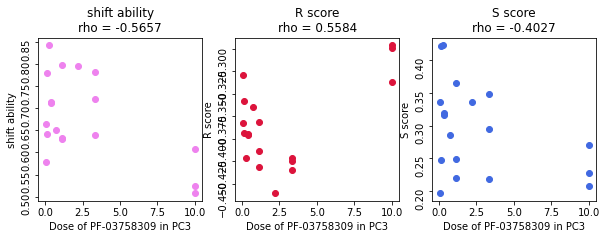

In [129]:
ShcorDoDrug(cell_line='PC3',
            drug_name='PF-03758309',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

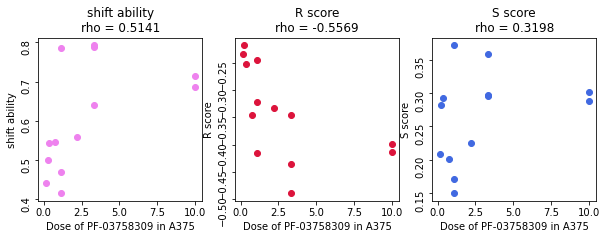

In [130]:
ShcorDoDrug(cell_line='A375',
            drug_name='PF-03758309',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

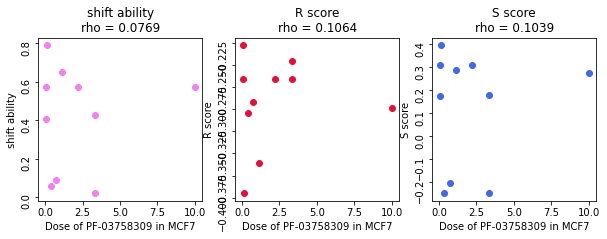

In [142]:
ShcorDoDrug(cell_line='MCF7',
            drug_name='PF-03758309',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

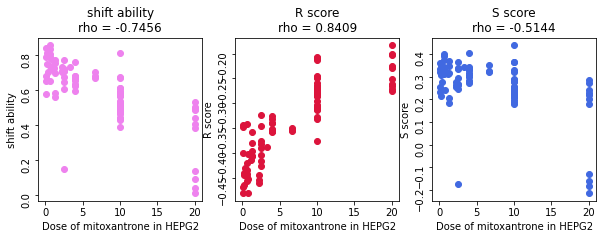

In [131]:
ShcorDoDrug(cell_line='HEPG2',
            drug_name='mitoxantrone',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

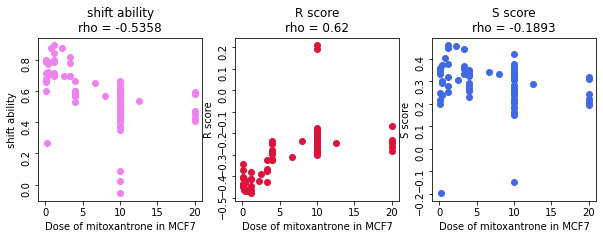

In [132]:
ShcorDoDrug(cell_line='MCF7',
            drug_name='mitoxantrone',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

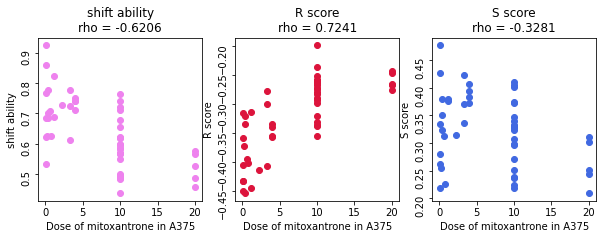

In [133]:
ShcorDoDrug(cell_line='A375',
            drug_name='mitoxantrone',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

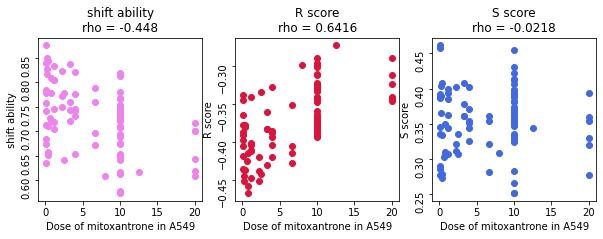

In [134]:
ShcorDoDrug(cell_line='A549',
            drug_name='mitoxantrone',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

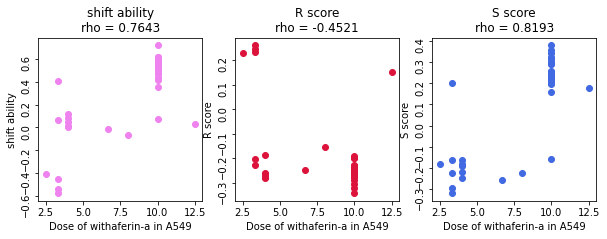

In [136]:
ShcorDoDrug(cell_line='A549',
            drug_name='withaferin-a',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

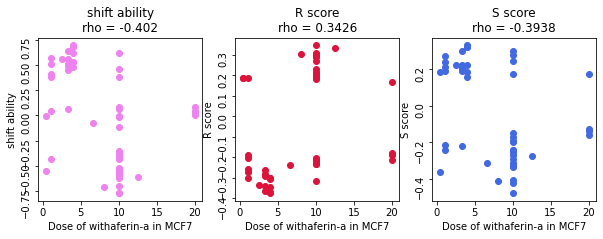

In [146]:
ShcorDoDrug(cell_line='MCF7',
            drug_name='withaferin-a',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

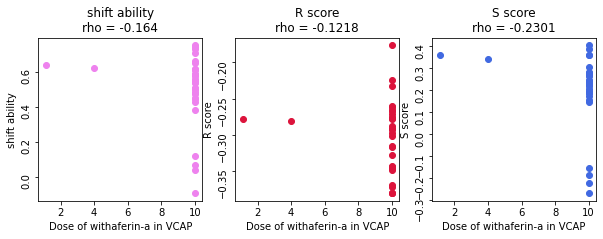

In [149]:
ShcorDoDrug(cell_line='VCAP',
            drug_name='withaferin-a',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

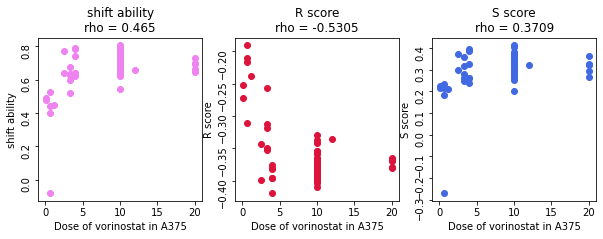

In [138]:
ShcorDoDrug(cell_line='A375',
            drug_name='vorinostat',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

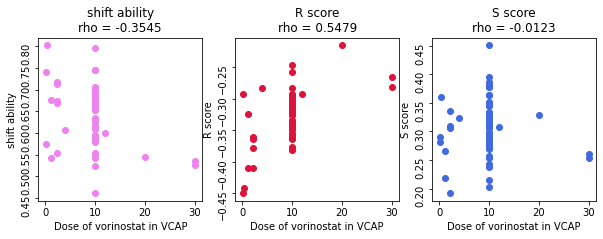

In [141]:
ShcorDoDrug(cell_line='VCAP',
            drug_name='vorinostat',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

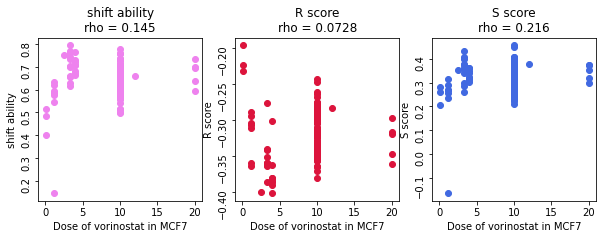

In [145]:
ShcorDoDrug(cell_line='MCF7',
            drug_name='vorinostat',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

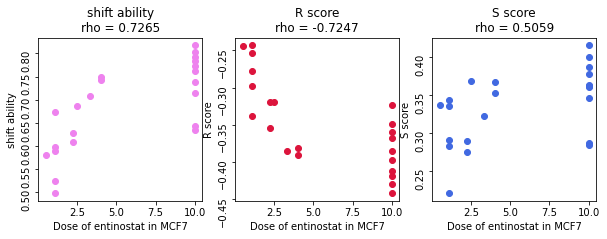

In [140]:
ShcorDoDrug(cell_line='MCF7',
            drug_name='entinostat',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

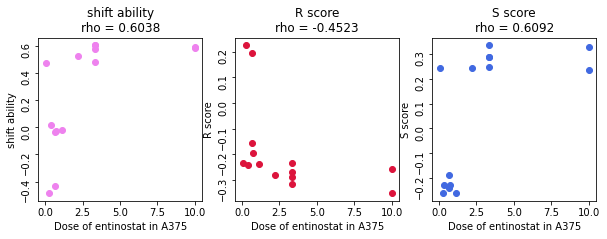

In [143]:
ShcorDoDrug(cell_line='A375',
            drug_name='entinostat',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

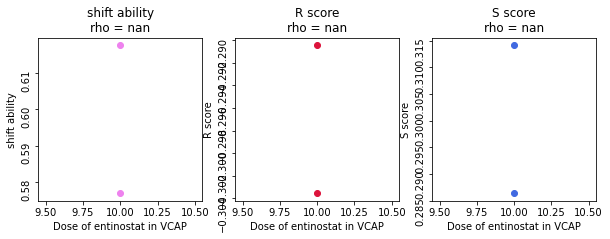

In [144]:
ShcorDoDrug(cell_line='VCAP',
            drug_name='entinostat',
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

In [152]:
all_cp_shift

NREC_profile  REC_profile  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10           -0.440463     0.303870   
ERBB2002_J82_24H:BRD-K66175015:10              -0.327901     0.377128   
ERBB2002_5637_24H:BRD-K66175015:10             -0.313779     0.368062   
ERBB2001_VMCUB1_24H:BRD-K66175015:10           -0.277081     0.347362   
ERBB2002_J82_24H:BRD-K42805893:10              -0.266715    -0.307608   
...                                                  ...          ...   
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10       -0.154705    -0.176438   
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10     -0.185357    -0.269428   
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10        0.187616    -0.172240   
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10        0.223700    -0.251825   
CPC006_SNGM_6H:BRD-K01976263-003-04-5:0.63      0.303293    -0.347816   

                                                cmap_name  nearest_dose  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10             AZD-9291         10.00   
ERBB2002_J82_24H:BRD-K66175015:10                afatinib         10.00   
ERBB2002_5637_24H:BRD-K66175015:10               afatinib         10.00   
ERBB2001_VMCUB1_24H:BRD-K66175015:10             afatinib         10.00   
ERBB2002_J82_24H:BRD-K42805893:10                AZD-9291         10.00   
...                                                   ...           ...   
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10        auranofin         10.00   
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10     NSC-632839         10.00   
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10    BRD-A15079084         10.00   
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10    BRD-A28105619         10.00   
CPC006_SNGM_6H:BRD-K01976263-003-04-5:0.63        emetine          0.66   

                                           pert_idose  shift_ability  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10            10 uM       0.744333   
ERBB2002_J82_24H:BRD-K66175015:10               10 uM       0.705029   
ERBB2002_5637_24H:BRD-K66175015:10              10 uM       0.681841   
ERBB2001_VMCUB1_24H:BRD-K66175015:10            10 uM       0.624442   
ERBB2002_J82_24H:BRD-K42805893:10               10 uM      -0.040893   
...                                               ...            ...   
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10        10 uM      -0.021733   
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10      10 uM      -0.084071   
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10        10 uM      -0.359856   
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10        10 uM      -0.475525   
CPC006_SNGM_6H:BRD-K01976263-003-04-5:0.63    0.66 uM      -0.651109   

                                           cancer_type cell_line  pert_time  
ERBB2001_VMCUB1_24H:BRD-K42805893:10              BLCA    VMCUB1       24.0  
ERBB2002_J82_24H:BRD-K66175015:10                 BLCA       J82       24.0  
ERBB2002_5637_24H:BRD-K66175015:10                BLCA      5637       24.0  
ERBB2001_VMCUB1_24H:BRD-K66175015:10              BLCA    VMCUB1       24.0  
ERBB2002_J82_24H:BRD-K42805893:10                 BLCA       J82       24.0  
...                                                ...       ...        ...  
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10          UCEC      SNGM        6.0  
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10        UCEC    JHUEM2        6.0  
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10          UCEC      SNGM        6.0  
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10          UCEC      SNGM        6.0  
CPC006_SNGM_6H:BRD-K01976263-003-04-5:0.63        UCEC      SNGM        6.0  

[41321 rows x 9 columns]

# GSEA visualization

In [158]:
# generate GSEA curves for given case
def case_gsea(drug_name, shift_result):
    # initialize
    gsea_result = {}
    
    # extract signature
    tmp_sig = shift_result[shift_result['cmap_name'] == drug_name]
    
    # get the GSEA
    for s in tmp_sig.index:
        p_rename = '__'.join(s.split(':'))
        rnk = pd.read_csv(gsea_home + shift_result.loc[s, 'cancer_type'] + '/trt_cp/' + p_rename + '.rnk', header=None, sep="\t")
        pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/NREC_REC_91061.gmt',
                             processes=20,
                             permutation_num=1,
                             outdir=None, seed=0, min_size=10, max_size=2000)

        # save results
        gsea_result[s] = {}
        gsea_result[s]['R_sig'] = {} 
        gsea_result[s]['S_sig'] = {}

        # save R sig
        gsea_result[s]['R_sig']['hit_indices'] = pre_res.results['NREC_profile']['hit_indices']
        tmp_res = []
        for i in pre_res.results['NREC_profile']['hit_indices']:
            tmp_res.append(pre_res.results['NREC_profile']['RES'][i])
        gsea_result[s]['R_sig']['RES'] = tmp_res

        # save S sig
        gsea_result[s]['S_sig']['hit_indices'] = pre_res.results['REC_profile']['hit_indices']
        tmp_res = []
        for i in pre_res.results['REC_profile']['hit_indices']:
            tmp_res.append(pre_res.results['REC_profile']['RES'][i])
        gsea_result[s]['S_sig']['RES'] = tmp_res
    
    return gsea_result

In [166]:
def visual_gsea(drug_name, shift_result, gsea_curves, ylim_l, ylim_h, figsize, save_path=None):
    # extract signature
    tmp_sig = shift_result[shift_result['cmap_name'] == drug_name]
    
    plt.figure(figsize=figsize)
    for s in gsea_curves.keys():
        sns.lineplot(x=gsea_curves[s]['R_sig']['hit_indices'],
                     y=gsea_curves[s]['R_sig']['RES'],
                     linewidth=.1,
                     color='crimson', alpha=.8)
        
        sns.lineplot(x=gsea_curves[s]['S_sig']['hit_indices'],
                     y=gsea_curves[s]['S_sig']['RES'],
                     linewidth=.1,
                     color='royalblue', alpha=.8)
    
    plt.title(drug_name + ', n=' + str(tmp_sig.shape[0]))
    plt.xlim(0, 10174)
    plt.ylim(ylim_l, ylim_h)
    plt.yticks(rotation=90)
    plt.ylabel('Enrichment Score')
    plt.axhline(y=0., ls='--', c='k')
    plt.tight_layout()
    fig = plt.gcf()
    if save_path is not None:
        fig.savefig(save_path, transparent=True)
        plt.close()
    else:
        plt.show()
    
    return

In [159]:
case_mtx = case_gsea(drug_name='mitoxantrone',
                     shift_result=all_cp_shift)

In [168]:
visual_gsea(drug_name='mitoxantrone',
            shift_result=all_cp_shift,
            gsea_curves=case_mtx,
            ylim_l=-.5, ylim_h=.5,
            figsize=(4, 3),
            save_path=poseidon_home + 'panels/Figure4_new/mitoxantrone_all_gsea.pdf')

In [169]:
case_dox = case_gsea(drug_name='doxorubicin',
                     shift_result=all_cp_shift)

In [170]:
visual_gsea(drug_name='doxorubicin',
            shift_result=all_cp_shift,
            gsea_curves=case_dox,
            ylim_l=-.5, ylim_h=.5,
            figsize=(4, 3),
            save_path=poseidon_home + 'panels/Figure4_new/doxorubicin_all_gsea.pdf')

In [171]:
case_gem = case_gsea(drug_name='gemcitabine',
                     shift_result=all_cp_shift)

In [172]:
visual_gsea(drug_name='gemcitabine',
            shift_result=all_cp_shift,
            gsea_curves=case_gem,
            ylim_l=-.5, ylim_h=.5,
            figsize=(4, 3),
            save_path=poseidon_home + 'panels/Figure4_new/gemcitabine_all_gsea.pdf')

In [173]:
case_saha = case_gsea(drug_name='vorinostat',
                      shift_result=all_cp_shift)

In [174]:
visual_gsea(drug_name='vorinostat',
            shift_result=all_cp_shift,
            gsea_curves=case_saha,
            ylim_l=-.5, ylim_h=.5,
            figsize=(4, 3),
            save_path=poseidon_home + 'panels/Figure4_new/vorinostat_all_gsea.pdf')

# Color keys

In [18]:
dose_dark_palette={'low': 'lightcoral', 'medium': 'navajowhite', 'high': 'lightsteelblue'}
dose_light_palette={'low': 'firebrick', 'medium': 'darkorange', 'high': 'darkslateblue'}

In [19]:
# Percentage of R-to-S shifting table
r2s_count = pd.crosstab(all_cp_shift['cmap_name'], all_cp_shift['cell_line'])
r2s_cp_shift = all_cp_shift[all_cp_shift['shift_ability'] >= .7]
r2s_sig_count = pd.crosstab(r2s_cp_shift['cmap_name'], r2s_cp_shift['cell_line'])

r2s_percent = r2s_sig_count / r2s_count
r2s_percent = r2s_percent[r2s_percent > 0].dropna(axis=1, how='all').dropna(axis=0, how='all').fillna(0)

In [20]:
r2s_percent

cell_line             A375      A549  BT20  CL34  DU145  EFO27    HCC515  \
cmap_name                                                                  
3-Cl-AHPC         0.000000  0.666667   0.0   0.0    0.0    0.0  0.000000   
5-BDBD            1.000000  0.000000   0.0   0.0    0.0    0.0  0.000000   
5-iodotubercidin  0.333333  0.000000   0.0   0.0    0.0    0.0  0.250000   
7b-cis            0.500000  0.000000   0.0   0.0    0.0    0.0  0.000000   
A-443654          0.250000  0.000000   0.0   0.0    0.0    0.0  0.000000   
...                    ...       ...   ...   ...    ...    ...       ...   
vorinostat        0.505618  0.035714   0.0   0.0    0.0    0.0  0.000000   
voxtalisib        0.000000  0.000000   0.0   0.0    0.0    0.0  0.000000   
withaferin-a      0.000000  0.022727   0.0   0.0    0.0    0.0  0.058824   
wortmannin        0.046512  0.262295   0.0   0.0    0.0    0.0  0.250000   
zileuton          0.000000  0.000000   0.0   0.0    0.0    0.0  0.000000   

cell_line         HELA     HEPG2    HS578T  ...     SKBR3  SKMEL1  SKMEL28  \
cmap_name                                   ...                              
3-Cl-AHPC          0.0  0.500000  0.000000  ...  0.000000     0.0      0.0   
5-BDBD             0.0  0.000000  0.000000  ...  0.000000     0.0      0.0   
5-iodotubercidin   0.0  0.000000  0.000000  ...  0.000000     0.0      0.0   
7b-cis             0.0  0.000000  0.000000  ...  0.000000     0.0      0.0   
A-443654           0.0  0.000000  0.166667  ...  0.000000     0.0      0.0   
...                ...       ...       ...  ...       ...     ...      ...   
vorinostat         0.0  0.008403  0.000000  ...  0.000000     0.0      0.0   
voxtalisib         0.0  0.000000  0.000000  ...  0.000000     0.0      0.0   
withaferin-a       0.0  0.000000  0.250000  ...  0.142857     0.0      0.0   
wortmannin         0.0  0.230769  0.000000  ...  0.000000     0.0      0.0   
zileuton           0.0  0.000000  0.000000  ...  0.000000     0.0      0.0   

cell_line         SKMEL5  SNUC5  SW620  T3M10      VCAP  VMCUB1  YAPC  
cmap_name                                                              
3-Cl-AHPC          0.000    0.0    0.0    0.0  0.000000     0.0   0.0  
5-BDBD             0.000    0.0    0.0    0.0  0.000000     0.0   0.0  
5-iodotubercidin   0.000    0.0    0.0    0.0  0.000000     0.0   0.0  
7b-cis             0.000    0.0    0.0    0.0  0.000000     0.0   0.0  
A-443654           0.000    0.0    0.0    0.0  0.000000     0.0   0.0  
...                  ...    ...    ...    ...       ...     ...   ...  
vorinostat         0.375    1.0    0.0    1.0  0.119048     0.0   0.0  
voxtalisib         0.000    0.0    0.0    0.0  0.000000     0.0   0.0  
withaferin-a       0.000    0.0    0.0    0.0  0.090909     0.0   0.0  
wortmannin         0.000    0.0    0.0    0.0  0.166667     0.0   0.0  
zileuton           0.000    0.0    0.0    0.0  1.000000     0.0   0.0  

[780 rows x 35 columns]

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


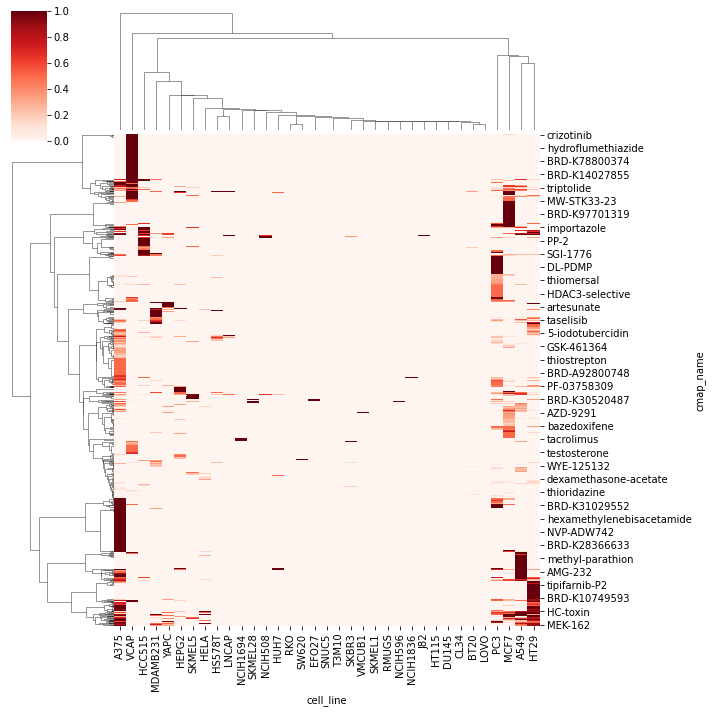

In [21]:
sns.clustermap(r2s_percent, cmap='Reds', method='ward')

# Figure 3A: shift ability of R-shifting compounds by dosage category 

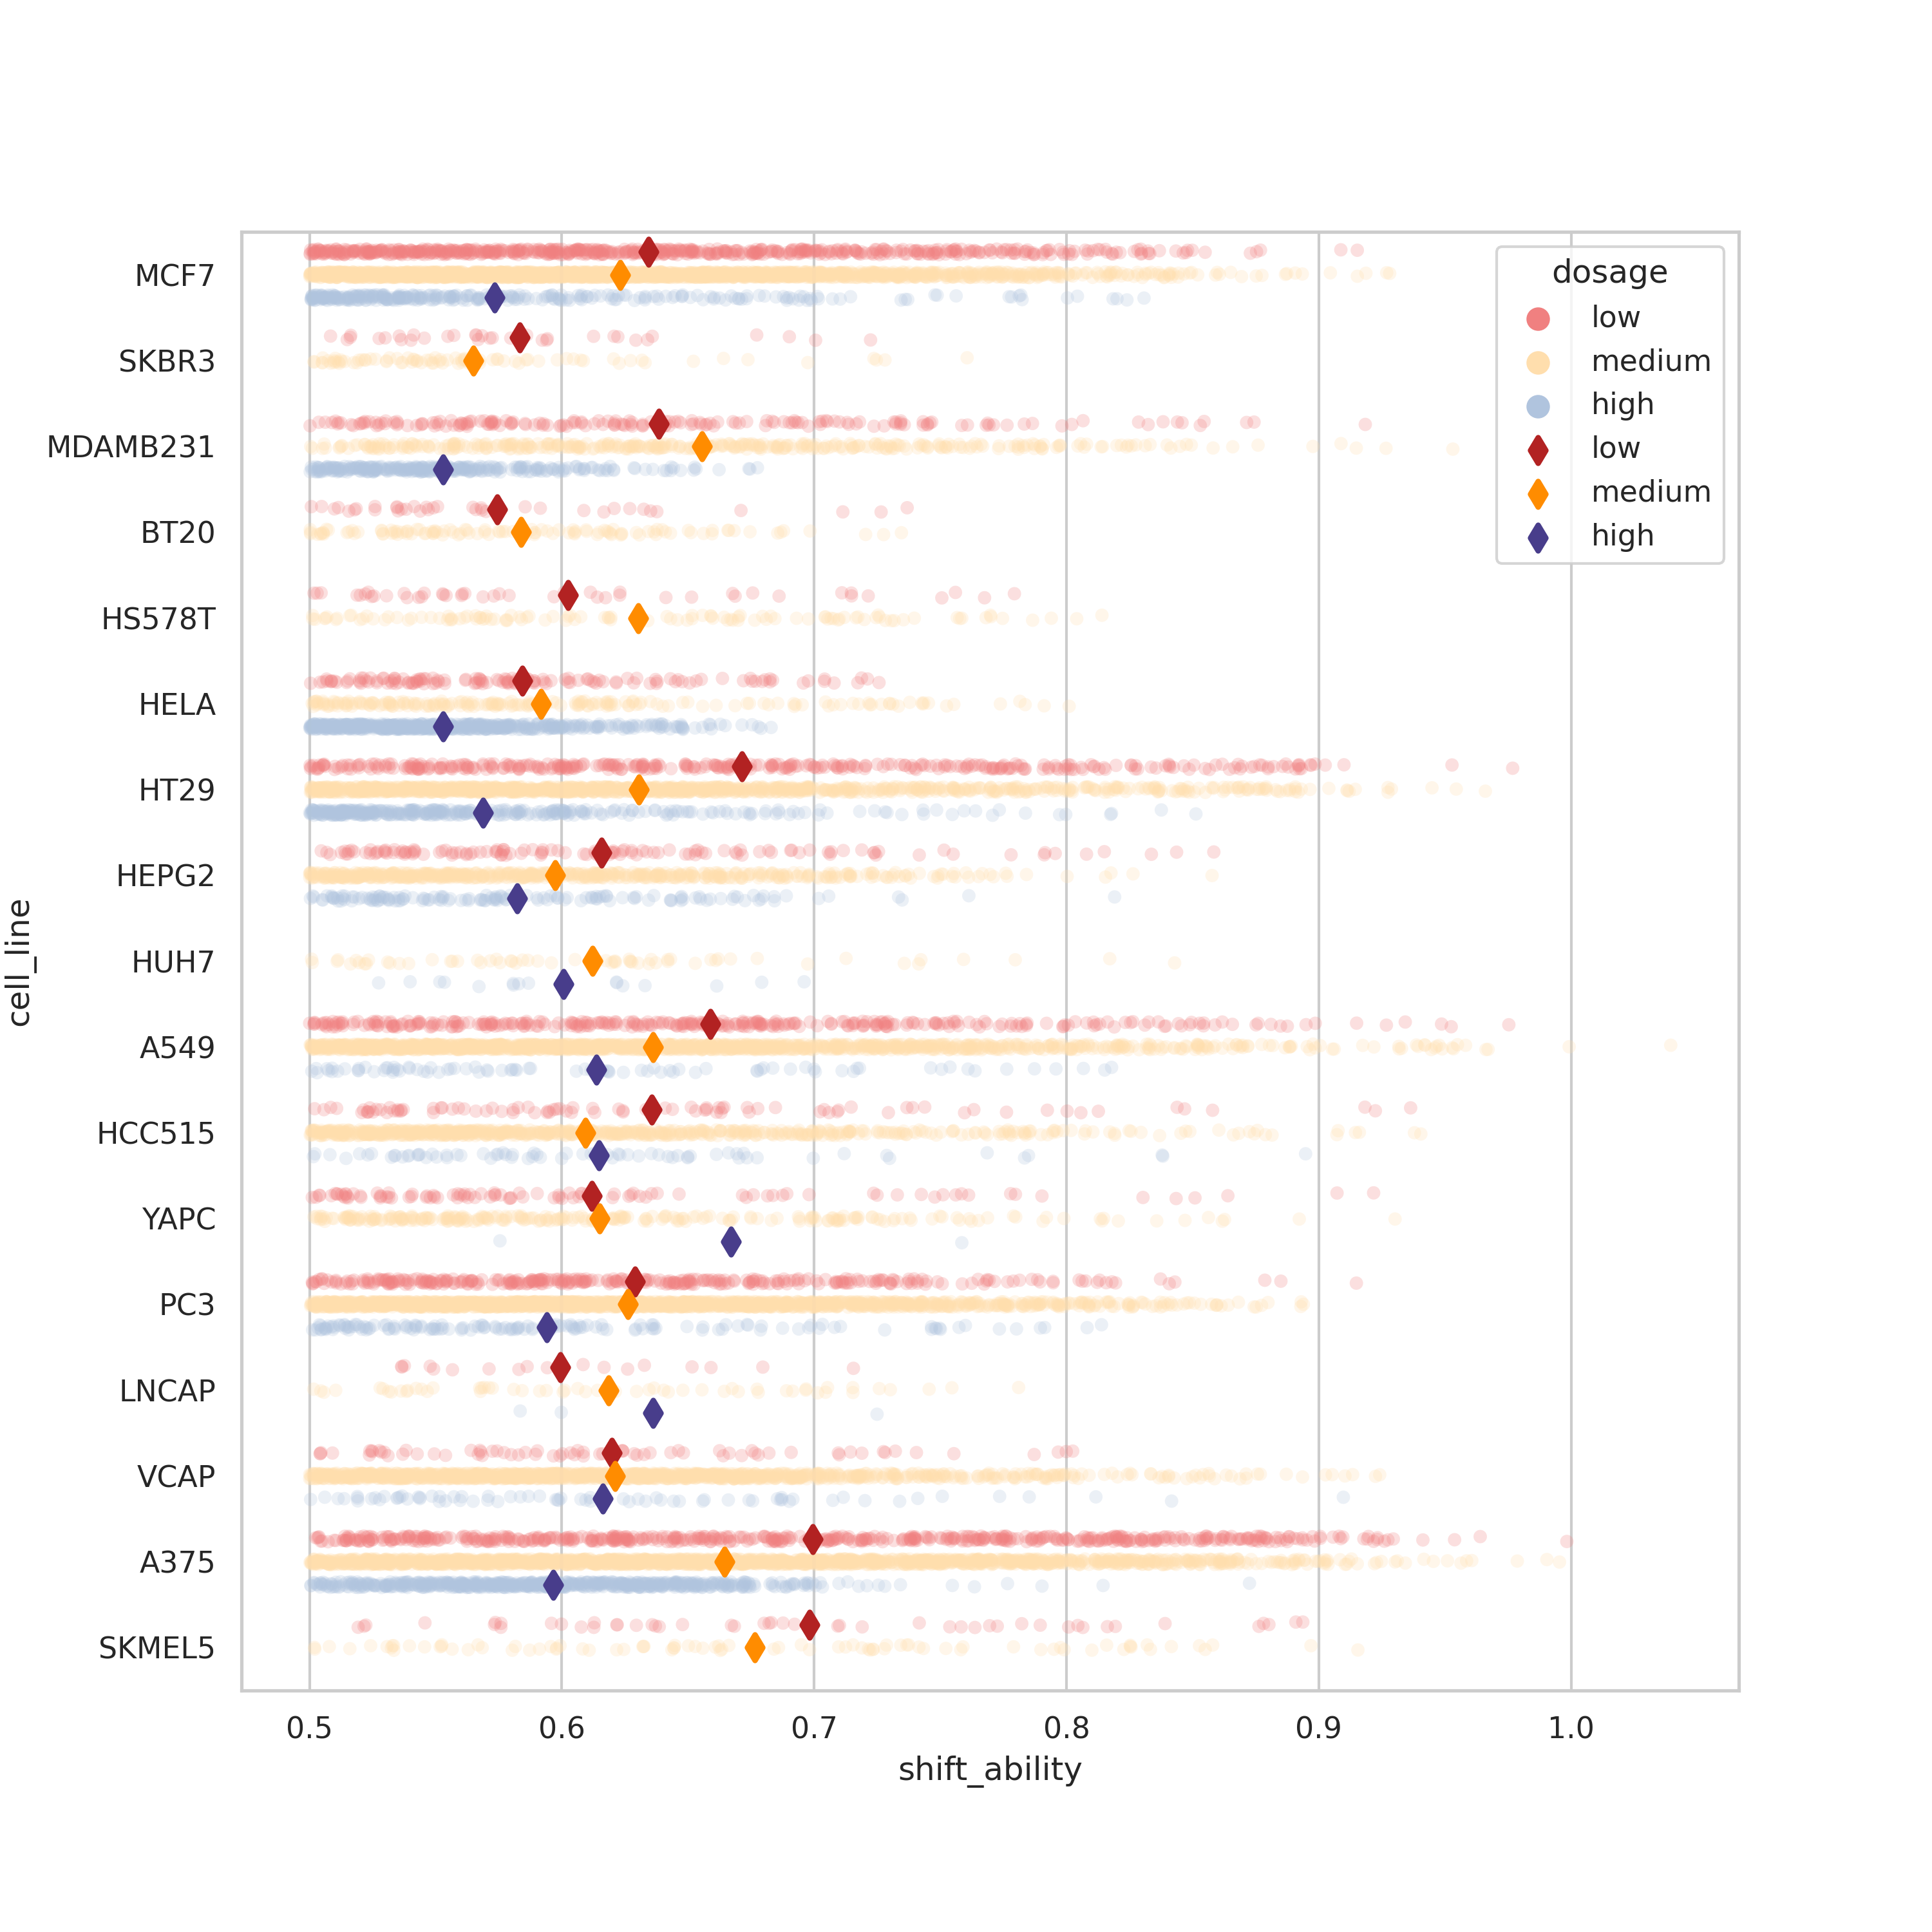

In [22]:
Image(filename=panel_home + 'dis_shift_ability_dosage.png', retina=True)

In [30]:
all_cp_shift

NREC_profile  REC_profile  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10           -0.440463     0.303870   
ERBB2002_J82_24H:BRD-K66175015:10              -0.327901     0.377128   
ERBB2002_5637_24H:BRD-K66175015:10             -0.313779     0.368062   
ERBB2001_VMCUB1_24H:BRD-K66175015:10           -0.277081     0.347362   
ERBB2002_J82_24H:BRD-K42805893:10              -0.266715    -0.307608   
...                                                  ...          ...   
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10       -0.154705    -0.176438   
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10     -0.185357    -0.269428   
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10        0.187616    -0.172240   
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10        0.223700    -0.251825   
CPC006_SNGM_6H:BRD-K01976263-003-04-5:0.63      0.303293    -0.347816   

                                                cmap_name  nearest_dose  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10             AZD-9291         10.00   
ERBB2002_J82_24H:BRD-K66175015:10                afatinib         10.00   
ERBB2002_5637_24H:BRD-K66175015:10               afatinib         10.00   
ERBB2001_VMCUB1_24H:BRD-K66175015:10             afatinib         10.00   
ERBB2002_J82_24H:BRD-K42805893:10                AZD-9291         10.00   
...                                                   ...           ...   
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10        auranofin         10.00   
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10     NSC-632839         10.00   
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10    BRD-A15079084         10.00   
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10    BRD-A28105619         10.00   
CPC006_SNGM_6H:BRD-K01976263-003-04-5:0.63        emetine          0.66   

                                           pert_idose  shift_ability  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10            10 uM       0.744333   
ERBB2002_J82_24H:BRD-K66175015:10               10 uM       0.705029   
ERBB2002_5637_24H:BRD-K66175015:10              10 uM       0.681841   
ERBB2001_VMCUB1_24H:BRD-K66175015:10            10 uM       0.624442   
ERBB2002_J82_24H:BRD-K42805893:10               10 uM      -0.040893   
...                                               ...            ...   
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10        10 uM      -0.021733   
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10      10 uM      -0.084071   
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10        10 uM      -0.359856   
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10        10 uM      -0.475525   
CPC006_SNGM_6H:BRD-K01976263-003-04-5:0.63    0.66 uM      -0.651109   

                                           cancer_type cell_line  
ERBB2001_VMCUB1_24H:BRD-K42805893:10              BLCA    VMCUB1  
ERBB2002_J82_24H:BRD-K66175015:10                 BLCA       J82  
ERBB2002_5637_24H:BRD-K66175015:10                BLCA      5637  
ERBB2001_VMCUB1_24H:BRD-K66175015:10              BLCA    VMCUB1  
ERBB2002_J82_24H:BRD-K42805893:10                 BLCA       J82  
...                                                ...       ...  
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10          UCEC      SNGM  
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10        UCEC    JHUEM2  
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10          UCEC      SNGM  
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10          UCEC      SNGM  
CPC006_SNGM_6H:BRD-K01976263-003-04-5:0.63        UCEC      SNGM  

[41321 rows x 8 columns]

In [31]:
cand_compound = all_cp_shift[all_cp_shift['shift_ability'] >= .3]

In [32]:
# add moa
cand_compound['MOA'] = 'Not specified'
for d in cand_compound.index:
    if cand_compound.loc[d, 'cmap_name'] in compound_info.index:
        cand_compound.at[d, 'MOA'] = compound_info.loc[cand_compound.loc[d, 'cmap_name'], 'moa']

<ipython-input-32-760273513bcb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cand_compound['MOA'] = 'Not specified'


/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/dyang-server/anaconda3/lib/python3.8/site-pack

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/dyang-server/anaconda3/lib/python3.8/site-pack

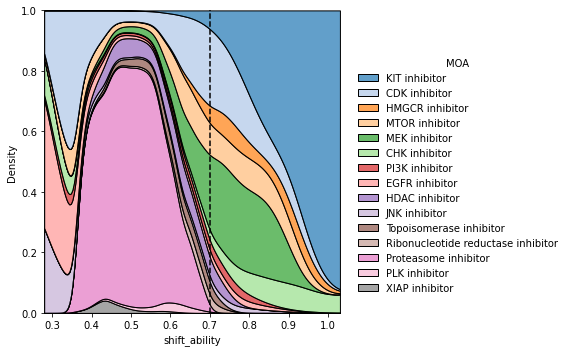

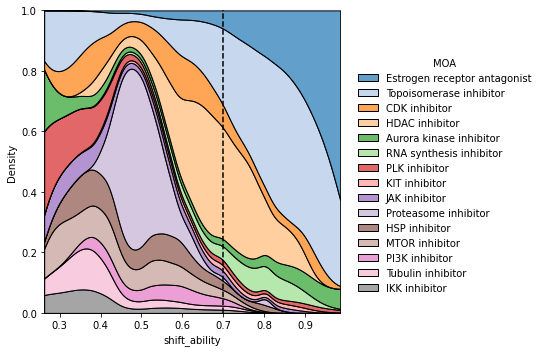

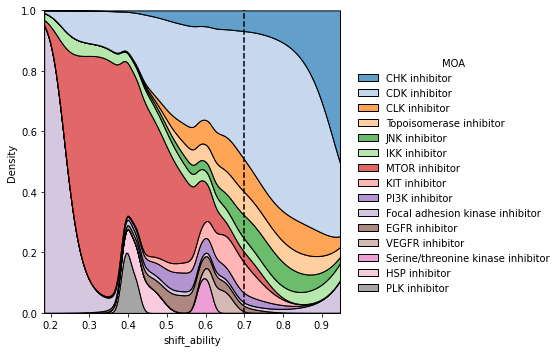

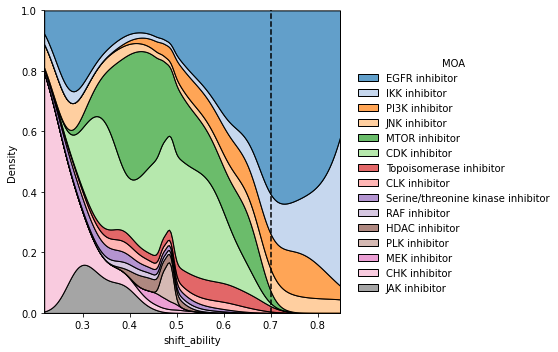

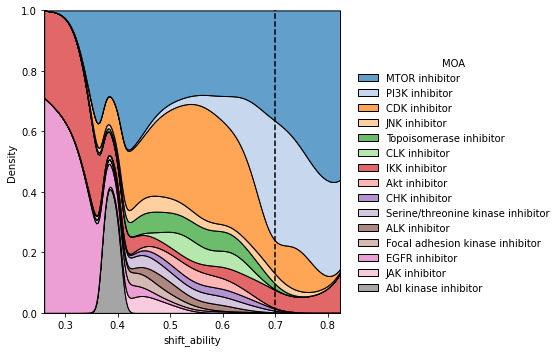

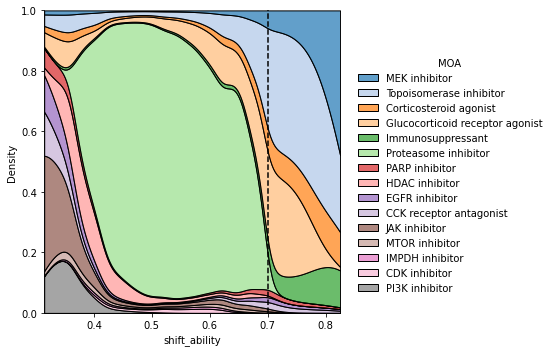

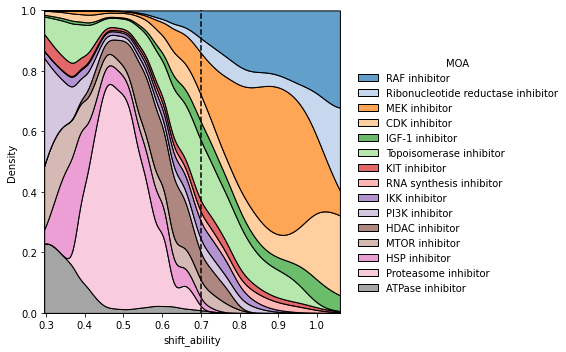

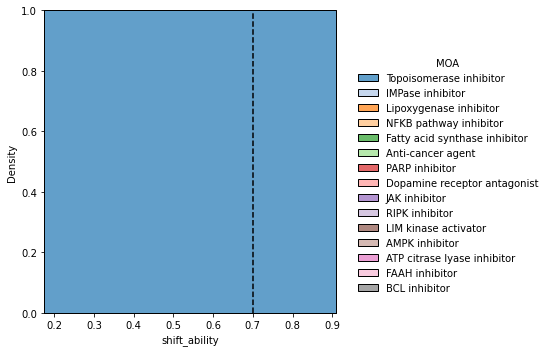

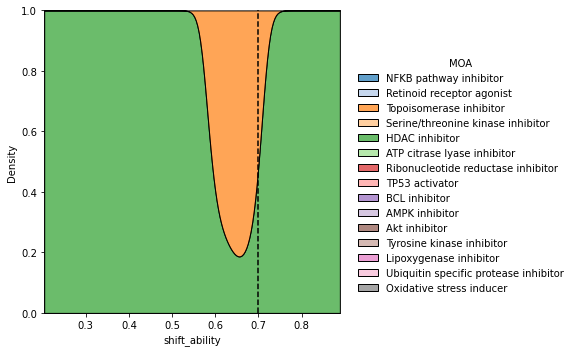

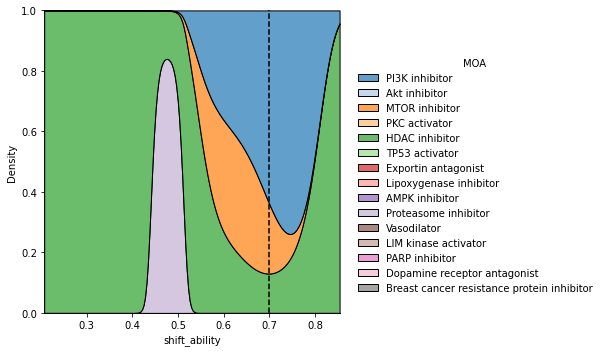

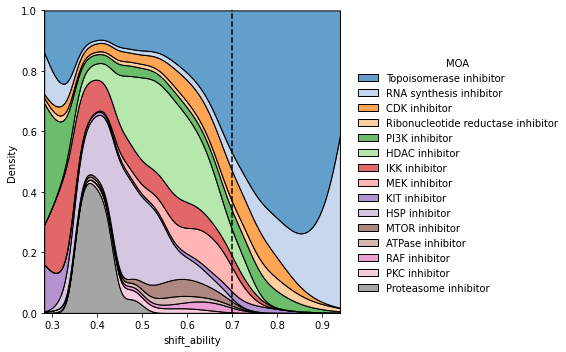

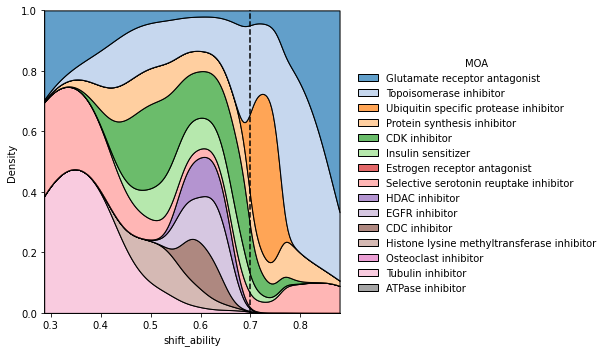

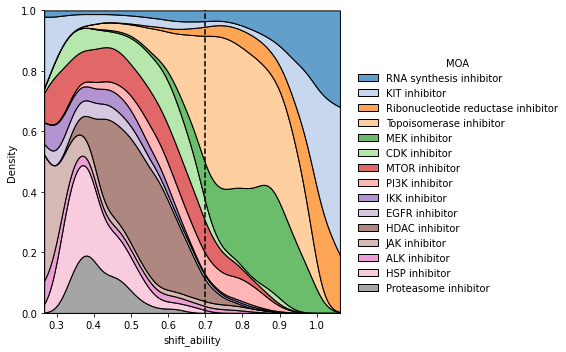

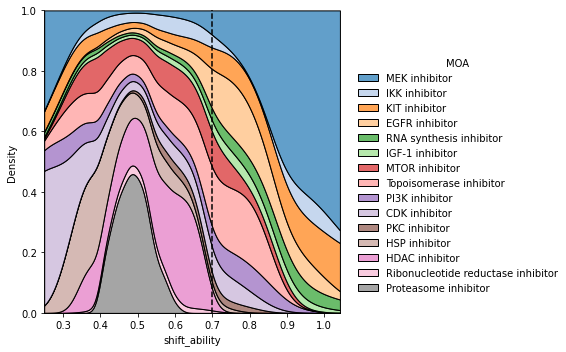

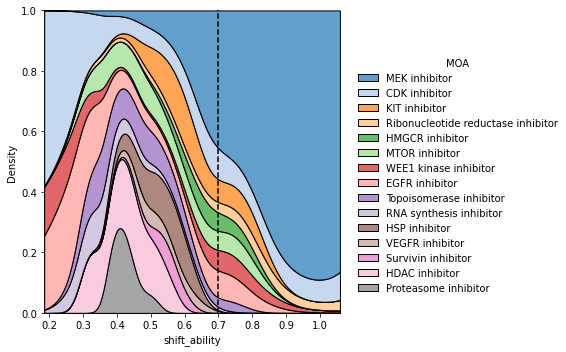

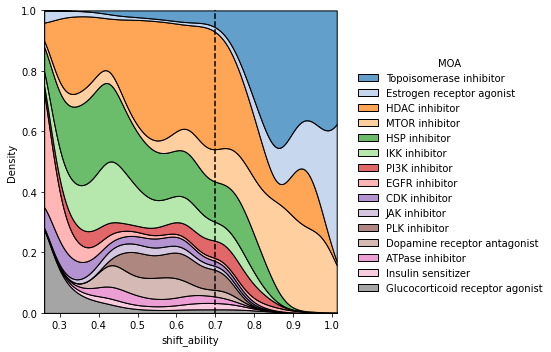

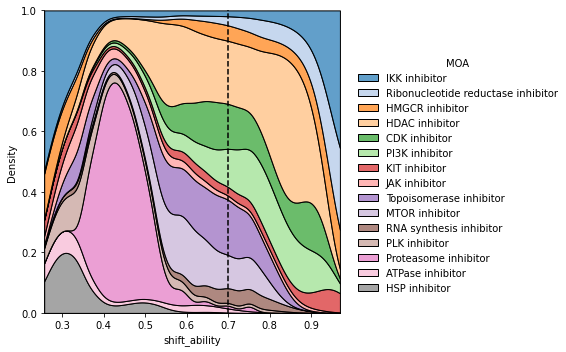

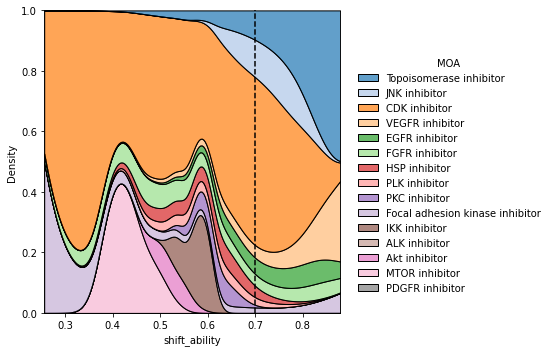

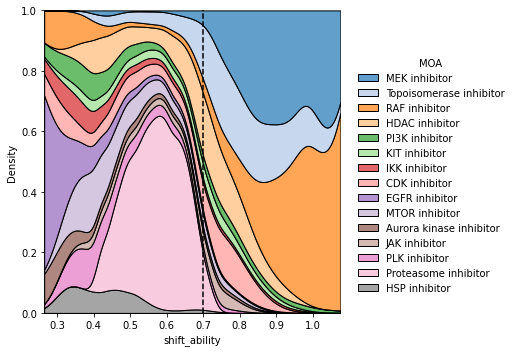

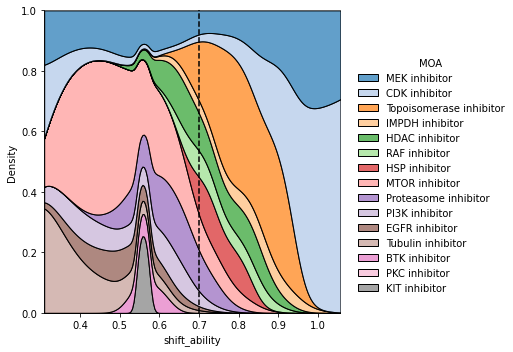

In [44]:
for cl in cand_compound['cell_line'].unique():
    tmp_cl = cand_compound[cand_compound['cell_line'] == cl]
    if len(tmp_cl['MOA'].unique()) >= 15:
        tmp_moa = tmp_cl['MOA'].value_counts()[:15].index
        sns.displot(x='shift_ability',
                    hue='MOA',
                    data=tmp_cl[tmp_cl['MOA'].isin(tmp_moa)],
                    multiple='fill',
                    kind='kde',
                    palette='tab20',
                    alpha=0.7)
        plt.axvline(x=.7, ls='--', c='k')
        fig = plt.gcf()
        fig.savefig(panel_home_new + cl + '_top15_moa.pdf', transparent=True)

# Figure 3B: Top R-shifting compounds shared by multiple cell lines

In [34]:
# top R-shifting is defined as shift ability >= 0.7 here, also termed as "significant shift"
top_rs_cp_shift = all_cp_shift[all_cp_shift['shift_ability'] >= .7]
top_rs_cp_shift.shape

(3983, 9)

In [35]:
# unique compound numbers
top_rs_cp_shift['cmap_name'].unique().shape

(780,)

In [36]:
# compound by cell lines
top_cp_cl = df(pd.crosstab(top_rs_cp_shift['cmap_name'], top_rs_cp_shift['cell_line']))

In [37]:
top_cp_cl

cell_line         A375  A549  BT20  CL34  DU145  EFO27  HCC515  HELA  HEPG2  \
cmap_name                                                                     
3-Cl-AHPC            0     2     0     0      0      0       0     0      2   
5-BDBD               1     0     0     0      0      0       0     0      0   
5-iodotubercidin     1     0     0     0      0      0       1     0      0   
7b-cis               2     0     0     0      0      0       0     0      0   
A-443654             1     0     0     0      0      0       0     0      0   
...                ...   ...   ...   ...    ...    ...     ...   ...    ...   
vorinostat          45     5     0     0      0      0       0     0      1   
voxtalisib           0     0     0     0      0      0       0     0      0   
withaferin-a         0     1     0     0      0      0       1     0      0   
wortmannin           2    16     0     0      0      0       2     0      3   
zileuton             0     0     0     0      0      0       0     0      0   

cell_line         HS578T  ...  SKBR3  SKMEL1  SKMEL28  SKMEL5  SNUC5  SW620  \
cmap_name                 ...                                                 
3-Cl-AHPC              0  ...      0       0        0       0      0      0   
5-BDBD                 0  ...      0       0        0       0      0      0   
5-iodotubercidin       0  ...      0       0        0       0      0      0   
7b-cis                 0  ...      0       0        0       0      0      0   
A-443654               1  ...      0       0        0       0      0      0   
...                  ...  ...    ...     ...      ...     ...    ...    ...   
vorinostat             0  ...      0       0        0       3      1      0   
voxtalisib             0  ...      0       0        0       0      0      0   
withaferin-a           1  ...      1       0        0       0      0      0   
wortmannin             0  ...      0       0        0       0      0      0   
zileuton               0  ...      0       0        0       0      0      0   

cell_line         T3M10  VCAP  VMCUB1  YAPC  
cmap_name                                    
3-Cl-AHPC             0     0       0     0  
5-BDBD                0     0       0     0  
5-iodotubercidin      0     0       0     0  
7b-cis                0     0       0     0  
A-443654              0     0       0     0  
...                 ...   ...     ...   ...  
vorinostat            1    15       0     0  
voxtalisib            0     0       0     0  
withaferin-a          0     4       0     0  
wortmannin            0     3       0     0  
zileuton              0     1       0     0  

[780 rows x 35 columns]

In [38]:
# dichotomized to 0 and 1: 1 means at least at one dosage, the compound can induce significant shift
top_cp_cl_count = top_cp_cl[top_cp_cl == 0].fillna(1)

In [39]:
# distribution of total number of sig-R-shifting compounds across cell lines
top_cp_cl_count_cell = df(top_cp_cl_count.sum(axis=0)).rename(columns={0: 'number of sig-R-shifting compound'})
top_cp_cl_count_cell

number of sig-R-shifting compound
cell_line                                   
A375                                   325.0
A549                                   145.0
BT20                                     6.0
CL34                                     1.0
DU145                                    1.0
EFO27                                    2.0
HCC515                                  72.0
HELA                                    24.0
HEPG2                                   43.0
HS578T                                  18.0
HT115                                    1.0
HT29                                   156.0
HUH7                                     5.0
J82                                      1.0
LNCAP                                    9.0
LOVO                                     1.0
MCF7                                   210.0
MDAMB231                                68.0
NCIH1694                                 5.0
NCIH1836                                 1.0
NCIH508                                  5.0
NCIH596                                  1.0
PC3                                    212.0
RKO                                      1.0
RMUGS                                    1.0
SKBR3                                    6.0
SKMEL1                                   1.0
SKMEL28                                  5.0
SKMEL5                                  25.0
SNUC5                                    1.0
SW620                                    2.0
T3M10                                    1.0
VCAP                                   157.0
VMCUB1                                   1.0
YAPC                                    36.0

In [40]:
# distribution of total number of tested compounds across cell lines
tested_cp_cl = df(pd.crosstab(all_cp_shift['cmap_name'], all_cp_shift['cell_line']))
tested_cl_count = tested_cp_cl[tested_cp_cl == 0].fillna(1)
tested_cp_count_cell = df(tested_cl_count.sum(axis=0)).rename(columns={0: 'number of total compound'})
tested_cp_count_cell = tested_cp_count_cell[tested_cp_count_cell.index.isin(top_cp_cl_count_cell.index)]
tested_cp_count_cell

number of total compound
cell_line                          
A375                         1350.0
A549                         1102.0
BT20                           79.0
CL34                           11.0
DU145                           1.0
EFO27                          19.0
HCC515                        803.0
HELA                          509.0
HEPG2                         808.0
HS578T                         89.0
HT115                          19.0
HT29                         1151.0
HUH7                           97.0
J82                             2.0
LNCAP                          41.0
LOVO                           38.0
MCF7                         1634.0
MDAMB231                      244.0
NCIH1694                       14.0
NCIH1836                        7.0
NCIH508                        16.0
NCIH596                        32.0
PC3                          1521.0
RKO                            27.0
RMUGS                           7.0
SKBR3                          93.0
SKMEL1                          7.0
SKMEL28                        13.0
SKMEL5                         70.0
SNUC5                          16.0
SW620                          27.0
T3M10                          10.0
VCAP                         1362.0
VMCUB1                          2.0
YAPC                          402.0

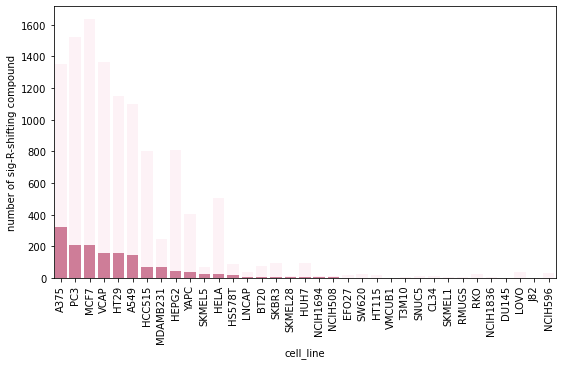

In [41]:
# bar plot showing the number of hits
plt.figure(figsize=(9, 5))

tmp_order = top_cp_cl_count_cell.sort_values(by='number of sig-R-shifting compound', ascending=False).index

sns.barplot(x=tested_cp_count_cell.index,
            y='number of total compound',
            data=tested_cp_count_cell,
            color='lavenderblush',
            order=tmp_order)

sns.barplot(x=top_cp_cl_count_cell.index,
            y='number of sig-R-shifting compound',
            data=top_cp_cl_count_cell,
            color='palevioletred',
            order=tmp_order)

plt.xticks(rotation=90)
fig = plt.gcf()
fig.savefig(panel_home + 'number_of_sigR-shifting_by_cell_line.png', dpi=300, transparent=True)
fig.savefig(panel_home + 'number_of_sigR-shifting_by_cell_line.pdf', transparent=True)

In [42]:
# distribution of sig-R-shifting compounds across cell lines
top_cp_cl_count_compound = df(top_cp_cl_count.sum(axis=1)).rename(columns={0: 'number of cell lines'})
top_cp_cl_count_compound

number of cell lines
cmap_name                             
3-Cl-AHPC                          4.0
5-BDBD                             1.0
5-iodotubercidin                   3.0
7b-cis                             1.0
A-443654                           3.0
...                                ...
vorinostat                        10.0
voxtalisib                         2.0
withaferin-a                       8.0
wortmannin                         6.0
zileuton                           1.0

[780 rows x 1 columns]

In [43]:
# total cell lines for each compound
tested_cp_count_compound = df(tested_cl_count[top_cp_cl.columns].sum(axis=1)).rename(columns={0: 'number of cell lines'})
tested_cp_count_compound = tested_cp_count_compound[tested_cp_count_compound.index.isin(top_cp_cl_count_compound.index)]
tested_cp_count_compound

number of cell lines
cmap_name                             
3-Cl-AHPC                          7.0
5-BDBD                             1.0
5-iodotubercidin                   7.0
7b-cis                             4.0
A-443654                          13.0
...                                ...
vorinostat                        24.0
voxtalisib                         8.0
withaferin-a                      13.0
wortmannin                        10.0
zileuton                           1.0

[780 rows x 1 columns]

In [44]:
# compound have multiple hits: 17 cell lines, 1/3 coverage -> equal or more than 6 cell lines
multi_hit_compound = top_cp_cl_count_compound[top_cp_cl_count_compound['number of cell lines'] >= 6]
multi_hit_compound = multi_hit_compound.sort_values(by='number of cell lines', ascending=False)
multi_hit_compound

number of cell lines
cmap_name                                  
mitoxantrone                           12.0
doxorubicin                            10.0
vorinostat                             10.0
BRD-A19037878                           9.0
gemcitabine                             8.0
alvocidib                               8.0
AZD-7762                                8.0
SN-38                                   8.0
sirolimus                               8.0
CGP-60474                               8.0
withaferin-a                            8.0
clofarabine                             7.0
foretinib                               7.0
pitavastatin                            7.0
midostaurin                             7.0
daunorubicin                            7.0
cytarabine                              7.0
selumetinib                             7.0
dasatinib                               7.0
aphidicolin                             7.0
camptothecin                            7.0
neratinib                               7.0
WZ-4-145                                7.0
triptolide                              7.0
valrubicin                              7.0
PD-0325901                              7.0
NVP-TAE684                              7.0
BRD-K63750851                           7.0
palbociclib                             7.0
taselisib                               6.0
topotecan                               6.0
trametinib                              6.0
pralatrexate                            6.0
AZ-628                                  6.0
mycophenolate-mofetil                   6.0
irinotecan                              6.0
epirubicin                              6.0
cobimetinib                             6.0
cabozantinib                            6.0
brequinar                               6.0
WZ-3105                                 6.0
Ro-4987655                              6.0
PHA-793887                              6.0
PF-03758309                             6.0
ENMD-2076                               6.0
BVD-523                                 6.0
wortmannin                              6.0

In [45]:
top_cp_cl_count.loc['PF-03758309', :]

cell_line
A375        1.0
A549        0.0
BT20        0.0
CL34        0.0
DU145       0.0
EFO27       0.0
HCC515      1.0
HELA        0.0
HEPG2       0.0
HS578T      0.0
HT115       0.0
HT29        1.0
HUH7        0.0
J82         0.0
LNCAP       0.0
LOVO        0.0
MCF7        1.0
MDAMB231    0.0
NCIH1694    0.0
NCIH1836    0.0
NCIH508     0.0
NCIH596     0.0
PC3         1.0
RKO         0.0
RMUGS       0.0
SKBR3       0.0
SKMEL1      0.0
SKMEL28     0.0
SKMEL5      0.0
SNUC5       0.0
SW620       0.0
T3M10       0.0
VCAP        0.0
VMCUB1      0.0
YAPC        1.0
Name: PF-03758309, dtype: float64

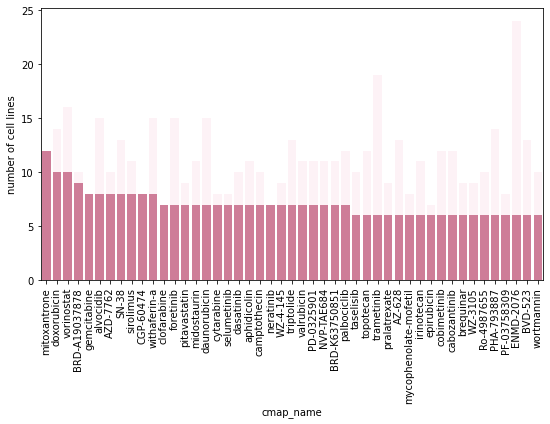

In [34]:
# bar plot showing the number of hits
plt.figure(figsize=(9, 5))

tmp_order = multi_hit_compound.index

sns.barplot(x=multi_hit_compound.index,
            y='number of cell lines',
            data=tested_cp_count_compound[tested_cp_count_compound.index.isin(multi_hit_compound.index)],
            color='lavenderblush',
            order=tmp_order)

sns.barplot(x=multi_hit_compound.index,
            y='number of cell lines',
            data=multi_hit_compound,
            color='palevioletred',
            order=tmp_order)

plt.xticks(rotation=90)
fig = plt.gcf()
fig.savefig(panel_home + 'number_of_sigR_cell_line_by_compound.png', dpi=300, transparent=True)
fig.savefig(panel_home + 'number_of_sigR_cell_line_by_compound.pdf', transparent=True)

In [46]:
multi_hit_compound.index.shape

(47,)

In [47]:
multi_hit_compound['moa'] = compound_info['moa']

In [48]:
multi_hit_compound.to_csv(panel_home + 'multi_hit_compound_moa_sorted.csv', sep=',')

In [35]:
multi_hit_compound['moa'].value_counts()

Topoisomerase inhibitor                   7
MEK inhibitor                             4
CDK inhibitor                             4
PI3K inhibitor                            2
Ribonucleotide reductase inhibitor        2
VEGFR inhibitor                           2
KIT inhibitor                             2
IKK inhibitor                             1
Dihydrofolate reductase inhibitor         1
RAF inhibitor                             1
RNA synthesis inhibitor                   1
HDAC inhibitor                            1
DNA inhibitor                             1
Ribonucleoside reductase inhibitor        1
P21 activated kinase inhibitor            1
EGFR inhibitor                            1
Dihydroorotate dehydrogenase inhibitor    1
FLT3 inhibitor                            1
HMGCR inhibitor                           1
ALK inhibitor                             1
IMPDH inhibitor                           1
CHK inhibitor                             1
MTOR inhibitor                  

In [36]:
r2s_percent_sub = r2s_percent[r2s_percent.index.isin(multi_hit_compound.index)]
r2s_percent_sub = r2s_percent_sub[r2s_percent_sub > 0].dropna(axis=1, how='all').fillna(0)

In [37]:
r2s_multi_order = multi_hit_compound.index

In [38]:
r2s_percent_sub.columns

Index(['A375', 'A549', 'BT20', 'DU145', 'HCC515', 'HELA', 'HEPG2', 'HS578T',
       'HT29', 'HUH7', 'LNCAP', 'MCF7', 'MDAMB231', 'NCIH508', 'NCIH596',
       'PC3', 'RKO', 'SKBR3', 'SKMEL28', 'SKMEL5', 'SNUC5', 'SW620', 'T3M10',
       'VCAP', 'YAPC'],
      dtype='object', name='cell_line')

In [39]:
cell_annot = df(r2s_cp_shift[r2s_cp_shift['cell_line'].isin(r2s_percent_sub.columns)].set_index('cell_line')['cancer_type'])
cell_annot = cell_annot.groupby(level=0).first()

In [40]:
r2s_cell_order = []
for c in cell_annot['cancer_type'].unique():
    r2s_cell_order.extend(cell_annot[cell_annot['cancer_type'] == c].index)

In [41]:
cell_annot

cancer_type
cell_line            
A375             SKCM
A549             LUNG
BT20             BRCA
DU145            PRAD
HCC515           LUNG
HELA             CESC
HEPG2            LIHC
HS578T           BRCA
HT29              CRC
HUH7             LIHC
LNCAP            PRAD
MCF7             BRCA
MDAMB231         BRCA
NCIH508           CRC
NCIH596          LUNG
PC3              PRAD
RKO               CRC
SKBR3            BRCA
SKMEL28          SKCM
SKMEL5           SKCM
SNUC5             CRC
SW620             CRC
T3M10            LUNG
VCAP             PRAD
YAPC             PAAD

BLCA


<ipython-input-70-c2d295d7d75e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_ct['MoA'] = 'unclassified'


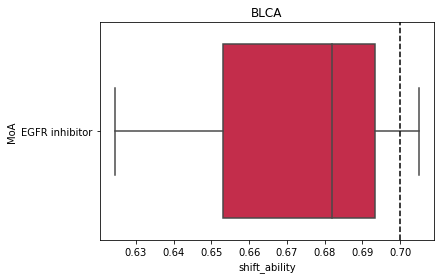

BRCA


<ipython-input-70-c2d295d7d75e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_ct['MoA'] = 'unclassified'


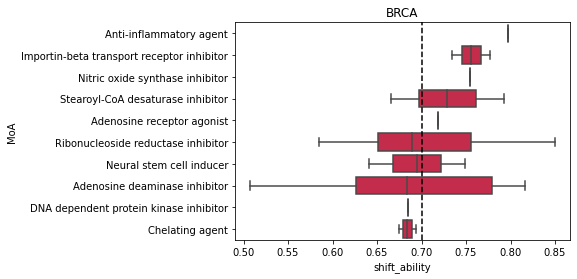

CESC


<ipython-input-70-c2d295d7d75e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_ct['MoA'] = 'unclassified'


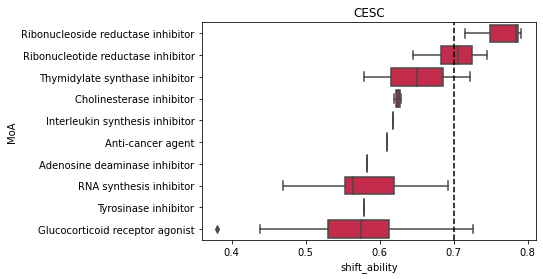

<ipython-input-70-c2d295d7d75e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_ct['MoA'] = 'unclassified'


CRC


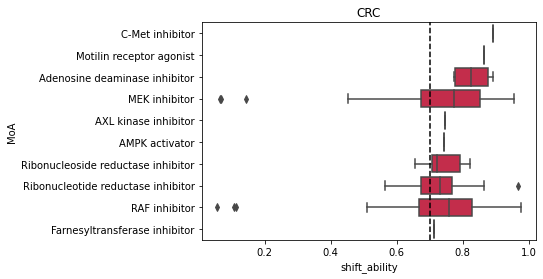

LIHC


<ipython-input-70-c2d295d7d75e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_ct['MoA'] = 'unclassified'


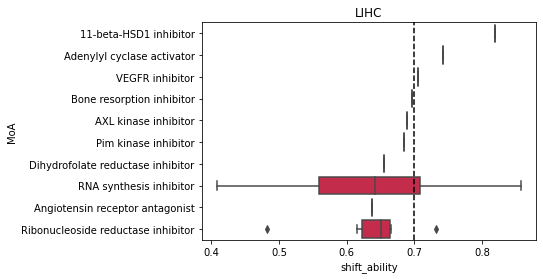

LUNG


<ipython-input-70-c2d295d7d75e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_ct['MoA'] = 'unclassified'


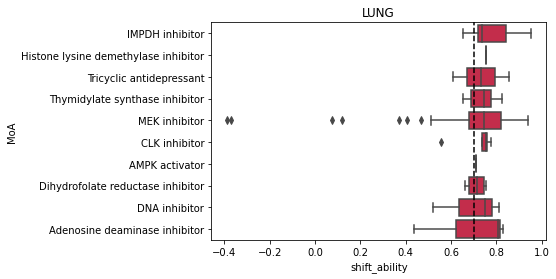

OV


<ipython-input-70-c2d295d7d75e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_ct['MoA'] = 'unclassified'


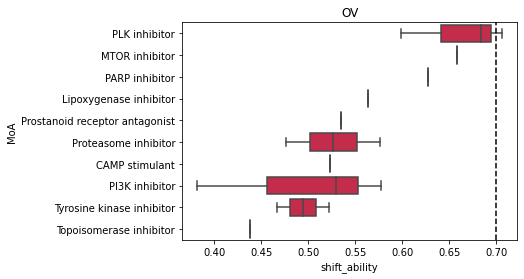

PAAD


<ipython-input-70-c2d295d7d75e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_ct['MoA'] = 'unclassified'


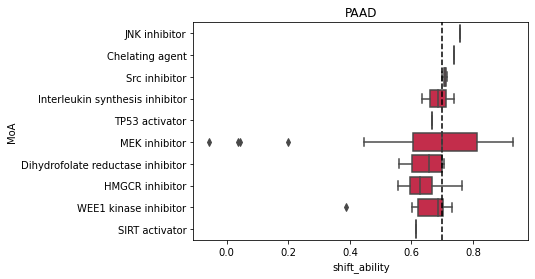

PRAD


<ipython-input-70-c2d295d7d75e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_ct['MoA'] = 'unclassified'


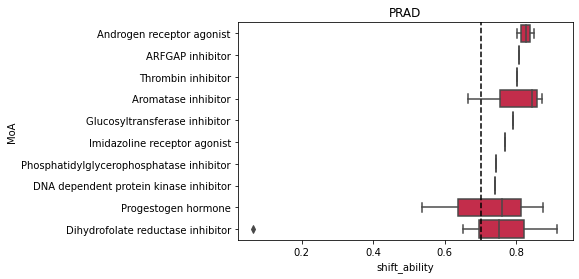

SKCM


<ipython-input-70-c2d295d7d75e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_ct['MoA'] = 'unclassified'


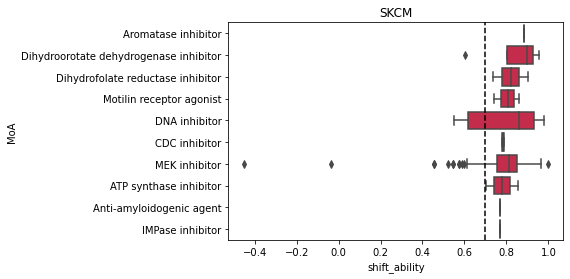

STAD


<ipython-input-70-c2d295d7d75e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_ct['MoA'] = 'unclassified'


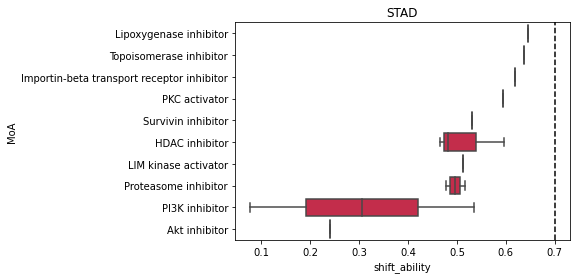

UCEC


<ipython-input-70-c2d295d7d75e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_ct['MoA'] = 'unclassified'


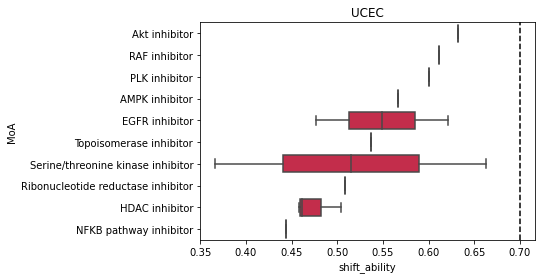

In [70]:
# merge MoAs from same lineage
for ct in all_cp_shift['cancer_type'].unique():
    print(ct)
    tmp_ct = all_cp_shift[all_cp_shift['cancer_type'] == ct]
    tmp_ct['MoA'] = 'unclassified'
    
    # add MoA
    for i in tmp_ct.index:
        if tmp_ct.loc[i, 'cmap_name'] in compound_info.index:
            tmp_ct.at[i, 'MoA'] = compound_info.loc[tmp_ct.loc[i, 'cmap_name'], 'moa']
    
    # sort shift by MoA
    tmp_shift_moa = df(tmp_ct.groupby('MoA').mean()['shift_ability']).sort_values(by='shift_ability', ascending=False)
    
    # boxplot
    sns.boxplot(x='shift_ability', y='MoA', order=tmp_shift_moa.head(10).index, data=tmp_ct, color='crimson')
    plt.axvline(x=.7, ls='--', c='k')
    plt.title(ct)
    plt.show()

In [52]:
all_cp_shift

NREC_profile  REC_profile  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10           -0.440463     0.303870   
ERBB2002_J82_24H:BRD-K66175015:10              -0.327901     0.377128   
ERBB2002_5637_24H:BRD-K66175015:10             -0.313779     0.368062   
ERBB2001_VMCUB1_24H:BRD-K66175015:10           -0.277081     0.347362   
ERBB2002_J82_24H:BRD-K42805893:10              -0.266715    -0.307608   
...                                                  ...          ...   
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10       -0.154705    -0.176438   
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10     -0.185357    -0.269428   
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10        0.187616    -0.172240   
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10        0.223700    -0.251825   
CPC006_SNGM_6H:BRD-K01976263-003-04-5:0.63      0.303293    -0.347816   

                                                cmap_name  nearest_dose  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10             AZD-9291         10.00   
ERBB2002_J82_24H:BRD-K66175015:10                afatinib         10.00   
ERBB2002_5637_24H:BRD-K66175015:10               afatinib         10.00   
ERBB2001_VMCUB1_24H:BRD-K66175015:10             afatinib         10.00   
ERBB2002_J82_24H:BRD-K42805893:10                AZD-9291         10.00   
...                                                   ...           ...   
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10        auranofin         10.00   
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10     NSC-632839         10.00   
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10    BRD-A15079084         10.00   
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10    BRD-A28105619         10.00   
CPC006_SNGM_6H:BRD-K01976263-003-04-5:0.63        emetine          0.66   

                                           pert_idose  shift_ability  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10            10 uM       0.744333   
ERBB2002_J82_24H:BRD-K66175015:10               10 uM       0.705029   
ERBB2002_5637_24H:BRD-K66175015:10              10 uM       0.681841   
ERBB2001_VMCUB1_24H:BRD-K66175015:10            10 uM       0.624442   
ERBB2002_J82_24H:BRD-K42805893:10               10 uM      -0.040893   
...                                               ...            ...   
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10        10 uM      -0.021733   
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10      10 uM      -0.084071   
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10        10 uM      -0.359856   
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10        10 uM      -0.475525   
CPC006_SNGM_6H:BRD-K01976263-003-04-5:0.63    0.66 uM      -0.651109   

                                           cancer_type cell_line  
ERBB2001_VMCUB1_24H:BRD-K42805893:10              BLCA    VMCUB1  
ERBB2002_J82_24H:BRD-K66175015:10                 BLCA       J82  
ERBB2002_5637_24H:BRD-K66175015:10                BLCA      5637  
ERBB2001_VMCUB1_24H:BRD-K66175015:10              BLCA    VMCUB1  
ERBB2002_J82_24H:BRD-K42805893:10                 BLCA       J82  
...                                                ...       ...  
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10          UCEC      SNGM  
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10        UCEC    JHUEM2  
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10          UCEC      SNGM  
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10          UCEC      SNGM  
CPC006_SNGM_6H:BRD-K01976263-003-04-5:0.63        UCEC      SNGM  

[41321 rows x 8 columns]

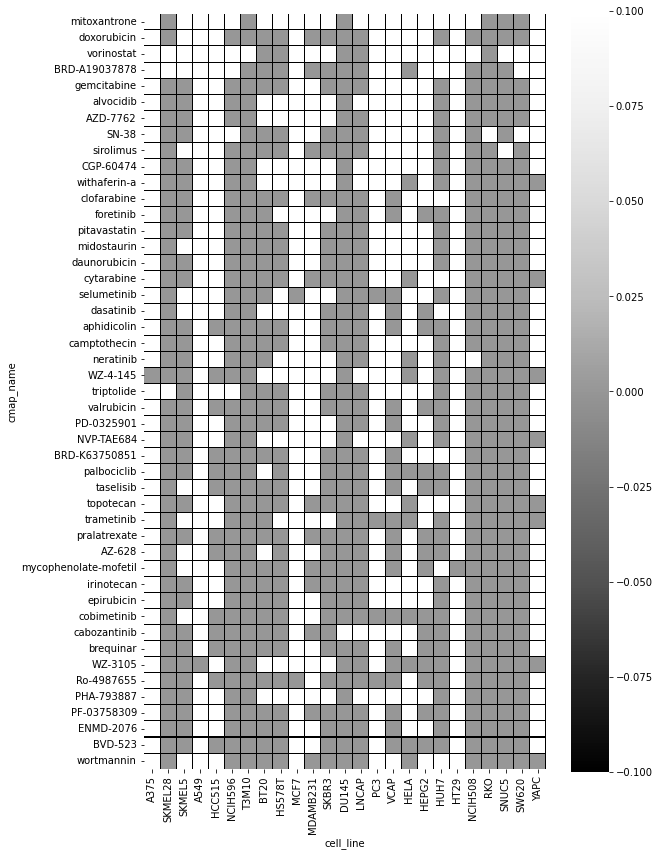

In [89]:
# not tested
r2s_not_tested = r2s_count[r2s_count == 0]
plt.figure(figsize=(9, 14))
sns.heatmap(r2s_not_tested.loc[r2s_multi_order, r2s_cell_order].fillna(1),
            linecolor='k', square=True, linewidths=0.01, vmin=-.1, vmax=.1, cmap='Greys_r')
fig = plt.gcf()
fig.savefig(panel_home + 'r2s_not_tested.pdf', transparent=True)

<AxesSubplot:xlabel='cell_line', ylabel='cmap_name'>

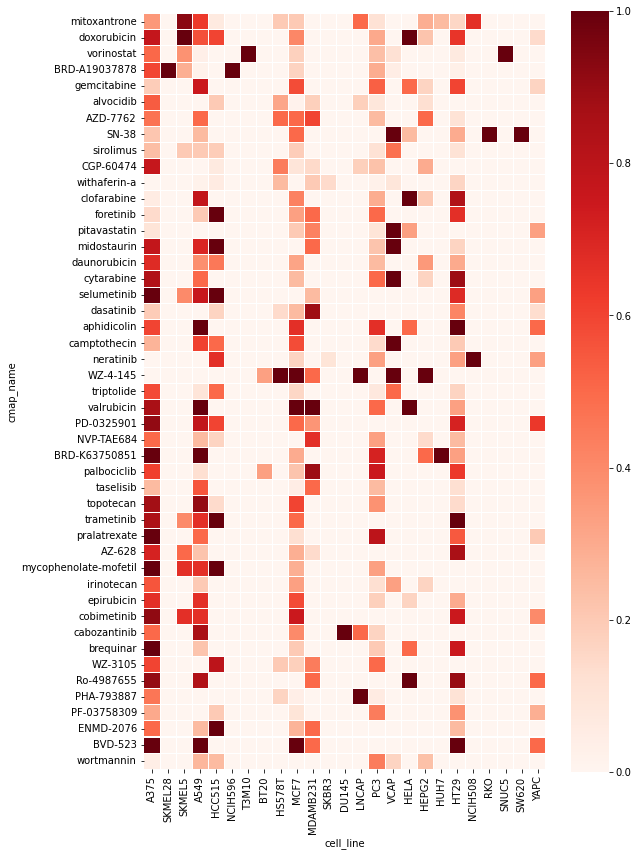

In [83]:
plt.figure(figsize=(9, 14))
sns.heatmap(r2s_percent_sub.loc[r2s_multi_order, r2s_cell_order], square=True, linewidths=0.01, cmap='Reds')

In [91]:
r2s_multi_order.shape

(47,)

In [179]:
def petal_plot(percent_matrix, figsize, path=None):
    '''
    Visualize the percentage by pie chart matrix 
    '''
    location = {}
    j = 1
    for ctype in percent_matrix.columns:
        location[ctype] = df(index=percent_matrix.index, columns=['x', 'y'])
        location[ctype]['percentage'] = percent_matrix[ctype]

        i = 1
        for t in location[ctype].index:
            location[ctype].at[t, 'y'] = i - .5
            location[ctype].at[t, 'x'] = j - .5
            i += 1
        j += 1

    # collapse all subframe to one
    mergeIndex = []
    for c in location.keys():
        mergeIndex.extend([c + '~' + x for x in location[c].index])
    mergeLoc = df(index=mergeIndex, columns=['x', 'y', 'fdr', 'corr'])
    for c in location.keys():
        for t in percent_matrix.index:
            mergeLoc.at[c + '~' + t, 'x'] = location[c].loc[t, 'x']
            mergeLoc.at[c + '~' + t, 'y'] = location[c].loc[t, 'y']
            mergeLoc.at[c + '~' + t, 'percentage'] = location[c].loc[t, 'percentage']

            
    def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
        assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'

        markers = []
        previous = 0
        # calculate the points of the pie pieces
        for color, ratio in zip(colors, ratios):
            this = 2 * np.pi * ratio + previous
            x  = [0] + np.cos(np.linspace(previous, this, 10)).tolist() + [0]
            y  = [0] + np.sin(np.linspace(previous, this, 10)).tolist() + [0]
            xy = np.column_stack([x, y])
            previous = this
            markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

        # scatter each of the pie pieces to create pies
        for marker in markers:
            ax.scatter(xs, ys, **marker)

    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, aspect='equal')
    sns.heatmap(percent_matrix[percent_matrix > 1], cmap='Greys_r',
                square=True, linewidths=0.01, linecolor='k',
                xticklabels=True, yticklabels=True)

    for c in percent_matrix.columns:
        for t in percent_matrix.index:
            if mergeLoc.loc[c + '~' + t, 'percentage'] != 0:
                drawPieMarker(ratios=[1 - mergeLoc.loc[c + '~' + t, 'percentage'], mergeLoc.loc[c + '~' + t, 'percentage']],
                              xs=mergeLoc.loc[c + '~' + t, 'x'],
                              ys=mergeLoc.loc[c + '~' + t, 'y'],
                              colors=['white', 'crimson'],
                              sizes=100, ax=ax) 
            
    '''        
    ax.scatter(
        x=mergeLoc['x'], y=mergeLoc['y'],
        s=10,
        color='k',
        )
    
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    '''
    plt.subplots_adjust(left=0.1)
    plt.tight_layout()
    if path != None:
        fig = plt.gcf()
        fig.savefig(path, transparent=True)
    plt.show()

    return

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


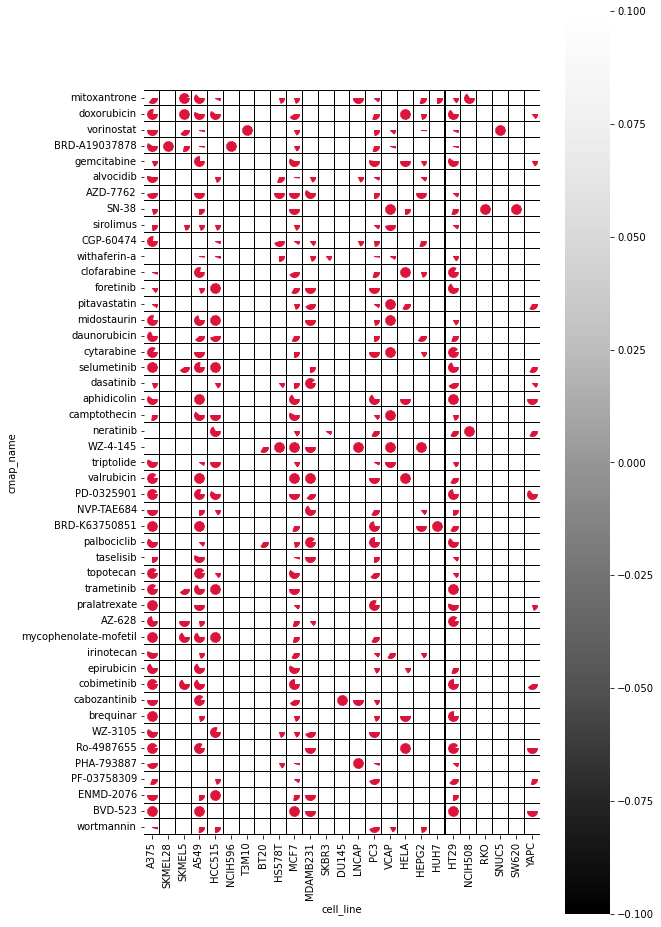

In [181]:
petal_plot(percent_matrix=r2s_percent_sub.loc[r2s_multi_order, r2s_cell_order], figsize=(9, 14), path=panel_home + 'petal_plot.pdf')

# Figure 3C-3F: case study of sig-R-shifting with multi-hits?

In [35]:
# mitoxantrone, doxorubicin, vorinostat, gemcitabine?

In [36]:
case_hash = {}
for d in ['mitoxantrone', 'doxorubicin', 'vorinostat', 'gemcitabine']:
    case_hash[d] = top_rs_cp_shift[top_rs_cp_shift['cmap_name'] == d]
    print(case_hash[d]['cell_line'].unique().shape)

(11,)
(10,)
(8,)
(8,)


In [37]:
# read expression matrix of given compound
def compound_cmap_expr(compound_name, compound_sig_matrix):
    tmp_list = []
    for ct in compound_sig_matrix['cancer_type'].unique():
        tmp_sig = compound_sig_matrix[compound_sig_matrix['cancer_type'] == ct].index
        tmp_ct_lv5 = pd.read_csv(cmap_home + ct + '/CMAP2020_lv5_trt_cp_merged.csv',
                                 header=0, index_col=0, sep=',')
        tmp_ct_lv5 = tmp_ct_lv5[tmp_sig]
        tmp_list.append(tmp_ct_lv5)
    tmp_merge = pd.concat(tmp_list, axis=1)
    return tmp_merge

In [38]:
expr_gemcitabine = compound_cmap_expr(compound_name='gemcitabine',
                                      compound_sig_matrix=case_hash['gemcitabine'])

In [39]:
expr_gemcitabine

REP.B010_MCF7_24H:N17  CPD003_MCF7_24H:M02  CPC006_MCF7_24H:P01  \
rid                                                                      
10                   0.23825             0.256476            -0.303638   
100                  0.49785             1.707645            -0.301369   
1000                -1.68370            -0.764124            -0.187498   
10000               -0.25260             0.365723            -0.290884   
10001               -0.69940             0.193830            -0.011650   
...                      ...                  ...                  ...   
9990                -0.06120             0.264717             1.356767   
9991                -0.59145            -2.196855            -1.386197   
9992                -0.98195             0.689422            -0.156505   
9993                 1.02170             1.169643             1.437568   
9997                 0.27970            -0.878404             0.521329   

       PBIOA014_MCF7_24H:B15  REP.A010_MCF7_24H:N15  REP.A010_MCF7_24H:N17  \
rid                                                                          
10                  1.170785               0.496011              -0.223129   
100                 1.372205              -0.188758               0.297801   
1000               -1.025973               1.215494               0.073612   
10000               0.649235               1.606455               1.158976   
10001              -0.894544              -0.329494               0.478055   
...                      ...                    ...                    ...   
9990                1.158143               0.575306              -0.165953   
9991               -1.540129              -1.423690              -0.986983   
9992                1.057927               0.273342              -0.881555   
9993                1.714768               0.577685              -0.106309   
9997               -0.450660              -0.414620               0.556823   

       REP.A010_MCF7_24H:N13  REP.B010_MCF7_24H:N16  REP.A010_MCF7_24H:N14  \
rid                                                                          
10                  0.021860               -0.52745              -0.917049   
100                 0.009615                0.01210              -0.581723   
1000               -0.157883                0.24640              -0.086137   
10000               1.046503                0.48095               0.395406   
10001              -0.579523                0.84525               0.370656   
...                      ...                    ...                    ...   
9990                0.330945                0.46535               1.173613   
9991               -1.500549               -0.32525              -0.657764   
9992               -0.118328                0.00735              -1.114610   
9993                1.907537               -0.81515              -0.263194   
9997                0.356248               -0.11075              -0.351753   

       PBIOA014_MCF7_24H:B18  ...  CPC006_PC3_24H:P01  REP.B010_PC3_24H:N15  \
rid                           ...                                             
10                  2.501112  ...            0.185593              -0.73160   
100                 1.210190  ...           -0.630355              -1.73460   
1000               -2.188115  ...            0.554857              -0.61780   
10000               0.325434  ...           -0.370060               0.12415   
10001              -1.754057  ...           -1.273135               0.84205   
...                      ...  ...                 ...                   ...   
9990                1.323218  ...            0.814383               0.00005   
9991               -1.794902  ...           -0.192440               0.03340   
9992                2.134880  ...            0.211987              -1.40290   
9993                2.997751  ...            0.027951               0.38715   
9997                0.542313  ...            0.440006             

In [40]:
expr_mitoxantrone = compound_cmap_expr(compound_name='mitoxantrone',
                                      compound_sig_matrix=case_hash['mitoxantrone'])
expr_doxorubicin = compound_cmap_expr(compound_name='doxorubicin',
                                      compound_sig_matrix=case_hash['doxorubicin'])
expr_vorinostat = compound_cmap_expr(compound_name='vorinostat',
                                      compound_sig_matrix=case_hash['vorinostat'])

In [41]:
print(expr_gemcitabine.shape)
print(expr_doxorubicin.shape)
print(expr_mitoxantrone.shape)
print(expr_vorinostat.shape)

(12328, 53)
(12328, 96)
(12328, 163)
(12328, 141)


In [42]:
# rename the gene names
expr_gemcitabine_rn = expr_gemcitabine[expr_gemcitabine.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])
expr_mitoxantrone_rn = expr_mitoxantrone[expr_mitoxantrone.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])
expr_doxorubicin_rn = expr_doxorubicin[expr_doxorubicin.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])
expr_vorinostat_rn = expr_vorinostat[expr_vorinostat.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


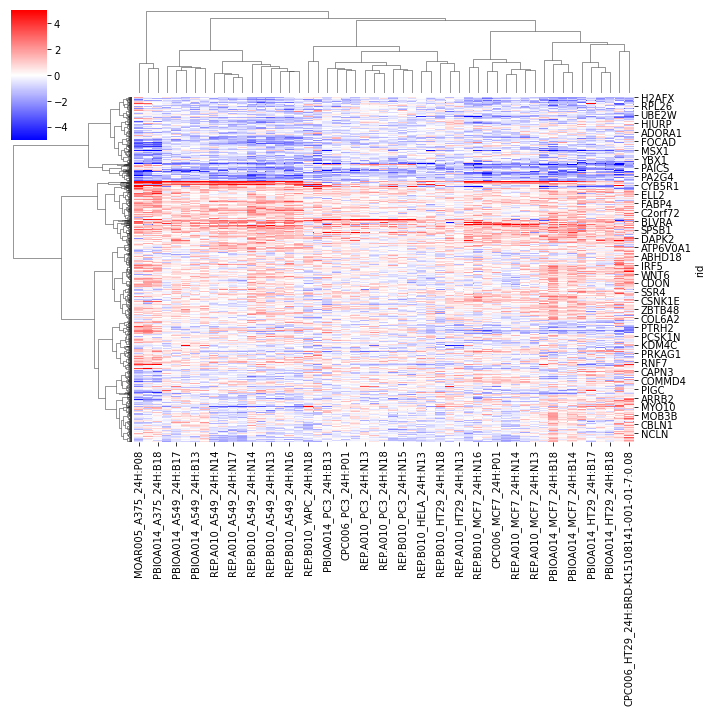

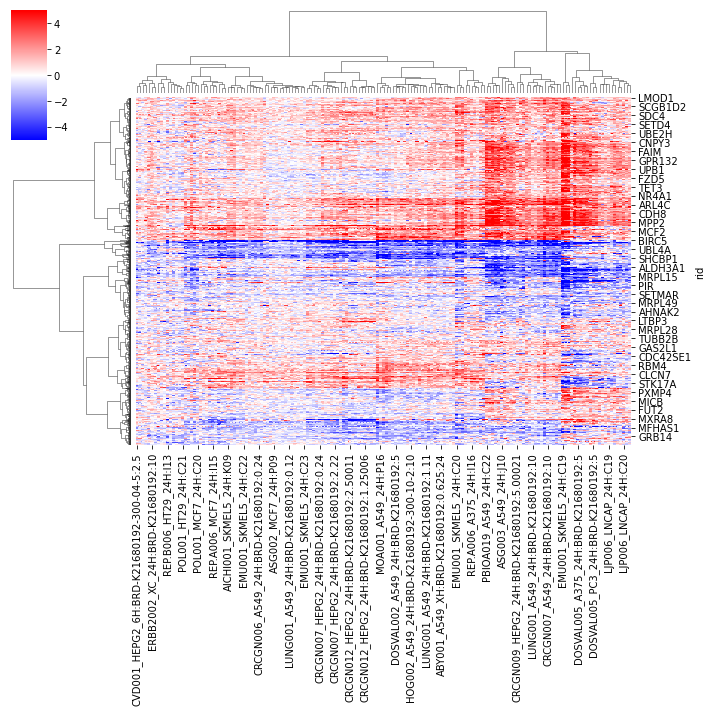

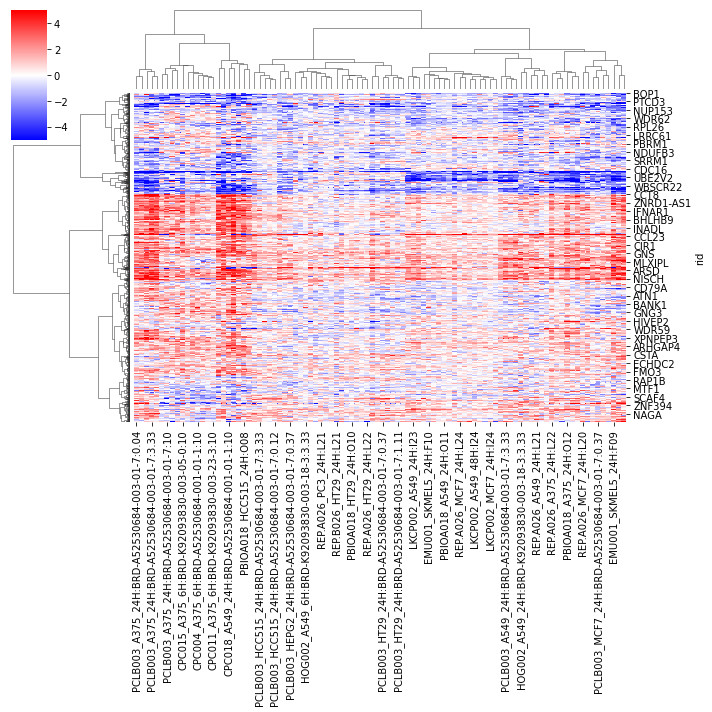

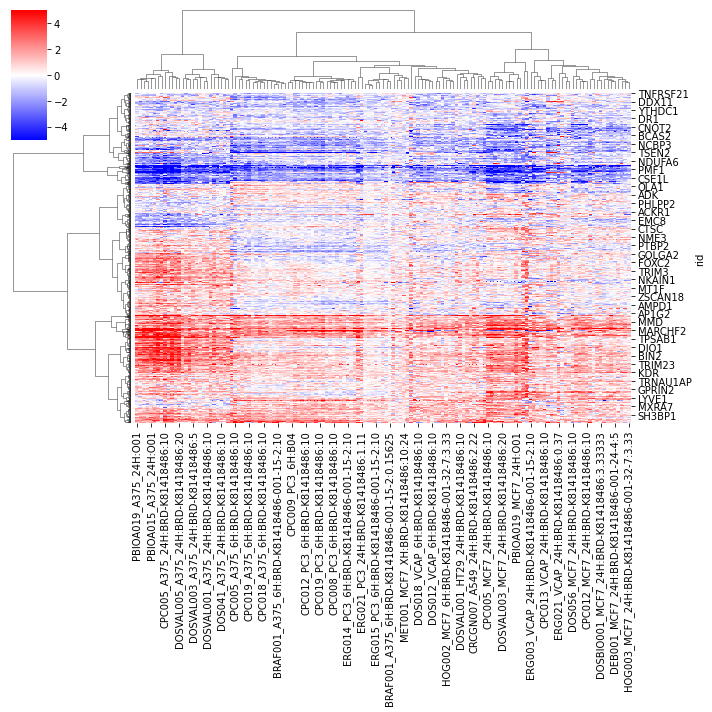

In [211]:
sns.clustermap(expr_gemcitabine_rn, method='ward',
               vmin=-5, vmax=5, cmap='bwr')
plt.show()

sns.clustermap(expr_mitoxantrone_rn, method='ward',
               vmin=-5, vmax=5, cmap='bwr')
plt.show()

sns.clustermap(expr_doxorubicin_rn, method='ward',
               vmin=-5, vmax=5, cmap='bwr')
plt.show()

sns.clustermap(expr_vorinostat_rn, method='ward',
               vmin=-5, vmax=5, cmap='bwr')
plt.show()

In [262]:
# distribution of NREC and REC genes in each experiment: kde plot?
def dis_EC_expr(compound_name, ec_info, expr_matrix):
    tmp_nrec = ec_info[ec_info['EC_profile'] == 'NR-EC'].index
    tmp_rec = ec_info[ec_info['EC_profile'] == 'R-EC'].index
    
    plt.figure(figsize=(3, 1.5))
    for c in expr_matrix.columns:
        sns.kdeplot(expr_matrix.loc[tmp_nrec, c], linewidth=0.1, color='crimson')
        sns.kdeplot(expr_matrix.loc[tmp_rec, c], linewidth=0.1, color='royalblue')
    plt.xlabel('Expression changes after treatment')
    plt.axvline(x=0., ls='--', c='k')
    plt.axvline(x=expr_matrix.loc[tmp_nrec, :].mean().mean(), ls='--', c='red')
    plt.axvline(x=expr_matrix.loc[tmp_rec, :].mean().mean(), ls='--', c='blue')
    plt.title(compound_name)
    plt.xlim(-5, 5)
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(panel_home + 'multi_hit_case/ec_distribution_' + compound_name + '.png', dpi=300, transparent=True)
    fig.savefig(panel_home + 'multi_hit_case/ec_distribution_' + compound_name + '.pdf', transparent=True)
    return

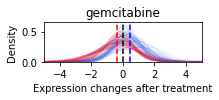

In [263]:
dis_EC_expr(compound_name='gemcitabine', ec_info=EC_gene_info, expr_matrix=expr_gemcitabine_rn)

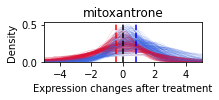

In [264]:
dis_EC_expr(compound_name='mitoxantrone', ec_info=EC_gene_info, expr_matrix=expr_mitoxantrone_rn)

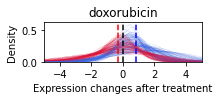

In [265]:
dis_EC_expr(compound_name='doxorubicin', ec_info=EC_gene_info, expr_matrix=expr_doxorubicin_rn)

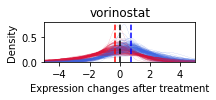

In [266]:
dis_EC_expr(compound_name='vorinostat', ec_info=EC_gene_info, expr_matrix=expr_vorinostat_rn)

In [358]:
# pre-rank: immune signatures
def pre_rank_selected(gene_set_path, sig_matrix):
    prerank_nes = df(columns=sig_matrix.columns)
    prerank_fdr = df(columns=sig_matrix.columns)
    prerank_p = df(columns=sig_matrix.columns)

    for p in sig_matrix.columns:
        rnk = df(sig_matrix[p]).sort_values(by=p, ascending=False)
        pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/' + gene_set_path,
                             processes=4,
                             permutation_num=50, # reduce number to speed up testing
                             outdir=None, format='png', seed=0, min_size=5, max_size=10000)
        prerank_nes[p] = pre_res.res2d['nes']
        prerank_p[p] = pre_res.res2d['pval']
        prerank_fdr[p] = pre_res.res2d['fdr']
    
    prerank_p = prerank_p.T
    prerank_fdr = prerank_fdr.T
    prerank_nes = prerank_nes.T
    
    return prerank_nes, prerank_fdr, prerank_p

In [360]:
nes_mitoxantrone, fdr_mitoxantrone, p_mitoxantrone = pre_rank_selected(gene_set_path='WolfEtAl_71_Symbols.gmt',
                                                                       sig_matrix=expr_mitoxantrone_rn)
nes_mitoxantrone.to_csv(panel_home + 'multi_hit_case/gsea_imsig/nes_mitoxantrone.csv', sep=',')
fdr_mitoxantrone.to_csv(panel_home + 'multi_hit_case/gsea_imsig/fdr_mitoxantrone.csv', sep=',')
p_mitoxantrone.to_csv(panel_home + 'multi_hit_case/gsea_imsig/p_mitoxantrone.csv', sep=',')

In [92]:
nes_mitoxantrone = pd.read_csv(panel_home + 'multi_hit_case/gsea_imsig/nes_mitoxantrone.csv', index_col=0, header=0, sep=',')
fdr_mitoxantrone = pd.read_csv(panel_home + 'multi_hit_case/gsea_imsig/fdr_mitoxantrone.csv', index_col=0, header=0, sep=',')
p_mitoxantrone = pd.read_csv(panel_home + 'multi_hit_case/gsea_imsig/p_mitoxantrone.csv', index_col=0, header=0, sep=',')

In [361]:
nes_vorinostat, fdr_vorinostat, p_vorinostat = pre_rank_selected(gene_set_path='WolfEtAl_71_Symbols.gmt',
                                                                       sig_matrix=expr_vorinostat_rn)
nes_vorinostat.to_csv(panel_home + 'multi_hit_case/gsea_imsig/nes_vorinostat.csv', sep=',')
fdr_vorinostat.to_csv(panel_home + 'multi_hit_case/gsea_imsig/fdr_vorinostat.csv', sep=',')
p_vorinostat.to_csv(panel_home + 'multi_hit_case/gsea_imsig/p_vorinostat.csv', sep=',')

In [93]:
nes_vorinostat = pd.read_csv(panel_home + 'multi_hit_case/gsea_imsig/nes_vorinostat.csv', index_col=0, header=0, sep=',')
fdr_vorinostat = pd.read_csv(panel_home + 'multi_hit_case/gsea_imsig/fdr_vorinostat.csv', index_col=0, header=0, sep=',')
p_vorinostat = pd.read_csv(panel_home + 'multi_hit_case/gsea_imsig/p_vorinostat.csv', index_col=0, header=0, sep=',')

In [362]:
nes_gemcitabine, fdr_gemcitabine, p_gemcitabine = pre_rank_selected(gene_set_path='WolfEtAl_71_Symbols.gmt',
                                                                    sig_matrix=expr_gemcitabine_rn)
nes_gemcitabine.to_csv(panel_home + 'multi_hit_case/gsea_imsig/nes_gemcitabine.csv', sep=',')
fdr_gemcitabine.to_csv(panel_home + 'multi_hit_case/gsea_imsig/fdr_gemcitabine.csv', sep=',')
p_gemcitabine.to_csv(panel_home + 'multi_hit_case/gsea_imsig/p_gemcitabine.csv', sep=',')

In [94]:
nes_gemcitabine = pd.read_csv(panel_home + 'multi_hit_case/gsea_imsig/nes_gemcitabine.csv', index_col=0, header=0, sep=',')
fdr_gemcitabine = pd.read_csv(panel_home + 'multi_hit_case/gsea_imsig/fdr_gemcitabine.csv', index_col=0, header=0, sep=',')
p_gemcitabine = pd.read_csv(panel_home + 'multi_hit_case/gsea_imsig/p_gemcitabine.csv', index_col=0, header=0, sep=',')

In [363]:
nes_doxorubicin, fdr_doxorubicin, p_doxorubicin = pre_rank_selected(gene_set_path='WolfEtAl_71_Symbols.gmt',
                                                                    sig_matrix=expr_doxorubicin_rn)
nes_doxorubicin.to_csv(panel_home + 'multi_hit_case/gsea_imsig/nes_doxorubicin.csv', sep=',')
fdr_doxorubicin.to_csv(panel_home + 'multi_hit_case/gsea_imsig/fdr_doxorubicin.csv', sep=',')
p_doxorubicin.to_csv(panel_home + 'multi_hit_case/gsea_imsig/p_doxorubicin.csv', sep=',')

In [95]:
nes_doxorubicin = pd.read_csv(panel_home + 'multi_hit_case/gsea_imsig/nes_doxorubicin.csv', index_col=0, header=0, sep=',')
fdr_doxorubicin = pd.read_csv(panel_home + 'multi_hit_case/gsea_imsig/fdr_doxorubicin.csv', index_col=0, header=0, sep=',')
p_doxorubicin = pd.read_csv(panel_home + 'multi_hit_case/gsea_imsig/p_doxorubicin.csv', index_col=0, header=0, sep=',')

In [96]:
# read pathway
immune_class = pd.read_csv(data_home + 'immuneSig/signature_class.csv', header=0, index_col=0, sep=',')
print(immune_class.head())

                                class
signatures                           
MHC1_21978456    Antigen Presentation
MHC2_21978456    Antigen Presentation
MHC.I_19272155   Antigen Presentation
MHC.II_19272155  Antigen Presentation
PD1_data                  Check Point


In [48]:
immune_class['class'].unique()

array(['Antigen Presentation', 'Check Point', 'Chemokine', 'Cytokine ',
       'Cytotoxic T cell', 'IFN Signaling', 'Leukocyte', 'TAM', 'B cell',
       'DC cells', 'Neutrophil', 'Monocyte', 'NK cells', 'Other',
       'Proliferation'], dtype=object)

In [97]:
def top_enrich_pathway(nes, fdr, im_annot):
    # average nes by cell lines
    nes_cl = nes.copy().fillna(0)

    # remove inf
    nes_cl.replace([np.inf, -np.inf], np.nan, inplace=True)
    nes_cl = nes_cl.dropna(axis=0, how='all').fillna(0)
    nes_cl['cell_line'] = sig_info['cell_mfc_name']
    nes_cl = df(nes_cl.groupby('cell_line').mean()).dropna(axis=1, how='all').fillna(0)
    
    # average fdr by cell lines
    fdr_cl = fdr.copy().fillna(1)
    fdr_cl.replace([np.inf, -np.inf], np.nan, inplace=True)
    fdr_cl = fdr_cl.dropna(axis=0, how='all').fillna(1)
    fdr_cl['cell_line'] = sig_info['cell_mfc_name']
    fdr_cl = df(fdr_cl.groupby('cell_line').mean()).dropna(axis=1, how='all').fillna(1)
    
    # get top pathways
    nes_cl_ave = df(nes_cl.mean(axis=0))
    nes_cl_ave['annot'] = im_annot['class']
    nes_cl_ave = nes_cl_ave.dropna(axis=0, how='any') # drop pathway without annotation
    nes_cl_ave = nes_cl_ave[nes_cl_ave['annot'] != 'Other'] # drop pathway termed "Other"
    nes_cl_ave = nes_cl_ave.sort_values(by=0, ascending=False)
    nes_cl_ave['ave_p'] = fdr_cl.mean(axis=0)
    
    fdr_cl_ave = df(fdr_cl.mean(axis=0)).rename(columns={'0': 'ave_p'})
    fdr_cl_ave['annot'] = im_annot['class']
    fdr_cl_ave = fdr_cl_ave.dropna(axis=0, how='any') # drop pathway without annotation
    fdr_cl_ave = fdr_cl_ave[fdr_cl_ave['annot'] != 'Other'] # drop pathway termed "Other"
    fdr_cl_ave = fdr_cl_ave.sort_values(by=0, ascending=True)
    fdr_cl_ave['ave_nes'] = nes_cl.mean(axis=0)
    
    return nes_cl, fdr_cl, fdr_cl_ave

In [98]:
fdr_mitoxantrone['STAT1_score']

ASG002_MCF7_24H:P08        0.026337
REP.B006_MCF7_24H:I13      0.029079
REP.B006_MCF7_24H:I14      0.000000
ASG003_MCF7_24H:J11        0.004529
POL001_MCF7_24H:C20        0.002380
                             ...   
AICHI001_SKMEL5_24H:K10    0.318018
EMU001_SKMEL5_24H:C21      0.186243
AICHI002_SKMEL5_24H:K08    0.023563
EMU001_SKMEL5_24H:C22      0.046061
EMU001_SKMEL5_24H:C20      0.077282
Name: STAT1_score, Length: 163, dtype: float64

In [121]:
top_rs_cp_shift

NREC_profile  REC_profile  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10     -0.440463     0.303870   
ERBB2002_J82_24H:BRD-K66175015:10        -0.327901     0.377128   
REP.A019_MDAMB231_24H:L13                -0.445946     0.507214   
REP.A023_MCF7_24H:P14                    -0.471999     0.456107   
LKCP002_MCF7_48H:B10                     -0.458585     0.468354   
...                                            ...          ...   
REP.B019_A375_24H:L13                    -0.344476     0.356070   
REP.A010_A375_24H:E19                    -0.362728     0.337780   
PCLB002_A375_24H:BRD-A19037878:10        -0.309860     0.390580   
DOSVAL004_A375_24H:BRD-K81418486:10      -0.386596     0.313822   
LJP005_A375_24H:C22                      -0.320123     0.379995   

                                          cmap_name  nearest_dose pert_idose  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10       AZD-9291         10.00      10 uM   
ERBB2002_J82_24H:BRD-K66175015:10          afatinib         10.00      10 uM   
REP.A019_MDAMB231_24H:L13                 dasatinib         10.00      10 uM   
REP.A023_MCF7_24H:P14                   floxuridine          3.33    3.33 uM   
LKCP002_MCF7_48H:B10                     tipifarnib         10.00      10 uM   
...                                             ...           ...        ...   
REP.B019_A375_24H:L13                     dasatinib          2.22    2.22 uM   
REP.A010_A375_24H:E19                      acivicin         12.00      12 uM   
PCLB002_A375_24H:BRD-A19037878:10     BRD-A19037878         10.00      10 uM   
DOSVAL004_A375_24H:BRD-K81418486:10      vorinostat         10.00      10 uM   
LJP005_A375_24H:C22                    mitoxantrone          0.37    0.37 uM   

                                      shift_ability cancer_type cell_line  
ERBB2001_VMCUB1_24H:BRD-K42805893:10       0.744333        BLCA    VMCUB1  
ERBB2002_J82_24H:BRD-K66175015:10          0.705029        BLCA       J82  
REP.A019_MDAMB231_24H:L13                  0.953159        BRCA  MDAMB231  
REP.A023_MCF7_24H:P14                      0.928106        BRCA      MCF7  
LKCP002_MCF7_48H:B10                       0.926939        BRCA      MCF7  
...                                             ...         ...       ...  
REP.B019_A375_24H:L13                      0.700546        SKCM      A375  
REP.A010_A375_24H:E19                      0.700508        SKCM      A375  
PCLB002_A375_24H:BRD-A19037878:10          0.700441        SKCM      A375  
DOSVAL004_A375_24H:BRD-K81418486:10        0.700418        SKCM      A375  
LJP005_A375_24H:C22                        0.700118        SKCM      A375  

[3983 rows x 8 columns]

In [99]:
nes_mitoxantrone_cl, p_mitoxantrone_cl, top_path_mitoxantrone = top_enrich_pathway(nes=nes_mitoxantrone, fdr=p_mitoxantrone, im_annot=immune_class)

In [100]:
nes_doxorubicin_cl, p_doxorubicin_cl, top_path_doxorubicin = top_enrich_pathway(nes=nes_doxorubicin, fdr=p_doxorubicin, im_annot=immune_class)

In [101]:
nes_gemcitabine_cl, p_gemcitabine_cl, top_path_gemcitabine = top_enrich_pathway(nes=nes_gemcitabine, fdr=p_gemcitabine, im_annot=immune_class)

In [102]:
nes_vorinostat_cl, p_vorinostat_cl, top_path_vorinostat = top_enrich_pathway(nes=nes_vorinostat, fdr=p_vorinostat, im_annot=immune_class)

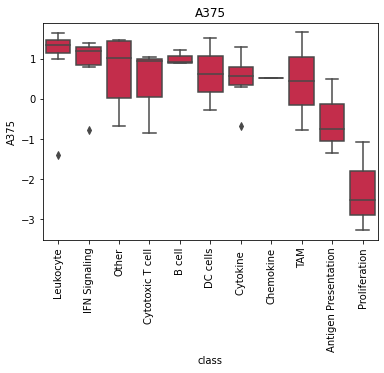

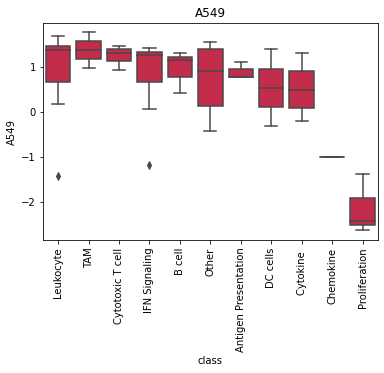

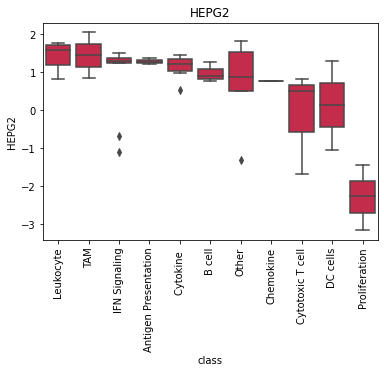

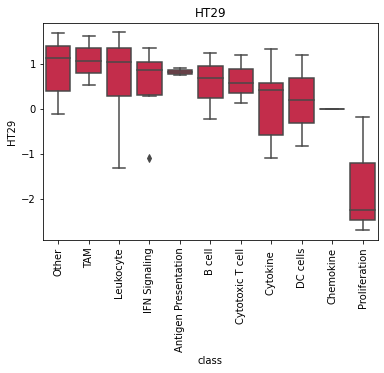

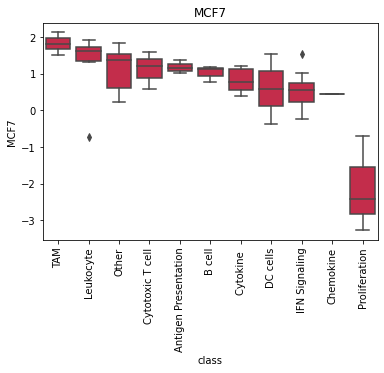

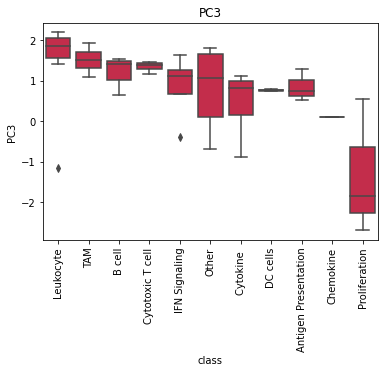

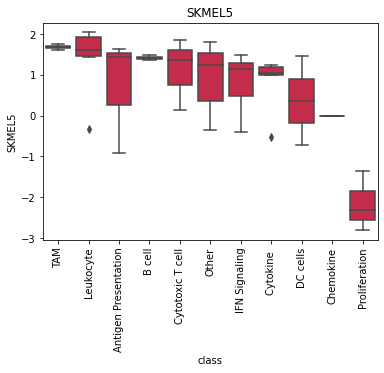

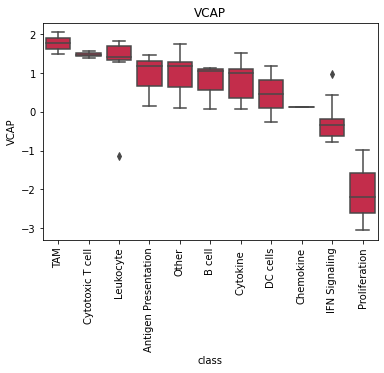

In [109]:
for cl in nes_vorinostat_cl.index:
    tmp_cl = df(nes_vorinostat_cl.loc[cl, :])
    tmp_cl['class'] = immune_class['class']
    sns.boxplot(x='class', y=cl,
                order=df(tmp_cl.groupby('class').median()).sort_values(by=cl, ascending=False).index,
                data=tmp_cl, color='crimson')
    plt.title(cl)
    plt.xticks(rotation=90)
    plt.show()

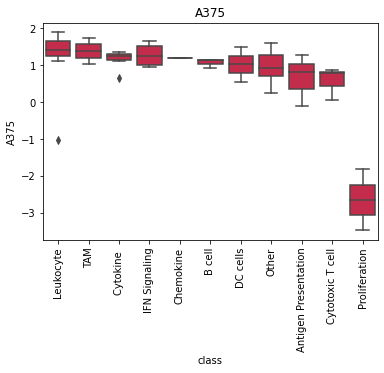

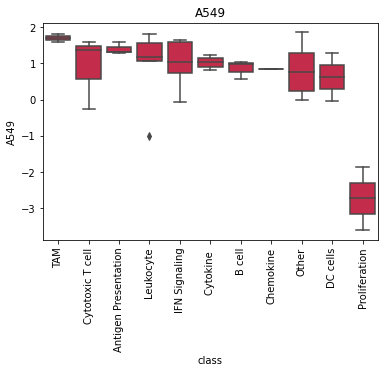

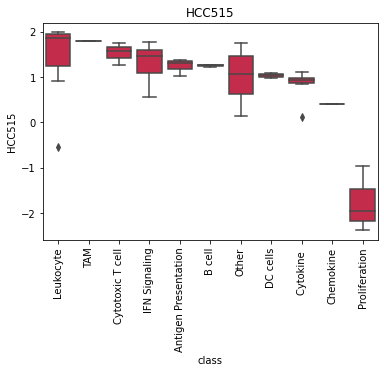

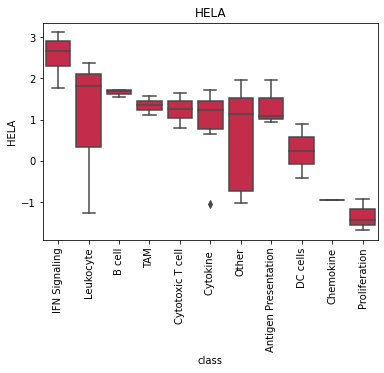

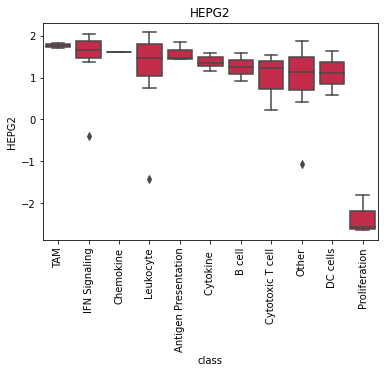

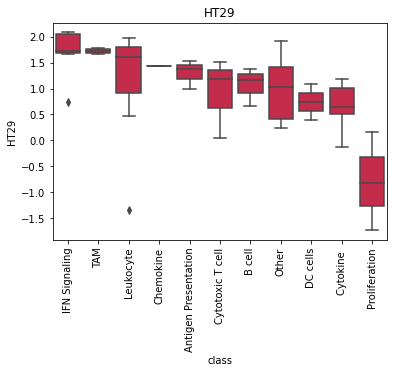

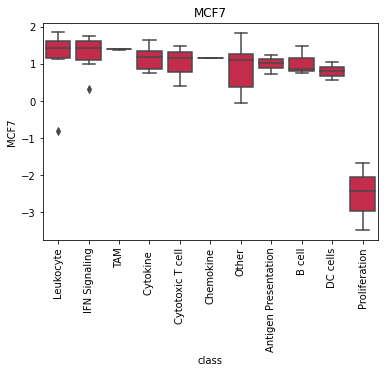

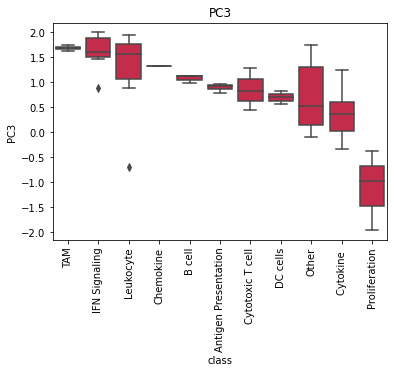

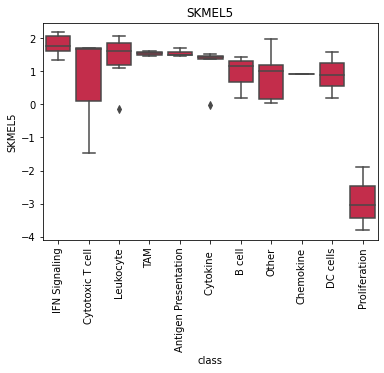

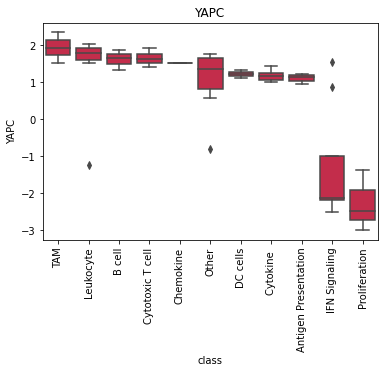

In [110]:
for cl in nes_doxorubicin_cl.index:
    tmp_cl = df(nes_doxorubicin_cl.loc[cl, :])
    tmp_cl['class'] = immune_class['class']
    sns.boxplot(x='class', y=cl,
                order=df(tmp_cl.groupby('class').median()).sort_values(by=cl, ascending=False).index,
                data=tmp_cl, color='crimson')
    plt.title(cl)
    plt.xticks(rotation=90)
    plt.show()

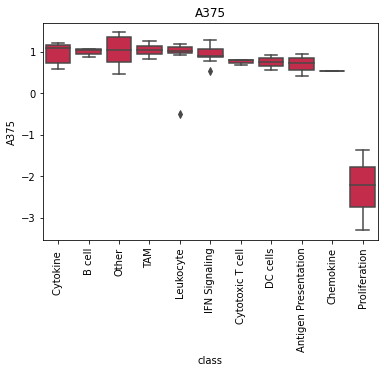

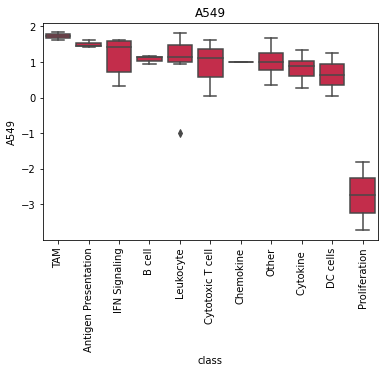

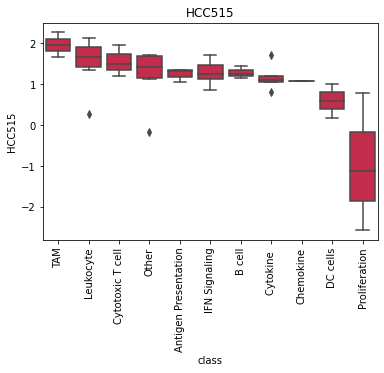

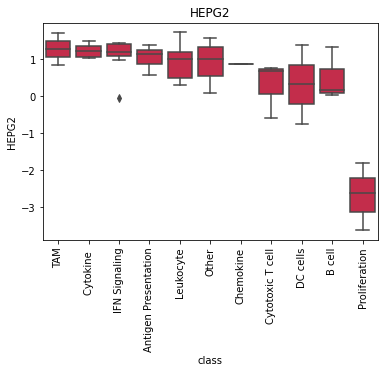

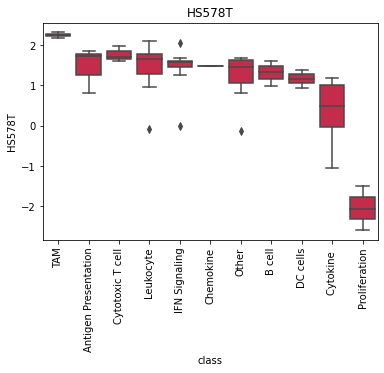

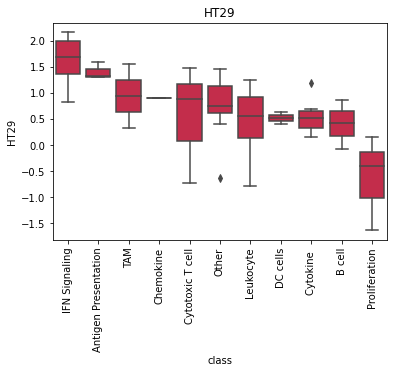

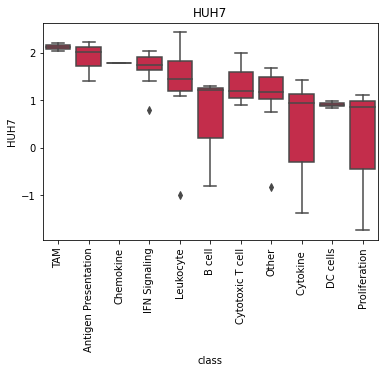

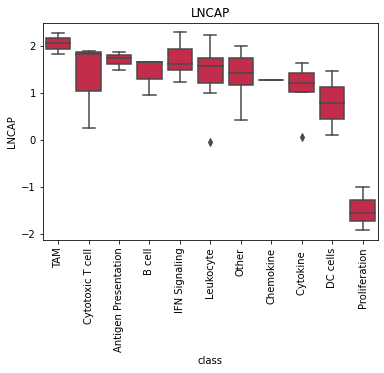

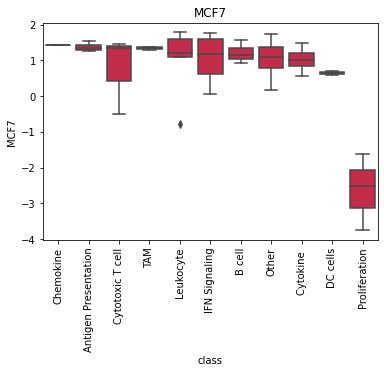

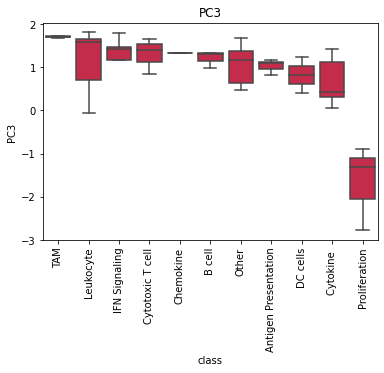

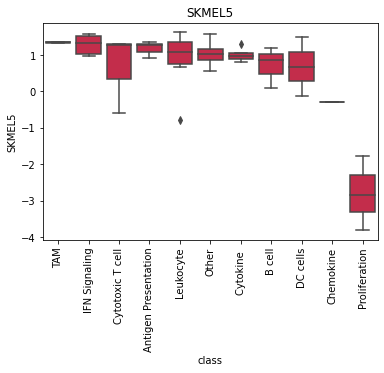

In [111]:
for cl in nes_mitoxantrone_cl.index:
    tmp_cl = df(nes_mitoxantrone_cl.loc[cl, :])
    tmp_cl['class'] = immune_class['class']
    sns.boxplot(x='class', y=cl,
                order=df(tmp_cl.groupby('class').median()).sort_values(by=cl, ascending=False).index,
                data=tmp_cl, color='crimson')
    plt.title(cl)
    plt.xticks(rotation=90)
    plt.show()

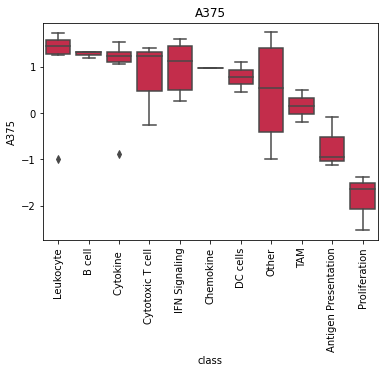

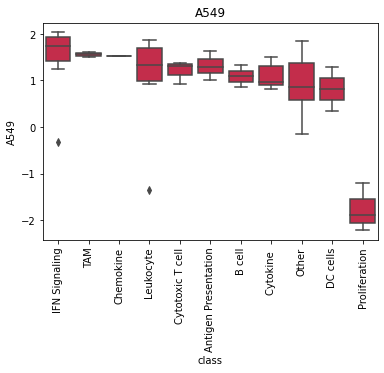

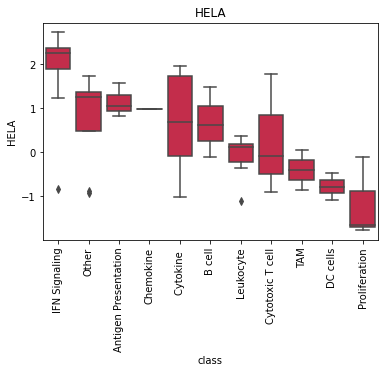

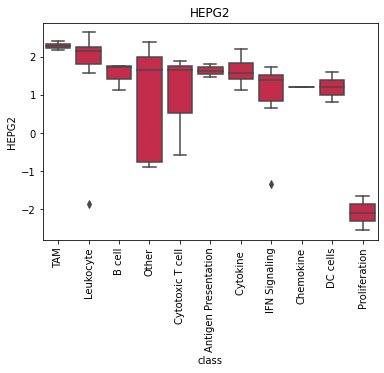

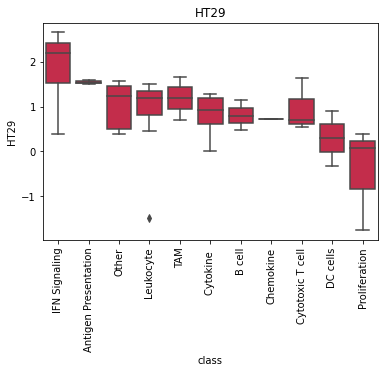

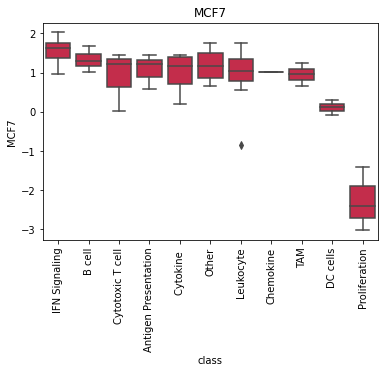

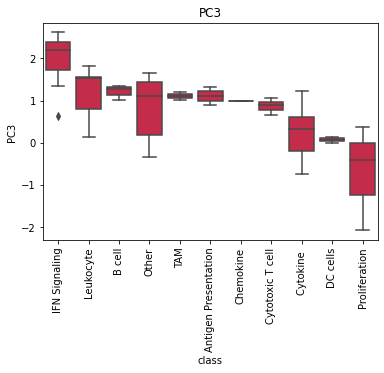

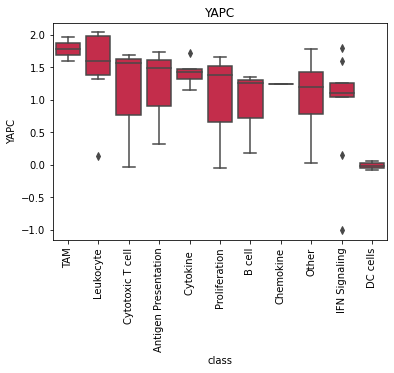

In [112]:
for cl in nes_gemcitabine_cl.index:
    tmp_cl = df(nes_gemcitabine_cl.loc[cl, :])
    tmp_cl['class'] = immune_class['class']
    sns.boxplot(x='class', y=cl,
                order=df(tmp_cl.groupby('class').median()).sort_values(by=cl, ascending=False).index,
                data=tmp_cl, color='crimson')
    plt.title(cl)
    plt.xticks(rotation=90)
    plt.show()

In [115]:
# A375
merge_a375 = df(index=nes_doxorubicin_cl.columns)
merge_a375['doxorubicin'] = nes_doxorubicin_cl.loc['A375', :]
merge_a375['vorinostat'] = nes_vorinostat_cl.loc['A375', :]
merge_a375['mitoxantrone'] = nes_mitoxantrone_cl.loc['A375', :]
merge_a375['gemcitabine'] = nes_gemcitabine_cl.loc['A375', :]
merge_a375['class'] = immune_class['class']

In [116]:
merge_a375

doxorubicin  vorinostat  mitoxantrone  \
CHANG_CORE_SERUM_RESPONSE_UP       -2.651481   -2.520736     -2.205376   
Immune_cell_Cluster_21214954        1.891081    1.475655      1.178112   
Minterferon_Cluster_21214954        1.460834    0.857692      1.143605   
Module11_Prolif_score              -3.472509   -3.278328     -3.296554   
Module5_TcellBcell_score            1.702198    0.985929      1.156078   
STAT1_19272155                      1.557108    0.991078      1.063488   
STAT1_score                         1.667805    1.282974      1.072103   
TGFB_score_21050467                 0.667833   -0.667065      0.617632   
IFNG_score_21050467                 0.985211   -0.770183      0.525987   
HER2_Immune_PCA_18006808            1.614090    1.474061      1.460391   
MCD3_CD8_21214954                   0.058483    1.057498      0.672293   
Module3_IFN_score                   1.535086    1.400700      1.270241   
LCK_19272155                        1.627490    1.645783      1.048061   
Interferon_Cluster_21214954         1.250652    0.785642      0.778822   
CSF1_response                       1.748118    1.656972      1.250808   
IFN_21978456                        1.056669    1.198031      0.882366   
Module4_TcellBcell_score            1.405722    1.453323      0.922785   
LIexpression_score                  1.083169    1.477368      1.061665   
Tcell_21978456                      1.356051    1.297917      1.005590   
Chemokine12_score                   1.185863    0.514882      0.535873   
LYMPHS_PCA_16704732                -1.033863   -1.404989     -0.500947   
TGFB_PCA_17349583                   1.111388    0.843153      0.593833   
CSR_Activated_15701700             -1.817418   -1.068828     -1.370162   
IR7_score                           0.955746    1.205362      0.883794   
B_cell_PCA_16704732                 1.156695    0.916234      1.065941   
CD103pos_mean_25446897              0.560320   -0.285635      0.567090   
IGG_Cluster_21214954                0.917449    0.888520      0.859502   
CD8_PCA_16704732                    0.795600    0.932856      0.786987   
T_cell_PCA_16704732                 1.127860    1.339057      0.991495   
IL13_score_21050467                 1.352688    0.291636      1.203170   
IL4_score_21050467                  1.299458    0.521404      1.006941   
ZHANG_INTERFERON_RESPONSE           1.333934    0.852204      1.081548   
Troester_WoundSig_19887484          1.245202    0.728313      1.381020   
IL12_score_21050467                 1.281929    0.623772      1.160717   
Interferon_19272155                 0.997024    1.305062      0.861920   
Immune_NSCLC_score                  1.367512    1.422667      1.328053   
KEGG_HEMATOPOIETIC_CELL_LINEAGE     1.592401    1.242839      1.707143   
GRANS_PCA_16704732                  0.790994    1.324315      1.026183   
CD103neg_mean_25446897              1.494910    1.521880      0.927903   
IL2_score_21050467                  1.222773    1.286824      1.170071   
Bcell_receptors_score               1.152605    1.221586      1.046509   
Buck14_score                        0.557917    0.093932      0.671177   
MHC1_21978456                       1.272611    0.486539      0.948294   
MHC.II_19272155                     0.811431   -0.761162      0.732600   
TcClassII_score                     0.866781   -0.852697      0.797924   
TAMsurr_TcClassII_ratio             1.029958   -0.768215      0.825878   
MHC2_21978456                      -0.099779   -1.339283      0.406568   
MDACC.FNA.1_20805453                0.250949   -0.676339      0.449522   
Rotterdam_ERneg_PCA_15721472        0.749141   -0.157748      0.782798   

                                 gemcitabine                 class  
CHANG_CORE_SERUM_RESPONSE_UP       -1.630780         Proliferation  
Immune_cell_Cluster_21214954        1.448922             Leukocyte  
Minterferon_Cluster_21214954        1.448731         IFN Signaling  
Module11_Prolif_score              -2.523267         Pro

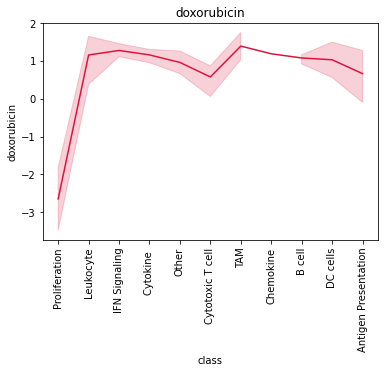

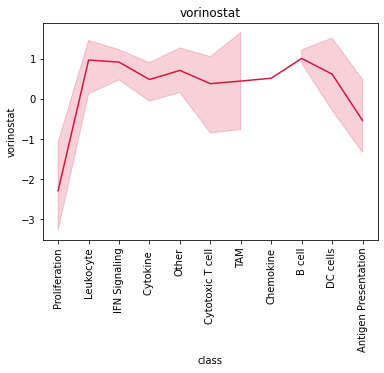

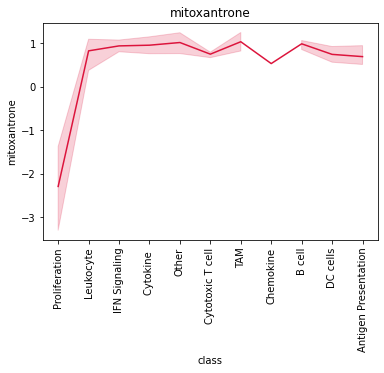

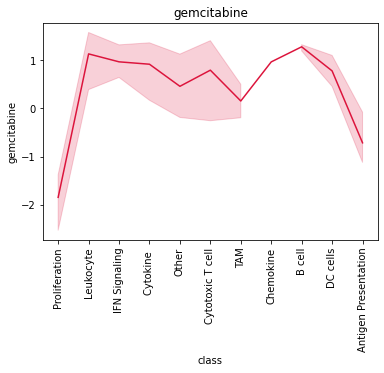

In [147]:
for c in merge_a375.columns:
    if c != 'class':
        sns.lineplot(x='class', y=c,
                    # order=df(merge_a375.groupby('class').mean()).sort_values(by=c, ascending=False).index,
                    data=merge_a375, color='crimson')
        plt.title(c)
        plt.xticks(rotation=90)
        plt.show()

In [133]:
merge_im_enr = pd.concat([nes_doxorubicin, nes_gemcitabine, nes_mitoxantrone, nes_vorinostat], axis=0)
merge_im_enr_a375 = merge_im_enr[merge_im_enr.index.isin(sig_info[sig_info['cell_iname'] == 'A375'].index)]
merge_im_enr_a375

CHANG_CORE_SERUM_RESPONSE_UP  \
PBIOA018_A375_24H:O12                                   -3.104339   
PBIOA018_A375_24H:O11                                   -2.785177   
PBIOA018_A375_24H:O10                                   -3.048358   
PBIOA018_A375_24H:O08                                   -2.380187   
REP.A026_A375_24H:L24                                   -2.967860   
...                                                           ...   
CPC005_A375_6H:BRD-K81418486:10                         -2.025694   
PBIOA016_A375_24H:O01                                   -2.981960   
DOSVAL005_A375_24H:BRD-K81418486:20                     -3.145845   
DOSVAL001_A375_24H:BRD-K81418486:10                     -2.638010   
DOSVAL004_A375_24H:BRD-K81418486:10                     -2.704093   

                                     Immune_cell_Cluster_21214954  \
PBIOA018_A375_24H:O12                                    1.632522   
PBIOA018_A375_24H:O11                                    1.927899   
PBIOA018_A375_24H:O10                                    1.825971   
PBIOA018_A375_24H:O08                                    2.196021   
REP.A026_A375_24H:L24                                    1.165756   
...                                                           ...   
CPC005_A375_6H:BRD-K81418486:10                          0.970975   
PBIOA016_A375_24H:O01                                    0.827745   
DOSVAL005_A375_24H:BRD-K81418486:20                      0.888027   
DOSVAL001_A375_24H:BRD-K81418486:10                      0.946384   
DOSVAL004_A375_24H:BRD-K81418486:10                      0.982638   

                                     Minterferon_Cluster_21214954  \
PBIOA018_A375_24H:O12                                    1.974980   
PBIOA018_A375_24H:O11                                    1.638762   
PBIOA018_A375_24H:O10                                    1.327171   
PBIOA018_A375_24H:O08                                    1.773836   
REP.A026_A375_24H:L24                                    1.068255   
...                                                           ...   
CPC005_A375_6H:BRD-K81418486:10                          0.675099   
PBIOA016_A375_24H:O01                                    0.774819   
DOSVAL005_A375_24H:BRD-K81418486:20                      0.812972   
DOSVAL001_A375_24H:BRD-K81418486:10                     -1.153688   
DOSVAL004_A375_24H:BRD-K81418486:10                      1.284483   

                                     Module11_Prolif_score  \
PBIOA018_A375_24H:O12                            -3.909260   
PBIOA018_A375_24H:O11                            -3.721962   
PBIOA018_A375_24H:O10                            -4.098188   
PBIOA018_A375_24H:O08                            -3.111904   
REP.A026_A375_24H:L24                            -3.522121   
...                                                    ...   
CPC005_A375_6H:BRD-K81418486:10                  -2.746245   
PBIOA016_A375_24H:O01                            -3.888692   
DOSVAL005_A375_24H:BRD-K81418486:20              -3.649836   
DOSVAL001_A375_24H:BRD-K81418486:10              -3.898367   
DOSVAL004_A375_24H:BRD-K81418486:10              -3.944587   

                                     Module5_TcellBcell_score  STAT1_19272155  \
PBIOA018_A375_24H:O12                                1.689216        1.574316   
PBIOA018_A375_24H:O11                                1.836139        1.684587   
PBIOA018_A375_24H:O10                                1.694093        1.509930   
PBIOA018_A375_24H:O08                                2.198222        1.761921   
REP.A026_A375_24H:L24                                1.270277        0.902018   
...                                                       ...             ...   
CPC005_A375_6H:BRD-K81418486:10                     -1.648769        0.762406   
PBIOA016_A375_24H:O01                                1.248640        1.042144   
DOSVAL005_A375_24H:BRD-K81418486:20                  1.229518        1.04372

In [137]:
merge_im_enr_a375['cmap_name'] = sig_info['cmap_name']

<ipython-input-137-bc0a77578d9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_im_enr_a375['cmap_name'] = sig_info['cmap_name']


In [138]:
merge_im_enr_a375

CHANG_CORE_SERUM_RESPONSE_UP  \
PBIOA018_A375_24H:O12                                   -3.104339   
PBIOA018_A375_24H:O11                                   -2.785177   
PBIOA018_A375_24H:O10                                   -3.048358   
PBIOA018_A375_24H:O08                                   -2.380187   
REP.A026_A375_24H:L24                                   -2.967860   
...                                                           ...   
CPC005_A375_6H:BRD-K81418486:10                         -2.025694   
PBIOA016_A375_24H:O01                                   -2.981960   
DOSVAL005_A375_24H:BRD-K81418486:20                     -3.145845   
DOSVAL001_A375_24H:BRD-K81418486:10                     -2.638010   
DOSVAL004_A375_24H:BRD-K81418486:10                     -2.704093   

                                     Immune_cell_Cluster_21214954  \
PBIOA018_A375_24H:O12                                    1.632522   
PBIOA018_A375_24H:O11                                    1.927899   
PBIOA018_A375_24H:O10                                    1.825971   
PBIOA018_A375_24H:O08                                    2.196021   
REP.A026_A375_24H:L24                                    1.165756   
...                                                           ...   
CPC005_A375_6H:BRD-K81418486:10                          0.970975   
PBIOA016_A375_24H:O01                                    0.827745   
DOSVAL005_A375_24H:BRD-K81418486:20                      0.888027   
DOSVAL001_A375_24H:BRD-K81418486:10                      0.946384   
DOSVAL004_A375_24H:BRD-K81418486:10                      0.982638   

                                     Minterferon_Cluster_21214954  \
PBIOA018_A375_24H:O12                                    1.974980   
PBIOA018_A375_24H:O11                                    1.638762   
PBIOA018_A375_24H:O10                                    1.327171   
PBIOA018_A375_24H:O08                                    1.773836   
REP.A026_A375_24H:L24                                    1.068255   
...                                                           ...   
CPC005_A375_6H:BRD-K81418486:10                          0.675099   
PBIOA016_A375_24H:O01                                    0.774819   
DOSVAL005_A375_24H:BRD-K81418486:20                      0.812972   
DOSVAL001_A375_24H:BRD-K81418486:10                     -1.153688   
DOSVAL004_A375_24H:BRD-K81418486:10                      1.284483   

                                     Module11_Prolif_score  \
PBIOA018_A375_24H:O12                            -3.909260   
PBIOA018_A375_24H:O11                            -3.721962   
PBIOA018_A375_24H:O10                            -4.098188   
PBIOA018_A375_24H:O08                            -3.111904   
REP.A026_A375_24H:L24                            -3.522121   
...                                                    ...   
CPC005_A375_6H:BRD-K81418486:10                  -2.746245   
PBIOA016_A375_24H:O01                            -3.888692   
DOSVAL005_A375_24H:BRD-K81418486:20              -3.649836   
DOSVAL001_A375_24H:BRD-K81418486:10              -3.898367   
DOSVAL004_A375_24H:BRD-K81418486:10              -3.944587   

                                     Module5_TcellBcell_score  STAT1_19272155  \
PBIOA018_A375_24H:O12                                1.689216        1.574316   
PBIOA018_A375_24H:O11                                1.836139        1.684587   
PBIOA018_A375_24H:O10                                1.694093        1.509930   
PBIOA018_A375_24H:O08                                2.198222        1.761921   
REP.A026_A375_24H:L24                                1.270277        0.902018   
...                                                       ...             ...   
CPC005_A375_6H:BRD-K81418486:10                     -1.648769        0.762406   
PBIOA016_A375_24H:O01                                1.248640        1.042144   
DOSVAL005_A375_24H:BRD-K81418486:20                  1.229518        1.04372

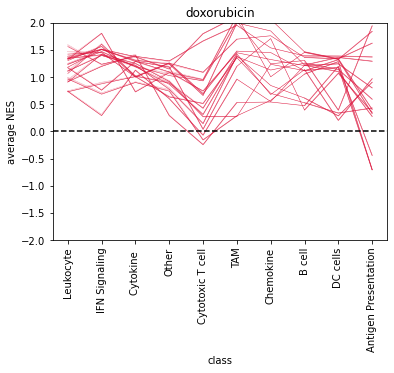

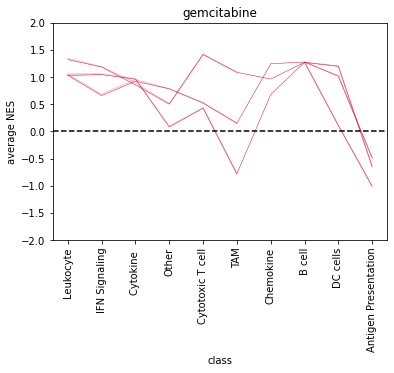

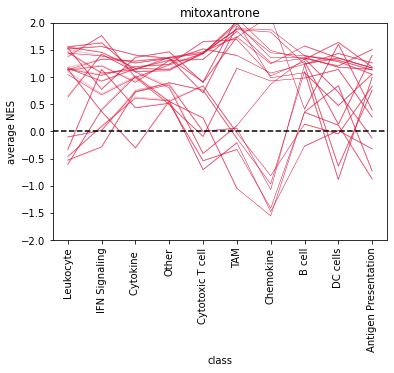

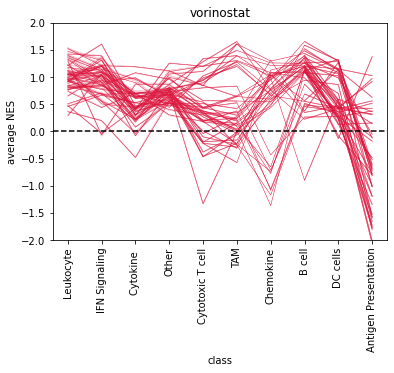

In [164]:
for d in merge_im_enr_a375['cmap_name'].unique():
    tmp_d = merge_im_enr_a375[merge_im_enr_a375['cmap_name'] == d]
    tmp_d = tmp_d.drop(columns='cmap_name').T
    tmp_d['class'] = immune_class['class']
    tmp_d = tmp_d[tmp_d['class'] != 'Proliferation']
    
    for s in tmp_d.columns:
        if s != 'class':
            sns.lineplot(x='class', y=s, data=tmp_d, color='crimson',
                         linewidth=0.5, ci=False)
    plt.title(d)
    plt.xticks(rotation=90)
    plt.ylabel('average NES')
    plt.axhline(y=0., ls='--', c='k')
    plt.ylim(-2, 2)
    plt.show()

In [455]:
def boPlot_gsea(corr, fdr, fdr_threshold, vmin, vmax, path=None):
    '''
    Visualize by bo plot for GSEA. Dot size indicate the significance, color indicate the correlation
    '''
    
    tmp_g = sns.clustermap(corr, method='ward')
    plt.close()
    tmp_x = [corr.index[i] for i in tmp_g.dendrogram_row.reordered_ind]
    tmp_y = [corr.columns[i] for i in tmp_g.dendrogram_col.reordered_ind]
    
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, aspect='equal')
    sns.heatmap(corr.loc[tmp_x, tmp_y], vmin=vmin, vmax=vmax, cmap='Spectral_r',
                square=True, linewidths=0.05, linecolor='k',
                xticklabels=True, yticklabels=True)
    
    fdr = fdr.loc[tmp_x, tmp_y]
    location = {}
    j = 1
    for ctype in fdr.columns:
        location[ctype] = df(index=fdr.index, columns=['x', 'y'])
        location[ctype]['fdr'] = fdr[ctype]
        location[ctype]['corr'] = corr[ctype]

        i = 1
        for t in location[ctype].index:
            location[ctype].at[t, 'y'] = i - .5
            location[ctype].at[t, 'x'] = j - .5
            i += 1
        j += 1

    # collapse all subframe to one
    mergeIndex = []
    for c in location.keys():
        mergeIndex.extend([c + '~' + x for x in location[c].index])
    mergeLoc = df(index=mergeIndex, columns=['x', 'y', 'fdr', 'corr'])
    for c in location.keys():
        for t in fdr.index:
            mergeLoc.at[c + '~' + t, 'x'] = location[c].loc[t, 'x']
            mergeLoc.at[c + '~' + t, 'y'] = location[c].loc[t, 'y']
            mergeLoc.at[c + '~' + t, 'fdr'] = location[c].loc[t, 'fdr']
            mergeLoc.at[c + '~' + t, 'corr'] = location[c].loc[t, 'corr']
    
    # remove points with p > 0.1
    mergeLoc = mergeLoc[mergeLoc['fdr'] >= fdr_threshold].dropna(axis=0, how='any')
    
    # sns.scatterplot(x=mergeLoc['x'], y=mergeLoc['y'], size=mergeLoc['value'], color='k', linewidths=False)
    ax.scatter(
        x=mergeLoc['x'], y=mergeLoc['y'],
        s=mergeLoc['fdr'].astype(float)*50,
        color='k',
        # c=mergeLoc['corr'], cmap=plt.cm.bwr, vmin=-2, vmax=2,
        )
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    
    plt.subplots_adjust(left=0.1)
    plt.tight_layout()
    if path != None:
        fig = plt.gcf()
        fig.savefig(path, dpi=300, transparent=True)
    plt.show()

    return

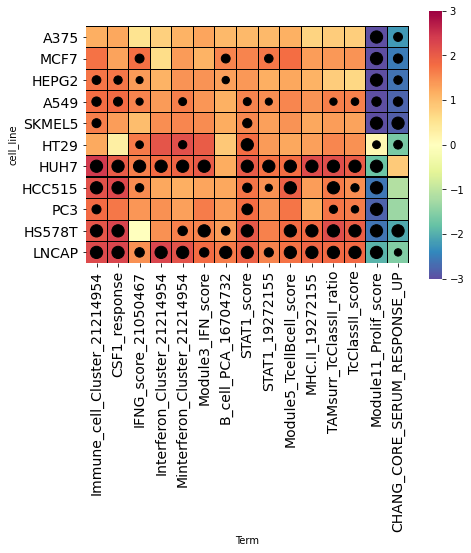

In [464]:
boPlot_gsea(corr=nes_mitoxantrone_cl[top_path_mitoxantrone[:15].index],
            fdr=-np.log10(p_mitoxantrone_cl[top_path_mitoxantrone[:15].index].astype(float) + 0.001),
            fdr_threshold=1., vmin=-3, vmax=3, path=panel_home + 'multi_hit_case/gsea_imsig_top/mitoxantrone.pdf')

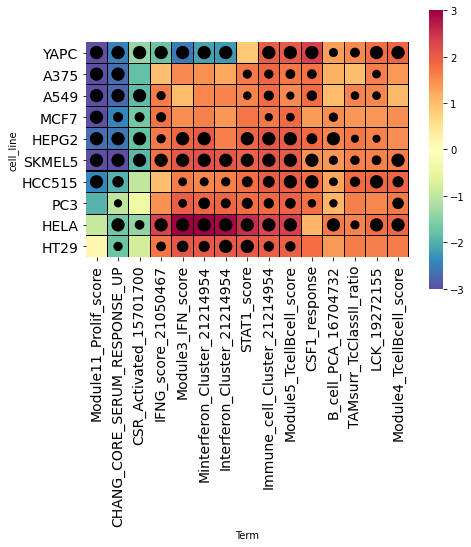

In [463]:
boPlot_gsea(corr=nes_doxorubicin_cl[top_path_doxorubicin[:15].index],
            fdr=-np.log10(p_doxorubicin_cl[top_path_doxorubicin[:15].index].astype(float) + 0.001),
            fdr_threshold=1., vmin=-3, vmax=3, path=panel_home + 'multi_hit_case/gsea_imsig_top/doxorubicin.pdf')

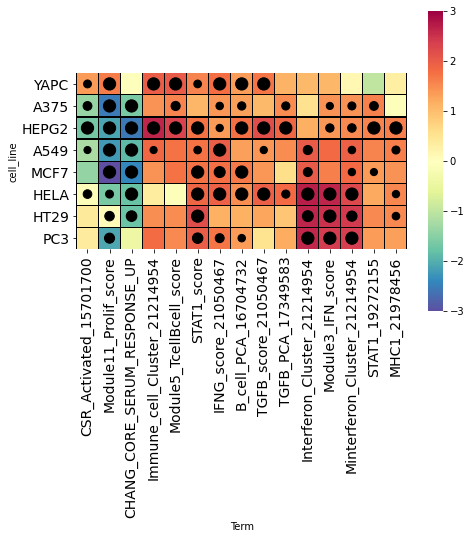

In [462]:
boPlot_gsea(corr=nes_gemcitabine_cl[top_path_gemcitabine[:15].index],
            fdr=-np.log10(p_gemcitabine_cl[top_path_gemcitabine[:15].index].astype(float) + 0.001),
            fdr_threshold=1., vmin=-3, vmax=3, path=panel_home + 'multi_hit_case/gsea_imsig_top/gemcitabine.pdf')

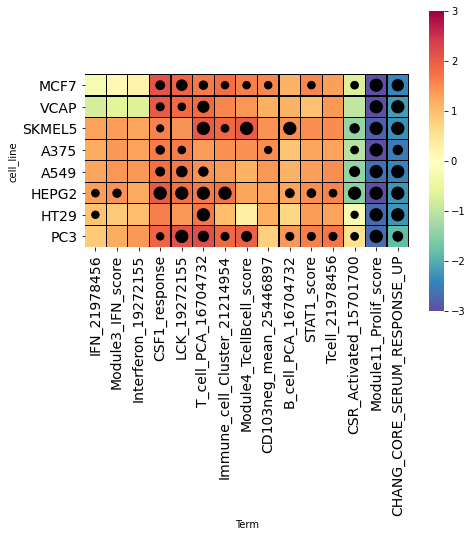

In [461]:
boPlot_gsea(corr=nes_vorinostat_cl[top_path_vorinostat[:15].index],
            fdr=-np.log10(p_vorinostat_cl[top_path_vorinostat[:15].index].astype(float) + 0.001),
            fdr_threshold=1., vmin=-3, vmax=3, path=panel_home + 'multi_hit_case/gsea_imsig_top/vorinostat.pdf')

# Figure 3G: MOAs of sig-R-shifting compounds across cell lines

In [49]:
top_cp_cl_count

cell_line         A375  A549  BT20  CL34  DU145  EFO27  HCC515  HELA  HEPG2  \
cmap_name                                                                     
3-Cl-AHPC          0.0   1.0   0.0   0.0    0.0    0.0     0.0   0.0    1.0   
5-BDBD             1.0   0.0   0.0   0.0    0.0    0.0     0.0   0.0    0.0   
5-iodotubercidin   1.0   0.0   0.0   0.0    0.0    0.0     1.0   0.0    0.0   
7b-cis             1.0   0.0   0.0   0.0    0.0    0.0     0.0   0.0    0.0   
A-443654           1.0   0.0   0.0   0.0    0.0    0.0     0.0   0.0    0.0   
...                ...   ...   ...   ...    ...    ...     ...   ...    ...   
vorinostat         1.0   1.0   0.0   0.0    0.0    0.0     0.0   0.0    1.0   
voxtalisib         0.0   0.0   0.0   0.0    0.0    0.0     0.0   0.0    0.0   
withaferin-a       0.0   1.0   0.0   0.0    0.0    0.0     1.0   0.0    0.0   
wortmannin         1.0   1.0   0.0   0.0    0.0    0.0     1.0   0.0    1.0   
zileuton           0.0   0.0   0.0   0.0    0.0    0.0     0.0   0.0    0.0   

cell_line         HS578T  ...  SKBR3  SKMEL1  SKMEL28  SKMEL5  SNUC5  SW620  \
cmap_name                 ...                                                 
3-Cl-AHPC            0.0  ...    0.0     0.0      0.0     0.0    0.0    0.0   
5-BDBD               0.0  ...    0.0     0.0      0.0     0.0    0.0    0.0   
5-iodotubercidin     0.0  ...    0.0     0.0      0.0     0.0    0.0    0.0   
7b-cis               0.0  ...    0.0     0.0      0.0     0.0    0.0    0.0   
A-443654             1.0  ...    0.0     0.0      0.0     0.0    0.0    0.0   
...                  ...  ...    ...     ...      ...     ...    ...    ...   
vorinostat           0.0  ...    0.0     0.0      0.0     1.0    1.0    0.0   
voxtalisib           0.0  ...    0.0     0.0      0.0     0.0    0.0    0.0   
withaferin-a         1.0  ...    1.0     0.0      0.0     0.0    0.0    0.0   
wortmannin           0.0  ...    0.0     0.0      0.0     0.0    0.0    0.0   
zileuton             0.0  ...    0.0     0.0      0.0     0.0    0.0    0.0   

cell_line         T3M10  VCAP  VMCUB1  YAPC  
cmap_name                                    
3-Cl-AHPC           0.0   0.0     0.0   0.0  
5-BDBD              0.0   0.0     0.0   0.0  
5-iodotubercidin    0.0   0.0     0.0   0.0  
7b-cis              0.0   0.0     0.0   0.0  
A-443654            0.0   0.0     0.0   0.0  
...                 ...   ...     ...   ...  
vorinostat          1.0   1.0     0.0   0.0  
voxtalisib          0.0   0.0     0.0   0.0  
withaferin-a        0.0   1.0     0.0   0.0  
wortmannin          0.0   1.0     0.0   0.0  
zileuton            0.0   1.0     0.0   0.0  

[780 rows x 35 columns]

In [50]:
tested_cl_count

cell_line             5637  A375  A549  AGS  AN3CA  BT20  BT474  CL34  CORL23  \
cmap_name                                                                       
1-NITRONAPHTHALENE     0.0   0.0   0.0  0.0    0.0   0.0    0.0   0.0     0.0   
10-DEBC                0.0   1.0   0.0  0.0    0.0   0.0    0.0   0.0     0.0   
1B                     0.0   1.0   0.0  0.0    0.0   0.0    0.0   0.0     0.0   
2-CHLOROACETOPHENONE   0.0   0.0   1.0  0.0    0.0   0.0    0.0   0.0     0.0   
2-aminopurine          0.0   0.0   0.0  0.0    0.0   0.0    0.0   0.0     0.0   
...                    ...   ...   ...  ...    ...   ...    ...   ...     ...   
zileuton               0.0   0.0   0.0  0.0    0.0   0.0    0.0   0.0     0.0   
ziprasidone            0.0   1.0   0.0  0.0    0.0   0.0    0.0   0.0     0.0   
zolantidine            0.0   0.0   0.0  0.0    0.0   0.0    0.0   0.0     0.0   
zosuquidar             0.0   1.0   0.0  0.0    0.0   0.0    0.0   0.0     0.0   
zoxazolamine           0.0   1.0   0.0  0.0    0.0   0.0    0.0   0.0     0.0   

cell_line             COV644  ...  SNUC4  SNUC5  SW480  SW620  SW948  T3M10  \
cmap_name                     ...                                             
1-NITRONAPHTHALENE       0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
10-DEBC                  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
1B                       0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2-CHLOROACETOPHENONE     0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2-aminopurine            0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
...                      ...  ...    ...    ...    ...    ...    ...    ...   
zileuton                 0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
ziprasidone              0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
zolantidine              0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
zosuquidar               0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
zoxazolamine             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   

cell_line             TYKNU  VCAP  VMCUB1  YAPC  
cmap_name                                        
1-NITRONAPHTHALENE      0.0   0.0     0.0   0.0  
10-DEBC                 0.0   0.0     0.0   0.0  
1B                      0.0   0.0     0.0   0.0  
2-CHLOROACETOPHENONE    0.0   0.0     0.0   0.0  
2-aminopurine           0.0   1.0     0.0   0.0  
...                     ...   ...     ...   ...  
zileuton                0.0   1.0     0.0   0.0  
ziprasidone             0.0   0.0     0.0   0.0  
zolantidine             0.0   0.0     0.0   0.0  
zosuquidar              0.0   0.0     0.0   0.0  
zoxazolamine            0.0   0.0     0.0   0.0  

[4264 rows x 64 columns]

In [51]:
# top compounds moa count
top_cp_cl_moa = pd.read_csv(poseidon_home + 'results/compound_top_moa/top_Rshifting_moa_count.csv',
                            header=0, index_col=0, sep=',')

In [52]:
top_cp_cl_moa

MCF7  SKBR3  MDAMB231  BT20  HS578T  \
Topoisomerase inhibitor                15.0    0.0       0.0   0.0     1.0   
CHK inhibitor                           1.0    0.0       1.0   0.0     2.0   
IKK inhibitor                           0.0    1.0       1.0   0.0     1.0   
MTOR inhibitor                          1.0    0.0       6.0   3.0     1.0   
Ribonucleotide reductase inhibitor      2.0    0.0       0.0   0.0     0.0   
...                                     ...    ...       ...   ...     ...   
Ubiquitin specific protease inhibitor   0.0    0.0       0.0   0.0     0.0   
Adenylyl cyclase activator              0.0    0.0       0.0   0.0     0.0   
Guanylyl cyclase activator              0.0    0.0       0.0   0.0     0.0   
11-beta-HSD1 inhibitor                  0.0    0.0       0.0   0.0     0.0   
GSK-3 inhibitor                         0.0    0.0       0.0   0.0     0.0   

                                       HELA  HT29  HEPG2  HUH7  A549  HCC515  \
Topoisomerase inhibitor                 5.0   8.0    5.0   1.0  14.0     4.0   
CHK inhibitor                           0.0   1.0    1.0   0.0   1.0     0.0   
IKK inhibitor                           0.0   3.0    1.0   0.0   2.0     1.0   
MTOR inhibitor                          0.0   3.0    0.0   0.0   6.0     2.0   
Ribonucleotide reductase inhibitor      1.0   2.0    2.0   0.0   2.0     0.0   
...                                     ...   ...    ...   ...   ...     ...   
Ubiquitin specific protease inhibitor   0.0   0.0    0.0   1.0   0.0     0.0   
Adenylyl cyclase activator              0.0   0.0    1.0   0.0   0.0     0.0   
Guanylyl cyclase activator              0.0   0.0    1.0   0.0   0.0     0.0   
11-beta-HSD1 inhibitor                  0.0   0.0    1.0   0.0   0.0     0.0   
GSK-3 inhibitor                         0.0   0.0    0.0   0.0   0.0     1.0   

                                       YAPC  PC3  LNCAP  VCAP  A375  SKMEL5  
Topoisomerase inhibitor                 1.0  8.0    1.0   7.0  15.0     2.0  
CHK inhibitor                           0.0  1.0    0.0   0.0   2.0     0.0  
IKK inhibitor                           0.0  3.0    0.0   1.0   2.0     0.0  
MTOR inhibitor                          1.0  9.0    0.0   2.0   3.0     2.0  
Ribonucleotide reductase inhibitor      1.0  2.0    0.0   1.0   2.0     0.0  
...                                     ...  ...    ...   ...   ...     ...  
Ubiquitin specific protease inhibitor   0.0  0.0    0.0   0.0   0.0     0.0  
Adenylyl cyclase activator              0.0  0.0    0.0   0.0   0.0     0.0  
Guanylyl cyclase activator              0.0  0.0    0.0   0.0   0.0     0.0  
11-beta-HSD1 inhibitor                  0.0  0.0    0.0   0.0   0.0     0.0  
GSK-3 inhibitor                         0.0  0.0    0.0   0.0   0.0     0.0  

[164 rows x 17 columns]

In [53]:
# total compounds moa count: only count the moa and cell lines available in top matrix
tested_cp_cl_moa = df(index=top_cp_cl_moa.index, columns=top_cp_cl_moa.columns)
for cl in top_cp_cl_moa.columns:
    tmp_cl = df(tested_cl_count[cl])
    tmp_cl['moa'] = compound_info['moa']
    tmp_cl = tmp_cl[tmp_cl['moa'].isin(top_cp_cl_moa.index)]
    tmp_cl = tmp_cl[tmp_cl[cl] > 0].dropna(axis=0, how='any')
    tmp_cl_moa = tmp_cl['moa'].value_counts()
    tested_cp_cl_moa[cl] = tmp_cl_moa
tested_cp_cl_moa = tested_cp_cl_moa.fillna(0)

In [54]:
tested_cp_cl_moa

MCF7  SKBR3  MDAMB231  BT20  HS578T  \
Topoisomerase inhibitor                17.0    1.0       6.0   1.0     1.0   
CHK inhibitor                           2.0    1.0       2.0   1.0     2.0   
IKK inhibitor                           5.0    2.0       2.0   2.0     2.0   
MTOR inhibitor                         16.0    8.0      11.0   8.0     8.0   
Ribonucleotide reductase inhibitor      2.0    0.0       1.0   0.0     0.0   
...                                     ...    ...       ...   ...     ...   
Ubiquitin specific protease inhibitor   1.0    0.0       0.0   0.0     0.0   
Adenylyl cyclase activator              1.0    0.0       0.0   0.0     0.0   
Guanylyl cyclase activator              2.0    0.0       1.0   0.0     0.0   
11-beta-HSD1 inhibitor                  0.0    0.0       0.0   0.0     0.0   
GSK-3 inhibitor                         1.0    1.0       0.0   0.0     1.0   

                                       HELA  HT29  HEPG2  HUH7  A549  HCC515  \
Topoisomerase inhibitor                11.0  16.0   13.0   3.0  17.0    13.0   
CHK inhibitor                           1.0   3.0    2.0   0.0   2.0     3.0   
IKK inhibitor                           1.0   5.0    5.0   0.0   5.0     5.0   
MTOR inhibitor                         11.0  16.0    6.0   0.0  15.0     9.0   
Ribonucleotide reductase inhibitor      1.0   3.0    2.0   1.0   2.0     2.0   
...                                     ...   ...    ...   ...   ...     ...   
Ubiquitin specific protease inhibitor   0.0   1.0    1.0   1.0   1.0     1.0   
Adenylyl cyclase activator              0.0   1.0    1.0   0.0   0.0     0.0   
Guanylyl cyclase activator              1.0   1.0    1.0   0.0   1.0     0.0   
11-beta-HSD1 inhibitor                  0.0   0.0    1.0   0.0   1.0     0.0   
GSK-3 inhibitor                         0.0   0.0    1.0   1.0   1.0     2.0   

                                       YAPC   PC3  LNCAP  VCAP  A375  SKMEL5  
Topoisomerase inhibitor                10.0  18.0    1.0  14.0  17.0     2.0  
CHK inhibitor                           1.0   3.0    0.0   2.0   3.0     0.0  
IKK inhibitor                           1.0   6.0    2.0   6.0   6.0     1.0  
MTOR inhibitor                         10.0  17.0    5.0   9.0  14.0     6.0  
Ribonucleotide reductase inhibitor      1.0   2.0    0.0   2.0   2.0     0.0  
...                                     ...   ...    ...   ...   ...     ...  
Ubiquitin specific protease inhibitor   0.0   1.0    0.0   1.0   1.0     0.0  
Adenylyl cyclase activator              0.0   0.0    0.0   0.0   1.0     0.0  
Guanylyl cyclase activator              1.0   0.0    0.0   0.0   1.0     0.0  
11-beta-HSD1 inhibitor                  1.0   0.0    0.0   0.0   0.0     0.0  
GSK-3 inhibitor                         0.0   2.0    0.0   3.0   1.0     0.0  

[164 rows x 17 columns]

In [55]:
percentage_moa = top_cp_cl_moa.astype(float) / tested_cp_cl_moa
percentage_moa = percentage_moa.fillna(-1)

In [56]:
percentage_moa

MCF7  SKBR3  MDAMB231   BT20  \
Topoisomerase inhibitor                0.882353    0.0  0.000000  0.000   
CHK inhibitor                          0.500000    0.0  0.500000  0.000   
IKK inhibitor                          0.000000    0.5  0.500000  0.000   
MTOR inhibitor                         0.062500    0.0  0.545455  0.375   
Ribonucleotide reductase inhibitor     1.000000   -1.0  0.000000 -1.000   
...                                         ...    ...       ...    ...   
Ubiquitin specific protease inhibitor  0.000000   -1.0 -1.000000 -1.000   
Adenylyl cyclase activator             0.000000   -1.0 -1.000000 -1.000   
Guanylyl cyclase activator             0.000000   -1.0  0.000000 -1.000   
11-beta-HSD1 inhibitor                -1.000000   -1.0 -1.000000 -1.000   
GSK-3 inhibitor                        0.000000    0.0 -1.000000 -1.000   

                                       HS578T      HELA      HT29     HEPG2  \
Topoisomerase inhibitor                 1.000  0.454545  0.500000  0.384615   
CHK inhibitor                           1.000  0.000000  0.333333  0.500000   
IKK inhibitor                           0.500  0.000000  0.600000  0.200000   
MTOR inhibitor                          0.125  0.000000  0.187500  0.000000   
Ribonucleotide reductase inhibitor     -1.000  1.000000  0.666667  1.000000   
...                                       ...       ...       ...       ...   
Ubiquitin specific protease inhibitor  -1.000 -1.000000  0.000000  0.000000   
Adenylyl cyclase activator             -1.000 -1.000000  0.000000  1.000000   
Guanylyl cyclase activator             -1.000  0.000000  0.000000  1.000000   
11-beta-HSD1 inhibitor                 -1.000 -1.000000 -1.000000  1.000000   
GSK-3 inhibitor                         0.000 -1.000000 -1.000000  0.000000   

                                           HUH7      A549    HCC515  YAPC  \
Topoisomerase inhibitor                0.333333  0.823529  0.307692   0.1   
CHK inhibitor                         -1.000000  0.500000  0.000000   0.0   
IKK inhibitor                         -1.000000  0.400000  0.200000   0.0   
MTOR inhibitor                        -1.000000  0.400000  0.222222   0.1   
Ribonucleotide reductase inhibitor     0.000000  1.000000  0.000000   1.0   
...                                         ...       ...       ...   ...   
Ubiquitin specific protease inhibitor  1.000000  0.000000  0.000000  -1.0   
Adenylyl cyclase activator            -1.000000 -1.000000 -1.000000  -1.0   
Guanylyl cyclase activator            -1.000000  0.000000 -1.000000   0.0   
11-beta-HSD1 inhibitor                -1.000000  0.000000 -1.000000   0.0   
GSK-3 inhibitor                        0.000000  0.000000  0.500000  -1.0   

                                            PC3  LNCAP      VCAP      A375  \
Topoisomerase inhibitor                0.444444    1.0  0.500000  0.882353   
CHK inhibitor                          0.333333   -1.0  0.000000  0.666667   
IKK inhibitor                          0.500000    0.0  0.166667  0.333333   
MTOR inhibitor                         0.529412    0.0  0.222222  0.214286   
Ribonucleotide reductase inhibitor     1.000000   -1.0  0.500000  1.000000   
...                                         ...    ...       ...       ...   
Ubiquitin specific protease inhibitor  0.000000   -1.0  0.000000  0.000000   
Adenylyl cyclase activator            -1.000000   -1.0 -1.000000  0.000000   
Guanylyl cyclase activator            -1.000000   -1.0 -1.000000  0.000000   
11-beta-HSD1 inhibitor                -1.000000   -1.0 -1.000000 -1.000000   
GSK-3 inhibitor                        0.000000   -1.0  0.000000  0.000000   

                                         SKMEL5  
Topoisomerase inhibitor                1.000000  
CHK inhibitor                         -1.000000  
IKK inhibitor                          0.000000  
MTOR inhibitor                         0.333333  
Ribonucleotide reductase inhibitor    -1.000000  
...                            

In [57]:
percentage_moa.loc['EGFR inhibitor', :]

MCF7        0.272727
SKBR3       0.333333
MDAMB231    0.181818
BT20        0.000000
HS578T      0.000000
HELA        0.000000
HT29        0.300000
HEPG2       0.000000
HUH7        0.000000
A549        0.071429
HCC515      0.750000
YAPC        0.300000
PC3         0.200000
LNCAP       0.333333
VCAP        0.142857
A375        0.066667
SKMEL5      0.000000
Name: EGFR inhibitor, dtype: float64

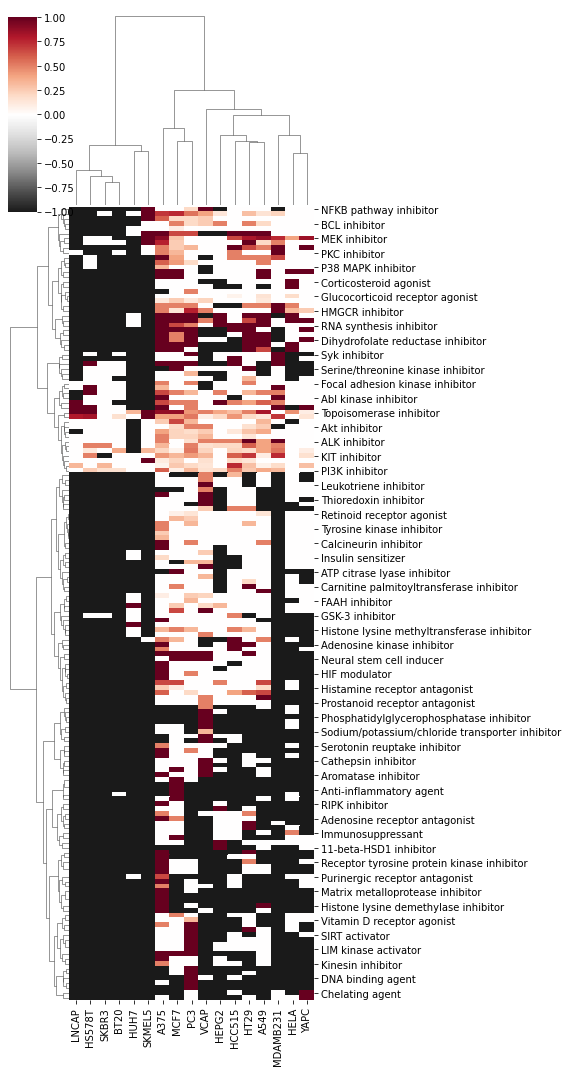

In [58]:
sns.clustermap(percentage_moa,
               figsize=(8, 15),
               method='ward',
               cmap='RdGy_r', vmin=-1, vmax=1)

In [59]:
# exclude the moa with too many -1
# this means most of the cell lines have not been tested by the compounds belong to this moa
# The criteria will be set as "at least 10 cell lines are tested"
percentage_moa_black_count = percentage_moa[percentage_moa == -1].fillna(0)
percentage_moa_black_count = df(percentage_moa_black_count.sum(axis=1))
percentage_moa_white_list = percentage_moa_black_count[percentage_moa_black_count[0] >= -7]
percentage_moa_white_list.shape

(57, 1)

In [60]:
tested_cp_cl_moa.loc['Estrogen receptor antagonist', :]

MCF7        6.0
SKBR3       0.0
MDAMB231    0.0
BT20        0.0
HS578T      0.0
HELA        1.0
HT29        3.0
HEPG2       3.0
HUH7        1.0
A549        3.0
HCC515      4.0
YAPC        1.0
PC3         2.0
LNCAP       0.0
VCAP        1.0
A375        3.0
SKMEL5      0.0
Name: Estrogen receptor antagonist, dtype: float64

In [61]:
percentage_moa_white_matrix = percentage_moa[percentage_moa.index.isin(percentage_moa_white_list.index)].T

In [62]:
percentage_moa_white_matrix = percentage_moa_white_matrix[percentage_moa_white_matrix != -1].fillna(-0.5)

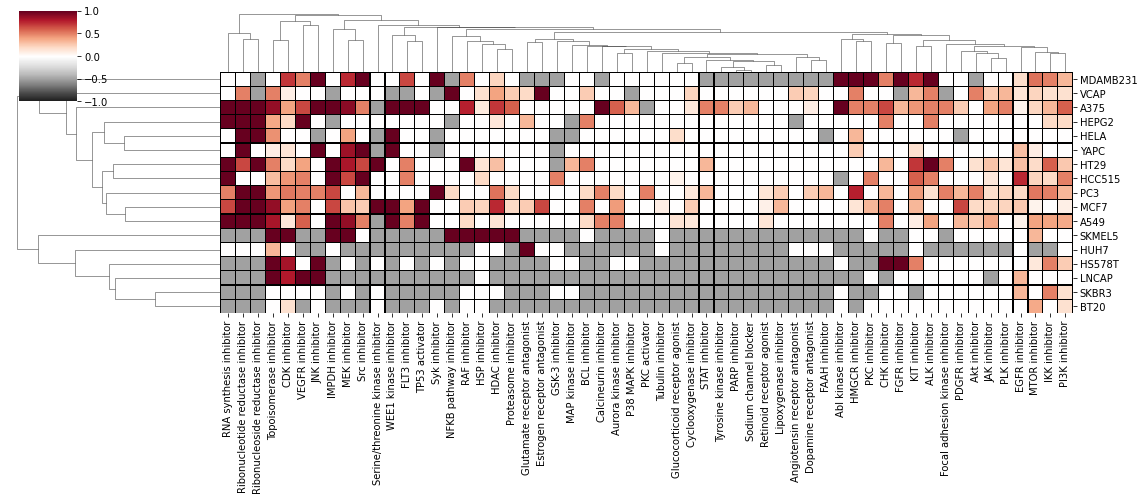

In [63]:
sns.clustermap(percentage_moa_white_matrix,
               figsize=(16, 7),
               method='average',
               cmap='RdGy_r', vmin=-1, vmax=1,
               linecolor='k',
               linewidths=0.1)
fig = plt.gcf()
fig.savefig(panel_home + 'top_shift_cl_by_moa_white_list.png', dpi=300, transparent=True)
fig.savefig(panel_home + 'top_shift_cl_by_moa_white_list.pdf', transparent=True)

In [47]:
compound_info[compound_info['moa'] == 'Ribonucleoside reductase inhibitor']

pert_id target                                 moa  \
cmap_name                                                               
clofarabine  BRD-K34022604  POLA1  Ribonucleoside reductase inhibitor   
hydroxyurea  BRD-K51747290   RRM1  Ribonucleoside reductase inhibitor   

                                              canonical_smiles  \
cmap_name                                                        
clofarabine  Nc1nc(Cl)nc2n(cnc12)[C@@H]1O[C@H](CO)[C@@H](O)...   
hydroxyurea                                           NC(=O)NO   

                               inchi_key compound_aliases  
cmap_name                                                  
clofarabine  WDDPHFBMKLOVOX-AYQXTPAHSA-N              NaN  
hydroxyurea  VSNHCAURESNICA-UHFFFAOYSA-N              NaN

In [49]:
compound_info[compound_info['moa'] == 'Ribonucleotide reductase inhibitor']

pert_id target                                 moa  \
cmap_name                                                               
cytarabine   BRD-K33106058  POLA1  Ribonucleotide reductase inhibitor   
gemcitabine  BRD-K15108141   RRM1  Ribonucleotide reductase inhibitor   
trimidox     BRD-K11801786   RRM1  Ribonucleotide reductase inhibitor   

                                              canonical_smiles  \
cmap_name                                                        
cytarabine   Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(=O)n1   
gemcitabine    Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)C2(F)F)c(=O)n1   
trimidox                              ONC(=N)c1cc(O)c(O)c(O)c1   

                               inchi_key compound_aliases  
cmap_name                                                  
cytarabine   UHDGCWIWMRVCDJ-CCXZUQQUSA-N              NaN  
gemcitabine  SDUQYLNIPVEERB-QPPQHZFASA-N              NaN  
trimidox     MSLJYSGFUMYUDX-UHFFFAOYSA-N              NaN

In [59]:
compound_info[compound_info['moa'] == 'IMPDH inhibitor']

pert_id  target              moa  \
cmap_name                                                       
AVN-944                BRD-K62196610  IMPDH1  IMPDH inhibitor   
merimepodib            BRD-K09372874  IMPDH1  IMPDH inhibitor   
mycophenolate-mofetil  BRD-K92428153  IMPDH1  IMPDH inhibitor   

                                                        canonical_smiles  \
cmap_name                                                                  
AVN-944                CC[C@H](CC#N)OC(=O)N[C@@H](C)c1cccc(NC(=O)Nc2c...   
merimepodib            COc1cc(NC(=O)Nc2cccc(CNC(=O)O[C@H]3CCOC3)c2)cc...   
mycophenolate-mofetil  COc1c(C)c2COC(=O)c2c(O)c1CC=C(/C)CCC(=O)OCCN1C...   

                                         inchi_key compound_aliases  
cmap_name                                                            
AVN-944                GYCPCOJTCINIFZ-OXJNMPFZSA-N              NaN  
merimepodib            JBPUGFODGPKTDW-SFHVURJKSA-N              NaN  
mycophenolate-mofetil  RTGDFNSFWBGLEC-SYZQJQIISA-N              NaN

In [50]:
compound_info.loc['gemcitabine', 'moa']

'Ribonucleotide reductase inhibitor'

In [51]:
compound_info.loc['mitoxantrone', 'moa']

'Topoisomerase inhibitor'

In [52]:
compound_info.loc['doxorubicin', 'moa']

'Topoisomerase inhibitor'

In [53]:
compound_info.loc['vorinostat', 'moa']

'HDAC inhibitor'

In [88]:
# find moas that are specific in one or two cell lines: percentage > 0.5 in less cell lines
specific_count = df(index=percentage_moa.index, columns=['percent_hi', 'number_hi', 'total_tested'])
for c in percentage_moa.index:
    tmp_c = df(percentage_moa.loc[c, :])
    tmp_c_tested = tmp_c[tmp_c[c] != -1]
    specific_count.at[c, 'total_tested'] = tmp_c_tested.shape[0]
    specific_count.at[c, 'number_hi'] = tmp_c_tested[tmp_c_tested[c] >= 0.5].shape[0]
    specific_count.at[c, 'percent_hi'] = tmp_c_tested[tmp_c_tested[c] >= 0.5].shape[0] / np.float(tmp_c_tested.shape[0]) 

In [89]:
specific_count = specific_count.sort_values(by='percent_hi', ascending=True)

In [90]:
specific_count[:50]

percent_hi number_hi  \
Angiotensin receptor antagonist                          0         0   
TRPV antagonist                                          0         0   
P-glycoprotein inhibitor                                 0         0   
Opioid receptor antagonist                               0         0   
P38 MAPK inhibitor                                       0         0   
Glucocorticoid receptor agonist                          0         0   
Histamine receptor antagonist                            0         0   
Dopamine receptor antagonist                             0         0   
Insulin sensitizer                                       0         0   
Retinoid receptor agonist                                0         0   
PARP inhibitor                                           0         0   
Sodium channel blocker                                   0         0   
MAP kinase inhibitor                                     0         0   
Dopamine receptor agonist                                0         0   
Tubulin inhibitor                                        0         0   
Lipoxygenase inhibitor                                   0         0   
Vitamin D receptor agonist                               0         0   
FAAH inhibitor                                           0         0   
JAK inhibitor                                            0         0   
Sodium/potassium/chloride transporter inhibitor          0         0   
Cyclooxygenase inhibitor                                 0         0   
HSP inhibitor                                    0.0588235         1   
EGFR inhibitor                                   0.0588235         1   
PLK inhibitor                                       0.0625         1   
PDGFR inhibitor                                  0.0666667         1   
Glutamate receptor antagonist                    0.0909091         1   
STAT inhibitor                                         0.1         1   
PKC activator                                          0.1         1   
Tyrosine kinase inhibitor                              0.1         1   
GSK-3 inhibitor                                        0.1         1   
Leukotriene inhibitor                             0.111111         1   
Protein synthesis inhibitor                       0.111111         1   
Opioid receptor agonist                           0.111111         1   
Corticosteroid agonist                            0.111111         1   
Tricyclic antidepressant                          0.111111         1   
Ubiquitin specific protease inhibitor             0.111111         1   
PI3K inhibitor                                    0.117647         2   
MTOR inhibitor                                       0.125         2   
Monoamine oxidase inhibitor                          0.125         1   
Estrogen receptor agonist                            0.125         1   
AMPK inhibitor                                       0.125         1   
CDC inhibitor                                        0.125         1   
Prostanoid receptor antagonist                       0.125         1   
DNA alkylating agent                                 0.125         1   
Guanylyl cyclase activator                           0.125         1   
Akt inhibitor                                     0.133333         2   
IMPase inhibitor                                  0.142857         1   
Dipeptidyl peptidase inhibitor                    0.142857         1   
FGFR inhibitor                                    0.142857         2   
FOXM1 inhibitor                                   0.142857         1   

                                                total_tested  
Angiotensin receptor antagonist                           10  
TRPV antagonist                                            7  
P-glycoprotein inhibitor                                   9  
Opioid receptor antagonist                                 8  
P38 MAPK inhibitor                                        11

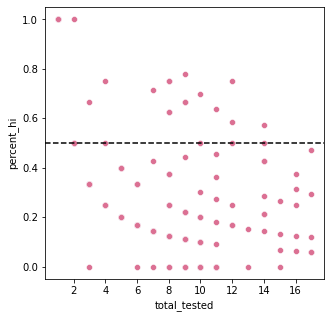

In [91]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='total_tested', y='percent_hi',
                color='palevioletred',
                data=specific_count)
plt.axhline(y=0.5, ls='--', c='k')

In [139]:
top_rs_cp_shift[top_rs_cp_shift['moa'] == 'Estrogen receptor agonist']

NREC_profile  REC_profile  \
CPC011_VCAP_24H:BRD-K35189033-001-21-2:10     -0.497131     0.416296   
CPC011_VCAP_24H:BRD-K18910433-001-23-4:10     -0.473069     0.347197   
CPC020_VCAP_24H:BRD-K90543092-001-02-0:10     -0.437655     0.346797   
CPC003_VCAP_24H:BRD-K18910433-001-05-1:10     -0.397677     0.385888   

                                                cmap_name  nearest_dose  \
CPC011_VCAP_24H:BRD-K35189033-001-21-2:10  levonorgestrel          10.0   
CPC011_VCAP_24H:BRD-K18910433-001-23-4:10       estradiol          10.0   
CPC020_VCAP_24H:BRD-K90543092-001-02-0:10  levonorgestrel          10.0   
CPC003_VCAP_24H:BRD-K18910433-001-05-1:10       estradiol          10.0   

                                          pert_idose  shift_ability cell_line  \
CPC011_VCAP_24H:BRD-K35189033-001-21-2:10      10 uM       0.913427      VCAP   
CPC011_VCAP_24H:BRD-K18910433-001-23-4:10      10 uM       0.820266      VCAP   
CPC020_VCAP_24H:BRD-K90543092-001-02-0:10      10 uM       0.784452      VCAP   
CPC003_VCAP_24H:BRD-K18910433-001-05-1:10      10 uM       0.783565      VCAP   

                                          cancer_type  \
CPC011_VCAP_24H:BRD-K35189033-001-21-2:10        PRAD   
CPC011_VCAP_24H:BRD-K18910433-001-23-4:10        PRAD   
CPC020_VCAP_24H:BRD-K90543092-001-02-0:10        PRAD   
CPC003_VCAP_24H:BRD-K18910433-001-05-1:10        PRAD   

                                                                 moa  
CPC011_VCAP_24H:BRD-K35189033-001-21-2:10  Estrogen receptor agonist  
CPC011_VCAP_24H:BRD-K18910433-001-23-4:10  Estrogen receptor agonist  
CPC020_VCAP_24H:BRD-K90543092-001-02-0:10  Estrogen receptor agonist  
CPC003_VCAP_24H:BRD-K18910433-001-05-1:10  Estrogen receptor agonist

In [ ]:
# EGFR inhibitor in HCC515
# HSP inhibitor in SKMEL5
# ER antagonist in MCF7 and VCAP

# Figure TBA: top 10 MOAs of each cell line (within sig-R-shifting)

In [43]:
# MOAs sorted by average shift ability in sig-R-shifting set
# add the MOA to sig-R-shifting matrix
top_rs_cp_shift['moa'] = 'Not available'

for s in top_rs_cp_shift.index:
    top_rs_cp_shift.at[s, 'moa'] = compound_info.loc[top_rs_cp_shift.loc[s, 'cmap_name'], 'moa']

top_rs_cp_shift['moa'] = top_rs_cp_shift['moa'].fillna('Not available')

<ipython-input-43-2330fac88511>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_rs_cp_shift['moa'] = 'Not available'
<ipython-input-43-2330fac88511>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_rs_cp_shift['moa'] = top_rs_cp_shift['moa'].fillna('Not available')


In [44]:
top_rs_cp_shift

NREC_profile  REC_profile      cmap_name  \
REP.A023_MCF7_24H:P14       -0.471999     0.456107    floxuridine   
LKCP002_MCF7_48H:B10        -0.458585     0.468354     tipifarnib   
PBIOA016_MCF7_24H:H03       -0.470885     0.447807    fulvestrant   
REP.A023_MCF7_24H:O15       -0.503013     0.412289     valrubicin   
REP.A015_MCF7_24H:E11       -0.473579     0.441700     epirubicin   
...                               ...          ...            ...   
EMU001_SKMEL5_24H:G14       -0.375714     0.339692   tanespimycin   
EMU001_SKMEL5_24H:M07       -0.438671     0.273783     everolimus   
AICHI002_SKMEL5_24H:L04     -0.301258     0.408771  BRD-K08177763   
EMU001_SKMEL5_24H:C20       -0.413372     0.296355   mitoxantrone   
EMU001_SKMEL5_24H:G16       -0.383972     0.325414   tanespimycin   

                         nearest_dose pert_idose  shift_ability cell_line  \
REP.A023_MCF7_24H:P14           3.330    3.33 uM       0.928106      MCF7   
LKCP002_MCF7_48H:B10           10.000      10 uM       0.926939      MCF7   
PBIOA016_MCF7_24H:H03           1.110    1.11 uM       0.918692      MCF7   
REP.A023_MCF7_24H:O15           1.110    1.11 uM       0.915302      MCF7   
REP.A015_MCF7_24H:E11           0.125   0.125 uM       0.915279      MCF7   
...                               ...        ...            ...       ...   
EMU001_SKMEL5_24H:G14           2.500     2.5 uM       0.715406    SKMEL5   
EMU001_SKMEL5_24H:M07          10.000      10 uM       0.712454    SKMEL5   
AICHI002_SKMEL5_24H:L04         0.125   0.125 uM       0.710029    SKMEL5   
EMU001_SKMEL5_24H:C20           2.500     2.5 uM       0.709727    SKMEL5   
EMU001_SKMEL5_24H:G16           0.125   0.125 uM       0.709386    SKMEL5   

                        cancer_type                           moa  
REP.A023_MCF7_24H:P14          BRCA                 Not available  
LKCP002_MCF7_48H:B10           BRCA                 Not available  
PBIOA016_MCF7_24H:H03          BRCA  Estrogen receptor antagonist  
REP.A023_MCF7_24H:O15          BRCA                 DNA inhibitor  
REP.A015_MCF7_24H:E11          BRCA       Topoisomerase inhibitor  
...                             ...                           ...  
EMU001_SKMEL5_24H:G14          SKCM                 HSP inhibitor  
EMU001_SKMEL5_24H:M07          SKCM                MTOR inhibitor  
AICHI002_SKMEL5_24H:L04        SKCM                 Not available  
EMU001_SKMEL5_24H:C20          SKCM       Topoisomerase inhibitor  
EMU001_SKMEL5_24H:G16          SKCM                 HSP inhibitor  

[3946 rows x 9 columns]

In [45]:
# only look into the experiments with moa
top_rs_cp_shift_w_moa = top_rs_cp_shift[top_rs_cp_shift['moa'] != 'Not available']
top_rs_cp_shift_w_moa.shape

(2840, 9)

In [46]:
# sort the average shift by moa in each cell line
moa_sort_av_shift = {}
for cl in top_rs_cp_shift_w_moa['cell_line'].unique():
    tmp_cl = top_rs_cp_shift_w_moa[top_rs_cp_shift_w_moa['cell_line'] == cl]
    tmp_cl_gp = df(df(tmp_cl.groupby('moa').mean())['shift_ability'])
    moa_sort_av_shift[cl] = list(tmp_cl_gp.sort_values(by='shift_ability', ascending=False)[:10].index)

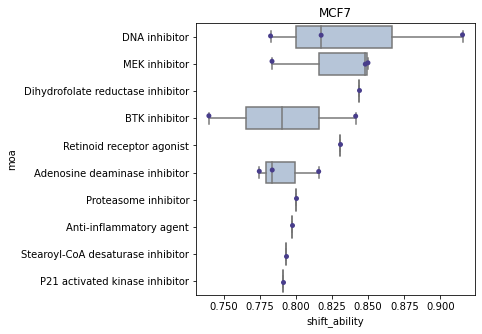

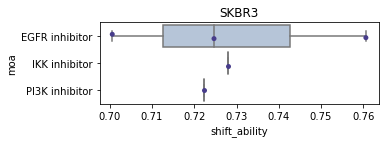

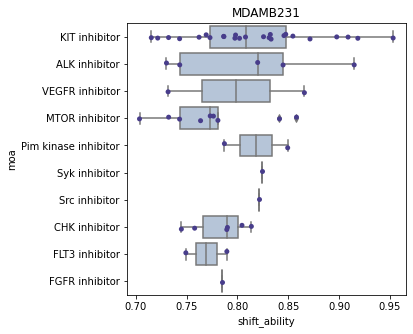

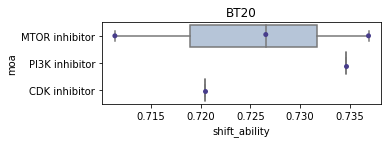

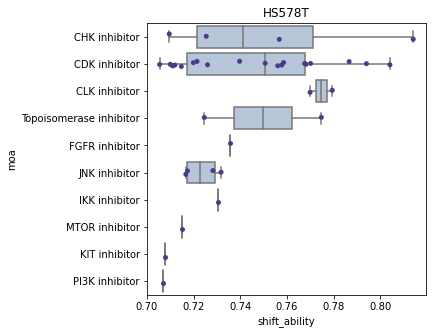

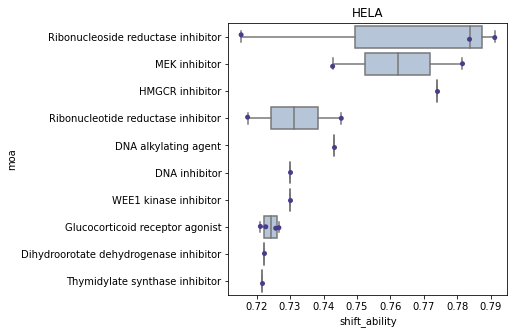

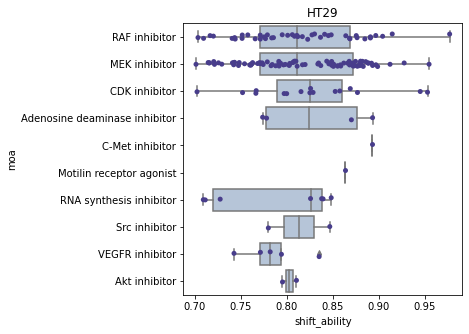

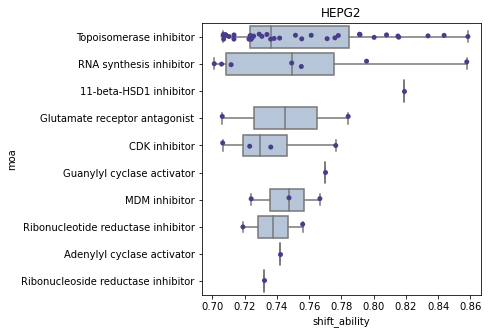

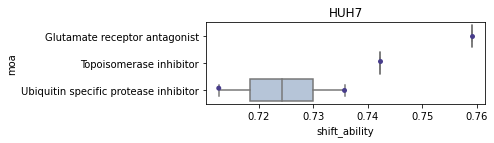

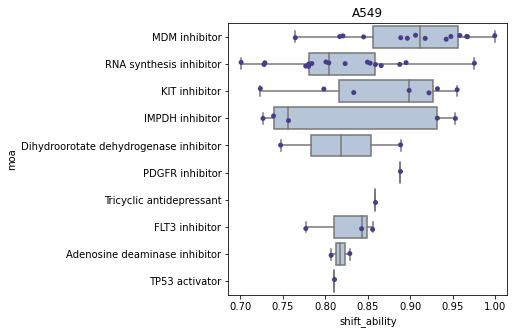

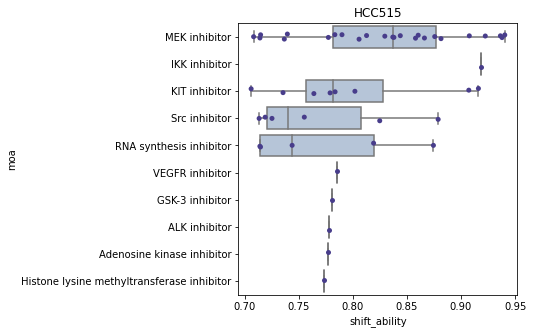

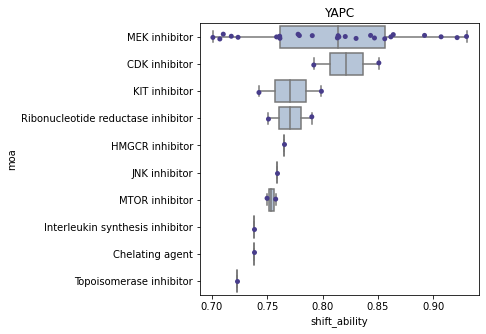

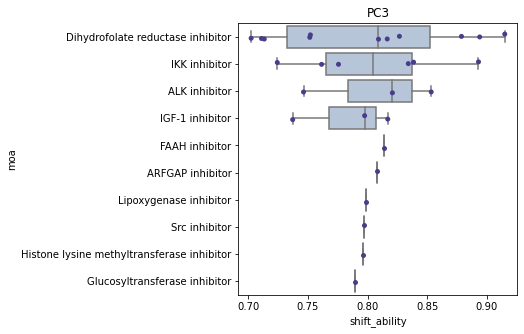

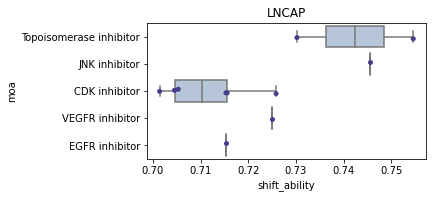

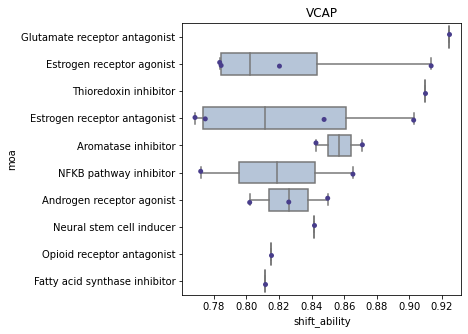

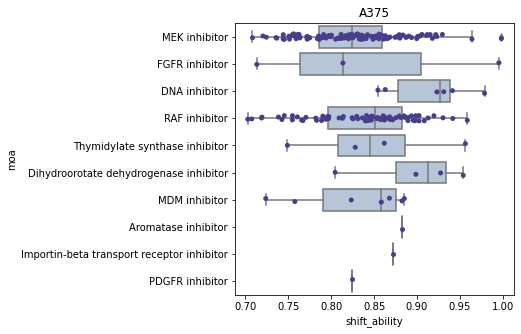

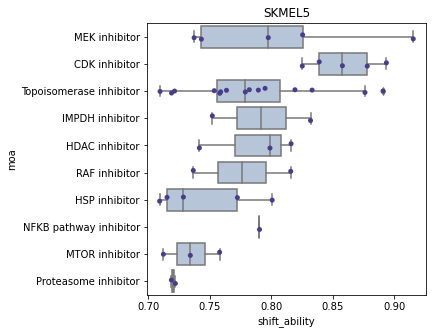

In [186]:
for cl in moa_sort_av_shift.keys():
    tmp_moa = moa_sort_av_shift[cl]
    tmp_top_shift = top_rs_cp_shift[top_rs_cp_shift['moa'].isin(tmp_moa)]
    tmp_top_shift = tmp_top_shift[tmp_top_shift['cell_line'] == cl]
    
    # visualize
    plt.figure(figsize=(5, len(tmp_moa) / 2))
    sns.boxplot(x='shift_ability',
                y='moa',
                data=tmp_top_shift,
                color='lightsteelblue')
    sns.stripplot(x='shift_ability',
                 y='moa',
                 data=tmp_top_shift,
                 color='darkslateblue')
    plt.title(cl)
    fig = plt.gcf()
    fig.savefig(panel_home + 'top_moa_distribution/sigRshifting_' + cl + '.png', dpi=300, transparent=True)
    fig.savefig(panel_home + 'top_moa_distribution/sigRshifting_' + cl + '.pdf', transparent=True)
    plt.show()